In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os


In [ ]:
# Setup paths for local execution
import os
import sys

# Project directories
BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), '..'))
DATA_DIR = os.path.join(BASE_DIR, 'data')
OUTPUT_DIR = os.path.join(BASE_DIR, 'outputs')
SRC_DIR = os.path.join(BASE_DIR, 'src')

# Add src to path
sys.path.insert(0, SRC_DIR)


Mounted at /content/drive/


In [3]:
data1 = pd.read_csv('../../data/stock_at_weekly_level.csv')

In [4]:
data1.drop(['Unnamed: 0'],axis=1,inplace=True)

In [5]:
data1['ds'] = pd.to_datetime(data1['week_start'])

In [6]:
data1.drop(['week_start'],axis=1,inplace=True)

In [7]:
data1 = data1.loc[data1['year'] > 2009,]

In [8]:
dtgc = data1.copy()

In [9]:
dtgc.head()

,StockCode,Quantity,week_no,wom,year,ds
51,10002,451.000000,1,0,2010,2010-01-04
52,10002,133.000000,2,1,2010,2010-01-11
53,10002,32.000000,3,2,2010,2010-01-18
54,10002,23.666667,4,3,2010,2010-01-25
55,10002,3.333333,5,0,2010,2010-02-01


In [10]:
dtgc.shape

(332273, 6)

In [11]:
dtgc['timeelapsed'] = dtgc.groupby(['StockCode'])[['ds']].shift(1)

In [12]:
dtgc['timeelapsed'] = (dtgc['ds'].sub(dtgc['timeelapsed'],axis=0).dt.days//7).fillna(1)

In [13]:
dtgc.min()

StockCode                    10002
Quantity                         0
week_no                          1
wom                              0
year                          2010
ds             2010-01-04 00:00:00
timeelapsed                      1
dtype: object

In [14]:
dtgc['cumsum'] = dtgc.groupby(['StockCode'])['Quantity'].cumsum()

In [15]:
dtgc['cumdist'] = dtgc.groupby(['StockCode','cumsum'])['timeelapsed'].cumsum()-1

In [16]:
averagedistance = dtgc.groupby(['StockCode'])['cumdist'].mean().reset_index().rename(columns={'cumdist':'averagedistance'})

In [17]:
averagedistance.head()

,StockCode,averagedistance
0,10002,1.791667
1,10080,3.625000
2,10120,1.781250
3,10123C,6.760417
4,10124A,4.858696


In [18]:
dtgc = dtgc.merge(averagedistance,on=['StockCode'],how='left')

In [19]:
dtgc.head()

,StockCode,Quantity,week_no,wom,year,ds,timeelapsed,cumsum,cumdist,averagedistance
0,10002,451.000000,1,0,2010,2010-01-04,1.0,451.000000,0.0,1.791667
1,10002,133.000000,2,1,2010,2010-01-11,1.0,584.000000,0.0,1.791667
2,10002,32.000000,3,2,2010,2010-01-18,1.0,616.000000,0.0,1.791667
3,10002,23.666667,4,3,2010,2010-01-25,1.0,639.666667,0.0,1.791667
4,10002,3.333333,5,0,2010,2010-02-01,1.0,643.000000,0.0,1.791667


In [20]:
mu = data1.groupby(['StockCode'])['Quantity'].mean().reset_index()
mu = mu.rename(columns={'Quantity':'mean'})
std = dtgc.groupby(['StockCode'])['Quantity'].std().reset_index()
std = std.rename(columns={'Quantity':'std'})
data1 = dtgc.merge(mu,on=['StockCode'],how='left')
data1 = data1.merge(std,on=['StockCode'],how='left')
data1['tQuantity'] = (data1['Quantity'] - data1['mean'])/(data1['std'])
data = data1.copy()
data['lag1'] = data.groupby('StockCode')['tQuantity'].shift(1)
data['lag4'] = data.groupby('StockCode')['tQuantity'].shift(4)
data['lag52'] = data.groupby('StockCode')['tQuantity'].shift(52)


In [21]:
data.isnull().sum()

StockCode               0
Quantity                0
week_no                 0
wom                     0
year                    0
ds                      0
timeelapsed             0
cumsum                  0
cumdist                 0
averagedistance         0
mean                    0
std                     0
tQuantity               0
lag1                 3797
lag4                15170
lag52              190781
dtype: int64

In [22]:
data.fillna(-1,inplace = True)

In [23]:
max_date = pd.to_datetime(data['ds']).max()
mx1_dt = (max_date - pd.to_timedelta(7, unit='w'))

In [24]:
data['ds'] = pd.to_datetime(data['ds'])
train = data.loc[data['ds'] <= mx1_dt,]

In [25]:
val = data.loc[data['ds'] > mx1_dt,]
val_f = val[[x for x in val.columns if x not in ['tQuantity','Quantity','mean','qtr','cumsum','timeelapsed']]]
val_f.index = val['ds']
val_f = val_f.drop(['ds'],axis=1)

In [26]:
train_f = train[[x for x in train.columns if x not in ['tQuantity','Quantity','mean','qtr','cumsum','timeelapsed']]]
train_f.index = train.ds
train_f = train_f.drop(['ds'],axis=1)

In [27]:
mx_dt = (train['ds'].max() - pd.to_timedelta(6, unit='w'))

In [28]:
train1 = train.loc[train['ds'] <= mx_dt,]
train1.index = train1['ds']
train1.drop(['ds'],axis=1,inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [29]:
val1 = train.loc[train['ds'] >  mx_dt,]

In [30]:
val1.index = val1['ds']
val1.drop(['ds'],axis=1,inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [31]:
test = data.loc[data['ds'] > val1.index.max(),]
test.index = test['ds']
test.drop(['ds'],axis=1,inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [32]:
train_x = train1[[x for x in train1.columns if x not in ['tQuantity','Quantity','mean','qtr','cumsum','timeelapsed']]]
train_y = train1['tQuantity']

In [33]:
! pip install category_encoders

     |████████████████████████████████| 81kB 3.5MB/s 


In [34]:
import category_encoders as ce
id_encoder =  ce.OrdinalEncoder()
id_encoder.fit(train_x['StockCode'])
train_x['id_cat'] = id_encoder.transform(train_x['StockCode'])
train_x1 = train_x.drop(['StockCode'],axis=1)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [35]:
val_x = val1[[x for x in val1.columns if x not in ['tQuantity','Quantity','mean','qtr','cumsum','timeelapsed']]]
val_y = val1['tQuantity']

In [36]:
val_x['id_cat'] = id_encoder.transform(val_x['StockCode'])
val_x1 = val_x.drop(['StockCode'],axis=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [37]:
test_x = test[[x for x in test.columns if x not in ['tQuantity','Quantity','mean','qtr','cumsum','timeelapsed']]]
test_x['id_cat'] = id_encoder.transform(test_x['StockCode'])
test_x1 = test_x.drop(['StockCode'],axis=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [38]:
train_f['id_cat'] = id_encoder.transform(train_f['StockCode'])
train_f = train_f.drop(['StockCode'],axis=1)

In [39]:
train_fy = train['tQuantity']

In [40]:
val_f['id_cat'] = id_encoder.transform(val_f['StockCode'])
val_f.drop(['StockCode'],axis=1,inplace=True)
val_fy = val['tQuantity']

In [41]:
! pip install optuna

     |████████████████████████████████| 296kB 5.1MB/s 
     |████████████████████████████████| 81kB 4.8MB/s 
     |████████████████████████████████| 1.1MB 7.2MB/s 
     |████████████████████████████████| 143kB 15.7MB/s 
     |████████████████████████████████| 112kB 15.3MB/s 
     |████████████████████████████████| 51kB 4.9MB/s 
     |████████████████████████████████| 481kB 13.7MB/s 
  Created wheel for alembic: filename=alembic-1.5.4-py2.py3-none-any.whl size=156314 sha256=c898cb2892ee873c5c8b8ee7b59271380befcd167ca0b476e05410646832e5c9
  Stored in directory: /root/.cache/pip/wheels/fd/2d/ec/5a1b1e2363ed68392d292d215facf588d5448198edd8078bc1
  Created wheel for Mako: filename=Mako-1.1.4-py2.py3-none-any.whl size=75675 sha256=7d49bd0d7166cc160cb5fb02589c9c0073215638ca7e496681e044664a45df70
  Stored in directory: /root/.cache/pip/wheels/ad/10/d3/aeb26e20d19045e2a68e5d3cbb57432e11b5d9c92c99f98d47
  Created wheel for pyperclip: filename=pyperclip-1.8.1-cp36-none-any.whl size=11120 sha256=5

In [42]:
import optuna
import optuna.integration.lightgbm as lgb
from optuna.integration.lightgbm import LightGBMTuner

In [44]:
params = {
    'objective': 'regression',
    'boosting_type':'gbdt',
    "eval_metric":'mape',
    'metric':'l1'
}

In [45]:
train_x1.columns.tolist()

['week_no',
 'wom',
 'year',
 'cumdist',
 'averagedistance',
 'std',
 'lag1',
 'lag4',
 'lag52',
 'id_cat']

In [46]:
categorical_feature = ['week_no','wom','id_cat']

In [47]:
lgb_train = lgb.Dataset(train_x1,train_y,categorical_feature=categorical_feature)
lgb_valid = lgb.Dataset(val_x1, val_y, reference=lgb_train)
lgb_test = lgb.Dataset(test_x1,reference=lgb_train)

In [48]:
tuned_model = LightGBMTuner(params, train_set=lgb_train,
                                     valid_sets=lgb_valid,
                                     num_boost_round=300,
                                     early_stopping_rounds=30,
                                    )

[I 2021-02-20 12:03:41,787] A new study created in memory with name: no-name-cb7f7bb7-ae2d-475e-bda2-840d37b857ee


In [49]:
tuned_model.run()

feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning:

Using categorical_feature in Dataset.

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['id_cat', 'week_no', 'wom']

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.



[1]	valid_0's l1: 0.513353
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l1: 0.495049
[3]	valid_0's l1: 0.475717
[4]	valid_0's l1: 0.462022
[5]	valid_0's l1: 0.444564
[6]	valid_0's l1: 0.446835
[7]	valid_0's l1: 0.433528
[8]	valid_0's l1: 0.434579
[9]	valid_0's l1: 0.422097
[10]	valid_0's l1: 0.423784
[11]	valid_0's l1: 0.414398
[12]	valid_0's l1: 0.407668
[13]	valid_0's l1: 0.400397
[14]	valid_0's l1: 0.393934
[15]	valid_0's l1: 0.39106
[16]	valid_0's l1: 0.3912
[17]	valid_0's l1: 0.383664
[18]	valid_0's l1: 0.377154
[19]	valid_0's l1: 0.376321
[20]	valid_0's l1: 0.376322
[21]	valid_0's l1: 0.371396
[22]	valid_0's l1: 0.367073
[23]	valid_0's l1: 0.363654
[24]	valid_0's l1: 0.363397
[25]	valid_0's l1: 0.363326
[26]	valid_0's l1: 0.362833
[27]	valid_0's l1: 0.359595
[28]	valid_0's l1: 0.356736
[29]	valid_0's l1: 0.355538
[30]	valid_0's l1: 0.3526
[31]	valid_0's l1: 0.350038
[32]	valid_0's l1: 0.347913
[33]	valid_0's l1: 0.34676
[34]	valid_0's l1: 0.344956
[

feature_fraction, val_score: 0.330930:  14%|#4        | 1/7 [00:02<00:16,  2.77s/it]

[104]	valid_0's l1: 0.331082
Early stopping, best iteration is:
[74]	valid_0's l1: 0.33093
[1]	valid_0's l1: 0.513342
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l1: 0.492904
[3]	valid_0's l1: 0.474138
[4]	valid_0's l1: 0.457799
[5]	valid_0's l1: 0.441086
[6]	valid_0's l1: 0.429341
[7]	valid_0's l1: 0.417602
[8]	valid_0's l1: 0.419077
[9]	valid_0's l1: 0.409407
[10]	valid_0's l1: 0.401834
[11]	valid_0's l1: 0.394637
[12]	valid_0's l1: 0.388433
[13]	valid_0's l1: 0.381631
[14]	valid_0's l1: 0.376926
[15]	valid_0's l1: 0.376281
[16]	valid_0's l1: 0.37634
[17]	valid_0's l1: 0.370611
[18]	valid_0's l1: 0.366017
[19]	valid_0's l1: 0.365673
[20]	valid_0's l1: 0.365155
[21]	valid_0's l1: 0.361412
[22]	valid_0's l1: 0.359123
[23]	valid_0's l1: 0.357082
[24]	valid_0's l1: 0.356844
[25]	valid_0's l1: 0.355025
[26]	valid_0's l1: 0.353892
[27]	valid_0's l1: 0.351824
[28]	valid_0's l1: 0.350171
[29]	valid_0's l1: 0.348403
[30]	valid_0's l1: 0.346758
[31]	valid_0's l1

feature_fraction, val_score: 0.330930:  29%|##8       | 2/7 [00:05<00:14,  2.87s/it]

[105]	valid_0's l1: 0.33302
[106]	valid_0's l1: 0.333011
[107]	valid_0's l1: 0.332969
[108]	valid_0's l1: 0.333003
[109]	valid_0's l1: 0.333015
[110]	valid_0's l1: 0.333011
[111]	valid_0's l1: 0.33302
[112]	valid_0's l1: 0.332973
[113]	valid_0's l1: 0.332978
Early stopping, best iteration is:
[83]	valid_0's l1: 0.33242
[1]	valid_0's l1: 0.510962
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l1: 0.488263
[3]	valid_0's l1: 0.469552
[4]	valid_0's l1: 0.453861
[5]	valid_0's l1: 0.43841
[6]	valid_0's l1: 0.425823
[7]	valid_0's l1: 0.414589
[8]	valid_0's l1: 0.404382
[9]	valid_0's l1: 0.395036
[10]	valid_0's l1: 0.387571
[11]	valid_0's l1: 0.381998
[12]	valid_0's l1: 0.376786
[13]	valid_0's l1: 0.372471
[14]	valid_0's l1: 0.36725
[15]	valid_0's l1: 0.364289
[16]	valid_0's l1: 0.362001
[17]	valid_0's l1: 0.359371
[18]	valid_0's l1: 0.356687
[19]	valid_0's l1: 0.354135
[20]	valid_0's l1: 0.351814
[21]	valid_0's l1: 0.350395
[22]	valid_0's l1: 0.349203
[23]	valid_0

feature_fraction, val_score: 0.330930:  43%|####2     | 3/7 [00:10<00:13,  3.49s/it]

[208]	valid_0's l1: 0.333301
Early stopping, best iteration is:
[178]	valid_0's l1: 0.333282
[1]	valid_0's l1: 0.510962
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l1: 0.490554
[3]	valid_0's l1: 0.470397
[4]	valid_0's l1: 0.453544
[5]	valid_0's l1: 0.440099
[6]	valid_0's l1: 0.427752
[7]	valid_0's l1: 0.416028
[8]	valid_0's l1: 0.417109
[9]	valid_0's l1: 0.407047
[10]	valid_0's l1: 0.398343
[11]	valid_0's l1: 0.391104
[12]	valid_0's l1: 0.384369
[13]	valid_0's l1: 0.37765
[14]	valid_0's l1: 0.373581
[15]	valid_0's l1: 0.369588
[16]	valid_0's l1: 0.365787
[17]	valid_0's l1: 0.362347
[18]	valid_0's l1: 0.359844
[19]	valid_0's l1: 0.357305
[20]	valid_0's l1: 0.355913
[21]	valid_0's l1: 0.353836
[22]	valid_0's l1: 0.351916
[23]	valid_0's l1: 0.350673
[24]	valid_0's l1: 0.349424
[25]	valid_0's l1: 0.347595
[26]	valid_0's l1: 0.34584
[27]	valid_0's l1: 0.345545
[28]	valid_0's l1: 0.3443
[29]	valid_0's l1: 0.343204
[30]	valid_0's l1: 0.342566
[31]	valid_0's l1:

feature_fraction, val_score: 0.330930:  57%|#####7    | 4/7 [00:15<00:11,  3.74s/it]

[169]	valid_0's l1: 0.333471
[170]	valid_0's l1: 0.33345
[171]	valid_0's l1: 0.333521
Early stopping, best iteration is:
[141]	valid_0's l1: 0.332956
[1]	valid_0's l1: 0.512739
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l1: 0.508687
[3]	valid_0's l1: 0.510395
[4]	valid_0's l1: 0.491389
[5]	valid_0's l1: 0.47438
[6]	valid_0's l1: 0.45604
[7]	valid_0's l1: 0.444392
[8]	valid_0's l1: 0.430358
[9]	valid_0's l1: 0.42905
[10]	valid_0's l1: 0.424035
[11]	valid_0's l1: 0.424738
[12]	valid_0's l1: 0.42023
[13]	valid_0's l1: 0.419011
[14]	valid_0's l1: 0.415383
[15]	valid_0's l1: 0.415902
[16]	valid_0's l1: 0.406955
[17]	valid_0's l1: 0.399573
[18]	valid_0's l1: 0.392337
[19]	valid_0's l1: 0.392462
[20]	valid_0's l1: 0.392413
[21]	valid_0's l1: 0.392395
[22]	valid_0's l1: 0.390155
[23]	valid_0's l1: 0.382698
[24]	valid_0's l1: 0.381933
[25]	valid_0's l1: 0.375374
[26]	valid_0's l1: 0.370332
[27]	valid_0's l1: 0.368432
[28]	valid_0's l1: 0.367757
[29]	valid_0's l1

feature_fraction, val_score: 0.330930:  71%|#######1  | 5/7 [00:19<00:07,  3.80s/it]

[190]	valid_0's l1: 0.336324
Early stopping, best iteration is:
[160]	valid_0's l1: 0.335597
[1]	valid_0's l1: 0.512883
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l1: 0.492522
[3]	valid_0's l1: 0.47306
[4]	valid_0's l1: 0.455323
[5]	valid_0's l1: 0.438663
[6]	valid_0's l1: 0.426485
[7]	valid_0's l1: 0.416168
[8]	valid_0's l1: 0.417537
[9]	valid_0's l1: 0.408729
[10]	valid_0's l1: 0.399964
[11]	valid_0's l1: 0.39356
[12]	valid_0's l1: 0.387182
[13]	valid_0's l1: 0.380818
[14]	valid_0's l1: 0.375825
[15]	valid_0's l1: 0.371373
[16]	valid_0's l1: 0.37161
[17]	valid_0's l1: 0.366127
[18]	valid_0's l1: 0.362012
[19]	valid_0's l1: 0.35852
[20]	valid_0's l1: 0.356457
[21]	valid_0's l1: 0.354497
[22]	valid_0's l1: 0.352724
[23]	valid_0's l1: 0.351843
[24]	valid_0's l1: 0.350788
[25]	valid_0's l1: 0.349272
[26]	valid_0's l1: 0.348639
[27]	valid_0's l1: 0.347528
[28]	valid_0's l1: 0.345974
[29]	valid_0's l1: 0.344601
[30]	valid_0's l1: 0.344379
[31]	valid_0's l1:

feature_fraction, val_score: 0.329122:  86%|########5 | 6/7 [00:24<00:04,  4.14s/it]

[1]	valid_0's l1: 0.513342
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l1: 0.493209
[3]	valid_0's l1: 0.473604
[4]	valid_0's l1: 0.458339
[5]	valid_0's l1: 0.441852
[6]	valid_0's l1: 0.443883
[7]	valid_0's l1: 0.430593
[8]	valid_0's l1: 0.431795
[9]	valid_0's l1: 0.419786
[10]	valid_0's l1: 0.412102
[11]	valid_0's l1: 0.404173
[12]	valid_0's l1: 0.397532
[13]	valid_0's l1: 0.390052
[14]	valid_0's l1: 0.384947
[15]	valid_0's l1: 0.382652
[16]	valid_0's l1: 0.384352
[17]	valid_0's l1: 0.377863
[18]	valid_0's l1: 0.373122
[19]	valid_0's l1: 0.372165
[20]	valid_0's l1: 0.369888
[21]	valid_0's l1: 0.365943
[22]	valid_0's l1: 0.362525
[23]	valid_0's l1: 0.36
[24]	valid_0's l1: 0.359897
[25]	valid_0's l1: 0.357876
[26]	valid_0's l1: 0.357541
[27]	valid_0's l1: 0.355679
[28]	valid_0's l1: 0.353606
[29]	valid_0's l1: 0.35323
[30]	valid_0's l1: 0.35159
[31]	valid_0's l1: 0.350502
[32]	valid_0's l1: 0.348896
[33]	valid_0's l1: 0.348126
[34]	valid_0's l1: 0.346479
[

num_leaves, val_score: 0.329122:   0%|          | 0/20 [00:00<?, ?it/s]

[138]	valid_0's l1: 0.33432
[139]	valid_0's l1: 0.334323
[140]	valid_0's l1: 0.334315
[141]	valid_0's l1: 0.334298
[142]	valid_0's l1: 0.334337
[143]	valid_0's l1: 0.334694
[144]	valid_0's l1: 0.334676
Early stopping, best iteration is:
[114]	valid_0's l1: 0.334097
[1]	valid_0's l1: 0.512694
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l1: 0.491052
[3]	valid_0's l1: 0.470809
[4]	valid_0's l1: 0.454244
[5]	valid_0's l1: 0.437522
[6]	valid_0's l1: 0.425471
[7]	valid_0's l1: 0.413374
[8]	valid_0's l1: 0.412884
[9]	valid_0's l1: 0.402965
[10]	valid_0's l1: 0.395263
[11]	valid_0's l1: 0.388471
[12]	valid_0's l1: 0.38221
[13]	valid_0's l1: 0.37537
[14]	valid_0's l1: 0.37028
[15]	valid_0's l1: 0.364769
[16]	valid_0's l1: 0.364512
[17]	valid_0's l1: 0.35929
[18]	valid_0's l1: 0.355719
[19]	valid_0's l1: 0.351741
[20]	valid_0's l1: 0.349444
[21]	valid_0's l1: 0.347084
[22]	valid_0's l1: 0.345471
[23]	valid_0's l1: 0.344209
[24]	valid_0's l1: 0.343127
[25]	valid_0'

num_leaves, val_score: 0.329122:   5%|5         | 1/20 [00:03<01:14,  3.91s/it]

[100]	valid_0's l1: 0.331667
Early stopping, best iteration is:
[70]	valid_0's l1: 0.330254
[1]	valid_0's l1: 0.512153
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l1: 0.49065
[3]	valid_0's l1: 0.470029
[4]	valid_0's l1: 0.453306
[5]	valid_0's l1: 0.436247
[6]	valid_0's l1: 0.423694
[7]	valid_0's l1: 0.412555
[8]	valid_0's l1: 0.413299
[9]	valid_0's l1: 0.40314
[10]	valid_0's l1: 0.394596
[11]	valid_0's l1: 0.387121
[12]	valid_0's l1: 0.381155
[13]	valid_0's l1: 0.374634
[14]	valid_0's l1: 0.369725
[15]	valid_0's l1: 0.364122
[16]	valid_0's l1: 0.36461
[17]	valid_0's l1: 0.359624
[18]	valid_0's l1: 0.356729
[19]	valid_0's l1: 0.353576
[20]	valid_0's l1: 0.35131
[21]	valid_0's l1: 0.349658
[22]	valid_0's l1: 0.348023
[23]	valid_0's l1: 0.346353
[24]	valid_0's l1: 0.345058
[25]	valid_0's l1: 0.343158
[26]	valid_0's l1: 0.342255
[27]	valid_0's l1: 0.340777
[28]	valid_0's l1: 0.339456
[29]	valid_0's l1: 0.338015
[30]	valid_0's l1: 0.33744
[31]	valid_0's l1: 0

num_leaves, val_score: 0.329122:  10%|#         | 2/20 [00:09<01:16,  4.27s/it]

[104]	valid_0's l1: 0.334935
Early stopping, best iteration is:
[74]	valid_0's l1: 0.332884
[1]	valid_0's l1: 0.511243
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l1: 0.489333
[3]	valid_0's l1: 0.469463
[4]	valid_0's l1: 0.452055
[5]	valid_0's l1: 0.435055
[6]	valid_0's l1: 0.42191
[7]	valid_0's l1: 0.409538
[8]	valid_0's l1: 0.408971
[9]	valid_0's l1: 0.398758
[10]	valid_0's l1: 0.389959
[11]	valid_0's l1: 0.382287
[12]	valid_0's l1: 0.374558
[13]	valid_0's l1: 0.368002
[14]	valid_0's l1: 0.362956
[15]	valid_0's l1: 0.357884
[16]	valid_0's l1: 0.357911
[17]	valid_0's l1: 0.353049
[18]	valid_0's l1: 0.349793
[19]	valid_0's l1: 0.346491
[20]	valid_0's l1: 0.343835
[21]	valid_0's l1: 0.34141
[22]	valid_0's l1: 0.339986
[23]	valid_0's l1: 0.338214
[24]	valid_0's l1: 0.336695
[25]	valid_0's l1: 0.335579
[26]	valid_0's l1: 0.334454
[27]	valid_0's l1: 0.333055
[28]	valid_0's l1: 0.331784
[29]	valid_0's l1: 0.330921
[30]	valid_0's l1: 0.33063
[31]	valid_0's l1:

num_leaves, val_score: 0.327413:  15%|#5        | 3/20 [00:16<01:26,  5.09s/it]

[1]	valid_0's l1: 0.511484
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l1: 0.489783
[3]	valid_0's l1: 0.470476
[4]	valid_0's l1: 0.453912
[5]	valid_0's l1: 0.437049
[6]	valid_0's l1: 0.42361
[7]	valid_0's l1: 0.411526
[8]	valid_0's l1: 0.410724
[9]	valid_0's l1: 0.400258
[10]	valid_0's l1: 0.391281
[11]	valid_0's l1: 0.383994
[12]	valid_0's l1: 0.37694
[13]	valid_0's l1: 0.370307
[14]	valid_0's l1: 0.365749
[15]	valid_0's l1: 0.360685
[16]	valid_0's l1: 0.360998
[17]	valid_0's l1: 0.35609
[18]	valid_0's l1: 0.352701
[19]	valid_0's l1: 0.349268
[20]	valid_0's l1: 0.346472
[21]	valid_0's l1: 0.344358
[22]	valid_0's l1: 0.342467
[23]	valid_0's l1: 0.341099
[24]	valid_0's l1: 0.339848
[25]	valid_0's l1: 0.338228
[26]	valid_0's l1: 0.337315
[27]	valid_0's l1: 0.335808
[28]	valid_0's l1: 0.334448
[29]	valid_0's l1: 0.333343
[30]	valid_0's l1: 0.333161
[31]	valid_0's l1: 0.332889
[32]	valid_0's l1: 0.332202
[33]	valid_0's l1: 0.332131
[34]	valid_0's l1: 0.33160

num_leaves, val_score: 0.327413:  20%|##        | 4/20 [00:20<01:19,  4.99s/it]

[1]	valid_0's l1: 0.513079
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l1: 0.492614
[3]	valid_0's l1: 0.473069
[4]	valid_0's l1: 0.455591
[5]	valid_0's l1: 0.438723
[6]	valid_0's l1: 0.42711
[7]	valid_0's l1: 0.41678
[8]	valid_0's l1: 0.413994
[9]	valid_0's l1: 0.40446
[10]	valid_0's l1: 0.395573
[11]	valid_0's l1: 0.388877
[12]	valid_0's l1: 0.38258
[13]	valid_0's l1: 0.376119
[14]	valid_0's l1: 0.371526
[15]	valid_0's l1: 0.366179
[16]	valid_0's l1: 0.366221
[17]	valid_0's l1: 0.360951
[18]	valid_0's l1: 0.357309
[19]	valid_0's l1: 0.354193
[20]	valid_0's l1: 0.351727
[21]	valid_0's l1: 0.350058
[22]	valid_0's l1: 0.348141
[23]	valid_0's l1: 0.346831
[24]	valid_0's l1: 0.345387
[25]	valid_0's l1: 0.34439
[26]	valid_0's l1: 0.343431
[27]	valid_0's l1: 0.342968
[28]	valid_0's l1: 0.341426
[29]	valid_0's l1: 0.340706
[30]	valid_0's l1: 0.340767
[31]	valid_0's l1: 0.340404
[32]	valid_0's l1: 0.339736
[33]	valid_0's l1: 0.338515
[34]	valid_0's l1: 0.337259


num_leaves, val_score: 0.327413:  25%|##5       | 5/20 [00:23<01:06,  4.44s/it]

[103]	valid_0's l1: 0.331793
[104]	valid_0's l1: 0.331783
[105]	valid_0's l1: 0.331733
[106]	valid_0's l1: 0.331674
[107]	valid_0's l1: 0.33167
[108]	valid_0's l1: 0.331664
[109]	valid_0's l1: 0.331657
[110]	valid_0's l1: 0.331656
[111]	valid_0's l1: 0.331641
[112]	valid_0's l1: 0.331855
[113]	valid_0's l1: 0.331847
Early stopping, best iteration is:
[83]	valid_0's l1: 0.331613
[1]	valid_0's l1: 0.517147
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l1: 0.50012
[3]	valid_0's l1: 0.48517
[4]	valid_0's l1: 0.47259
[5]	valid_0's l1: 0.462144
[6]	valid_0's l1: 0.453648
[7]	valid_0's l1: 0.446938
[8]	valid_0's l1: 0.446787
[9]	valid_0's l1: 0.441208
[10]	valid_0's l1: 0.436935
[11]	valid_0's l1: 0.433712
[12]	valid_0's l1: 0.431398
[13]	valid_0's l1: 0.429869
[14]	valid_0's l1: 0.428924
[15]	valid_0's l1: 0.426729
[16]	valid_0's l1: 0.425084
[17]	valid_0's l1: 0.423971
[18]	valid_0's l1: 0.422238
[19]	valid_0's l1: 0.421268
[20]	valid_0's l1: 0.419771
[21]	vali

num_leaves, val_score: 0.327413:  30%|###       | 6/20 [00:26<00:54,  3.86s/it]

[289]	valid_0's l1: 0.395254
[290]	valid_0's l1: 0.395269
[291]	valid_0's l1: 0.395238
[292]	valid_0's l1: 0.395237
[293]	valid_0's l1: 0.395221
[294]	valid_0's l1: 0.395212
[295]	valid_0's l1: 0.395003
[296]	valid_0's l1: 0.395052
[297]	valid_0's l1: 0.394929
[298]	valid_0's l1: 0.395048
[299]	valid_0's l1: 0.395065
[300]	valid_0's l1: 0.395076
Did not meet early stopping. Best iteration is:
[297]	valid_0's l1: 0.394929
[1]	valid_0's l1: 0.514382
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l1: 0.49546
[3]	valid_0's l1: 0.477067
[4]	valid_0's l1: 0.462452
[5]	valid_0's l1: 0.447025
[6]	valid_0's l1: 0.436161
[7]	valid_0's l1: 0.42664
[8]	valid_0's l1: 0.429424
[9]	valid_0's l1: 0.422071
[10]	valid_0's l1: 0.414729
[11]	valid_0's l1: 0.409565
[12]	valid_0's l1: 0.402649
[13]	valid_0's l1: 0.397245
[14]	valid_0's l1: 0.393914
[15]	valid_0's l1: 0.39037
[16]	valid_0's l1: 0.389321
[17]	valid_0's l1: 0.386698
[18]	valid_0's l1: 0.384154
[19]	valid_0's l1: 0.

num_leaves, val_score: 0.327413:  35%|###5      | 7/20 [00:30<00:50,  3.88s/it]


[287]	valid_0's l1: 0.34353
[288]	valid_0's l1: 0.343517
[289]	valid_0's l1: 0.343571
[290]	valid_0's l1: 0.343562
[291]	valid_0's l1: 0.343578
[292]	valid_0's l1: 0.343603
[293]	valid_0's l1: 0.343596
[294]	valid_0's l1: 0.343593
[295]	valid_0's l1: 0.343601
[296]	valid_0's l1: 0.343609
[297]	valid_0's l1: 0.343578
[298]	valid_0's l1: 0.343063
[299]	valid_0's l1: 0.343045
[300]	valid_0's l1: 0.343059
Did not meet early stopping. Best iteration is:
[299]	valid_0's l1: 0.343045
[1]	valid_0's l1: 0.511068
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l1: 0.488953
[3]	valid_0's l1: 0.46876
[4]	valid_0's l1: 0.451428
[5]	valid_0's l1: 0.434509
[6]	valid_0's l1: 0.421552
[7]	valid_0's l1: 0.409087
[8]	valid_0's l1: 0.408977
[9]	valid_0's l1: 0.398288
[10]	valid_0's l1: 0.389598
[11]	valid_0's l1: 0.382702
[12]	valid_0's l1: 0.375305
[13]	valid_0's l1: 0.368784
[14]	valid_0's l1: 0.363153
[15]	valid_0's l1: 0.358067
[16]	valid_0's l1: 0.358147
[17]	valid_0's l1

num_leaves, val_score: 0.327413:  40%|####      | 8/20 [00:36<00:56,  4.70s/it]

[1]	valid_0's l1: 0.512569
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l1: 0.491266
[3]	valid_0's l1: 0.470974
[4]	valid_0's l1: 0.45446
[5]	valid_0's l1: 0.437805
[6]	valid_0's l1: 0.423586
[7]	valid_0's l1: 0.412739
[8]	valid_0's l1: 0.412271
[9]	valid_0's l1: 0.402719
[10]	valid_0's l1: 0.393847
[11]	valid_0's l1: 0.386859
[12]	valid_0's l1: 0.380479
[13]	valid_0's l1: 0.374315
[14]	valid_0's l1: 0.369844
[15]	valid_0's l1: 0.363958
[16]	valid_0's l1: 0.363819
[17]	valid_0's l1: 0.358651
[18]	valid_0's l1: 0.35553
[19]	valid_0's l1: 0.35283
[20]	valid_0's l1: 0.350269
[21]	valid_0's l1: 0.348235
[22]	valid_0's l1: 0.345869
[23]	valid_0's l1: 0.344868
[24]	valid_0's l1: 0.344063
[25]	valid_0's l1: 0.342955
[26]	valid_0's l1: 0.342453
[27]	valid_0's l1: 0.341757
[28]	valid_0's l1: 0.340196
[29]	valid_0's l1: 0.338781
[30]	valid_0's l1: 0.338542
[31]	valid_0's l1: 0.338284
[32]	valid_0's l1: 0.337318
[33]	valid_0's l1: 0.336657
[34]	valid_0's l1: 0.33560

num_leaves, val_score: 0.327413:  45%|####5     | 9/20 [00:41<00:50,  4.59s/it]

[111]	valid_0's l1: 0.331986
[112]	valid_0's l1: 0.332091
[113]	valid_0's l1: 0.332092
[114]	valid_0's l1: 0.332044
[115]	valid_0's l1: 0.332093
Early stopping, best iteration is:
[85]	valid_0's l1: 0.331311
[1]	valid_0's l1: 0.511709
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l1: 0.489741
[3]	valid_0's l1: 0.470473
[4]	valid_0's l1: 0.453893
[5]	valid_0's l1: 0.43705
[6]	valid_0's l1: 0.424234
[7]	valid_0's l1: 0.413277
[8]	valid_0's l1: 0.413374
[9]	valid_0's l1: 0.403551
[10]	valid_0's l1: 0.394433
[11]	valid_0's l1: 0.387074
[12]	valid_0's l1: 0.380051
[13]	valid_0's l1: 0.373579
[14]	valid_0's l1: 0.368714
[15]	valid_0's l1: 0.363014
[16]	valid_0's l1: 0.363412
[17]	valid_0's l1: 0.358385
[18]	valid_0's l1: 0.354678
[19]	valid_0's l1: 0.350384
[20]	valid_0's l1: 0.347988
[21]	valid_0's l1: 0.345724
[22]	valid_0's l1: 0.34408
[23]	valid_0's l1: 0.342529
[24]	valid_0's l1: 0.340871
[25]	valid_0's l1: 0.339909
[26]	valid_0's l1: 0.338948
[27]	valid_0'

num_leaves, val_score: 0.327413:  45%|####5     | 9/20 [00:46<00:50,  4.59s/it]

[73]	valid_0's l1: 0.332572
[74]	valid_0's l1: 0.332562
[75]	valid_0's l1: 0.332902
Early stopping, best iteration is:
[45]	valid_0's l1: 0.330845


num_leaves, val_score: 0.327413:  50%|#####     | 10/20 [00:46<00:46,  4.64s/it]

[1]	valid_0's l1: 0.511069
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l1: 0.488502
[3]	valid_0's l1: 0.468756
[4]	valid_0's l1: 0.451443
[5]	valid_0's l1: 0.434544
[6]	valid_0's l1: 0.421607
[7]	valid_0's l1: 0.409356
[8]	valid_0's l1: 0.408438
[9]	valid_0's l1: 0.39843
[10]	valid_0's l1: 0.389385
[11]	valid_0's l1: 0.381812
[12]	valid_0's l1: 0.374205
[13]	valid_0's l1: 0.367609
[14]	valid_0's l1: 0.362565
[15]	valid_0's l1: 0.357245
[16]	valid_0's l1: 0.357147
[17]	valid_0's l1: 0.352369
[18]	valid_0's l1: 0.348587
[19]	valid_0's l1: 0.345424
[20]	valid_0's l1: 0.343236
[21]	valid_0's l1: 0.341631
[22]	valid_0's l1: 0.339545
[23]	valid_0's l1: 0.33816
[24]	valid_0's l1: 0.336689
[25]	valid_0's l1: 0.335735
[26]	valid_0's l1: 0.334939
[27]	valid_0's l1: 0.334169
[28]	valid_0's l1: 0.332985
[29]	valid_0's l1: 0.332151
[30]	valid_0's l1: 0.331796
[31]	valid_0's l1: 0.331092
[32]	valid_0's l1: 0.330517
[33]	valid_0's l1: 0.330694
[34]	valid_0's l1: 0.3301

num_leaves, val_score: 0.327413:  55%|#####5    | 11/20 [00:51<00:44,  4.96s/it]

[65]	valid_0's l1: 0.330808
[66]	valid_0's l1: 0.330793
Early stopping, best iteration is:
[36]	valid_0's l1: 0.329638


[I 2021-02-20 12:05:02,864] Trial 17 finished with value: 0.32963811977029983 and parameters: {'num_leaves': 255}. Best is trial 9 with value: 0.3274128213302077.
num_leaves, val_score: 0.327413:  55%|#####5    | 11/20 [00:51<00:44,  4.96s/it]

[1]	valid_0's l1: 0.511071
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l1: 0.488583
[3]	valid_0's l1: 0.468586
[4]	valid_0's l1: 0.451261
[5]	valid_0's l1: 0.434322
[6]	valid_0's l1: 0.420351
[7]	valid_0's l1: 0.407739
[8]	valid_0's l1: 0.406378
[9]	valid_0's l1: 0.396526
[10]	valid_0's l1: 0.386912
[11]	valid_0's l1: 0.379276
[12]	valid_0's l1: 0.371988
[13]	valid_0's l1: 0.36526
[14]	valid_0's l1: 0.359973
[15]	valid_0's l1: 0.354824
[16]	valid_0's l1: 0.354464
[17]	valid_0's l1: 0.349668
[18]	valid_0's l1: 0.346372
[19]	valid_0's l1: 0.343434
[20]	valid_0's l1: 0.341133
[21]	valid_0's l1: 0.339231
[22]	valid_0's l1: 0.3374
[23]	valid_0's l1: 0.335311
[24]	valid_0's l1: 0.334177
[25]	valid_0's l1: 0.333236
[26]	valid_0's l1: 0.332324
[27]	valid_0's l1: 0.331552
[28]	valid_0's l1: 0.330375
[29]	valid_0's l1: 0.329373
[30]	valid_0's l1: 0.329031
[31]	valid_0's l1: 0.328457
[32]	valid_0's l1: 0.327991
[33]	valid_0's l1: 0.327813
[34]	valid_0's l1: 0.32721

num_leaves, val_score: 0.326778:  60%|######    | 12/20 [00:57<00:40,  5.06s/it]

[66]	valid_0's l1: 0.328961
Early stopping, best iteration is:
[36]	valid_0's l1: 0.326778
[1]	valid_0's l1: 0.511363
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l1: 0.489579
[3]	valid_0's l1: 0.469732
[4]	valid_0's l1: 0.452506
[5]	valid_0's l1: 0.435468
[6]	valid_0's l1: 0.422558
[7]	valid_0's l1: 0.410748
[8]	valid_0's l1: 0.409557
[9]	valid_0's l1: 0.399285
[10]	valid_0's l1: 0.389795
[11]	valid_0's l1: 0.382219
[12]	valid_0's l1: 0.374551
[13]	valid_0's l1: 0.367953
[14]	valid_0's l1: 0.362963
[15]	valid_0's l1: 0.357992
[16]	valid_0's l1: 0.358533
[17]	valid_0's l1: 0.353564
[18]	valid_0's l1: 0.350391
[19]	valid_0's l1: 0.347195
[20]	valid_0's l1: 0.344903
[21]	valid_0's l1: 0.342368
[22]	valid_0's l1: 0.340594
[23]	valid_0's l1: 0.339283
[24]	valid_0's l1: 0.33814
[25]	valid_0's l1: 0.337044
[26]	valid_0's l1: 0.336117
[27]	valid_0's l1: 0.335101
[28]	valid_0's l1: 0.333804
[29]	valid_0's l1: 0.332699
[30]	valid_0's l1: 0.332504
[31]	valid_0's l1

num_leaves, val_score: 0.326778:  65%|######5   | 13/20 [01:02<00:36,  5.22s/it]

[75]	valid_0's l1: 0.331045
[76]	valid_0's l1: 0.331072
Early stopping, best iteration is:
[46]	valid_0's l1: 0.329543
[1]	valid_0's l1: 0.511323
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l1: 0.489398
[3]	valid_0's l1: 0.469595
[4]	valid_0's l1: 0.452517
[5]	valid_0's l1: 0.435622
[6]	valid_0's l1: 0.422617
[7]	valid_0's l1: 0.41006
[8]	valid_0's l1: 0.409769
[9]	valid_0's l1: 0.399611
[10]	valid_0's l1: 0.390792
[11]	valid_0's l1: 0.383664
[12]	valid_0's l1: 0.376125
[13]	valid_0's l1: 0.369564
[14]	valid_0's l1: 0.364594
[15]	valid_0's l1: 0.35955
[16]	valid_0's l1: 0.35973
[17]	valid_0's l1: 0.354937
[18]	valid_0's l1: 0.351345
[19]	valid_0's l1: 0.348144
[20]	valid_0's l1: 0.345663
[21]	valid_0's l1: 0.343535
[22]	valid_0's l1: 0.341896
[23]	valid_0's l1: 0.340369
[24]	valid_0's l1: 0.339336
[25]	valid_0's l1: 0.338125
[26]	valid_0's l1: 0.337072
[27]	valid_0's l1: 0.336118
[28]	valid_0's l1: 0.334972
[29]	valid_0's l1: 0.334143
[30]	valid_0's l1: 

num_leaves, val_score: 0.326778:  70%|#######   | 14/20 [01:07<00:30,  5.08s/it]

[65]	valid_0's l1: 0.333485
[66]	valid_0's l1: 0.333473
Early stopping, best iteration is:
[36]	valid_0's l1: 0.331618
[1]	valid_0's l1: 0.511068
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l1: 0.488681
[3]	valid_0's l1: 0.468668
[4]	valid_0's l1: 0.451352
[5]	valid_0's l1: 0.434368
[6]	valid_0's l1: 0.421039
[7]	valid_0's l1: 0.408506
[8]	valid_0's l1: 0.407776
[9]	valid_0's l1: 0.397318
[10]	valid_0's l1: 0.388342
[11]	valid_0's l1: 0.380842
[12]	valid_0's l1: 0.373508
[13]	valid_0's l1: 0.366914
[14]	valid_0's l1: 0.361814
[15]	valid_0's l1: 0.357202
[16]	valid_0's l1: 0.357395
[17]	valid_0's l1: 0.352547
[18]	valid_0's l1: 0.349267
[19]	valid_0's l1: 0.346349
[20]	valid_0's l1: 0.343687
[21]	valid_0's l1: 0.341631
[22]	valid_0's l1: 0.339699
[23]	valid_0's l1: 0.337551
[24]	valid_0's l1: 0.33655
[25]	valid_0's l1: 0.335096
[26]	valid_0's l1: 0.334228
[27]	valid_0's l1: 0.333379
[28]	valid_0's l1: 0.332285
[29]	valid_0's l1: 0.331314
[30]	valid_0's l1

num_leaves, val_score: 0.326778:  75%|#######5  | 15/20 [01:12<00:25,  5.19s/it]

[65]	valid_0's l1: 0.330902
[66]	valid_0's l1: 0.3308
Early stopping, best iteration is:
[36]	valid_0's l1: 0.32889
[1]	valid_0's l1: 0.511375
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l1: 0.489491
[3]	valid_0's l1: 0.469675
[4]	valid_0's l1: 0.45265
[5]	valid_0's l1: 0.435753
[6]	valid_0's l1: 0.422903
[7]	valid_0's l1: 0.410848
[8]	valid_0's l1: 0.410665
[9]	valid_0's l1: 0.400384
[10]	valid_0's l1: 0.390763
[11]	valid_0's l1: 0.383349
[12]	valid_0's l1: 0.375392
[13]	valid_0's l1: 0.369091
[14]	valid_0's l1: 0.364085
[15]	valid_0's l1: 0.358794
[16]	valid_0's l1: 0.359326
[17]	valid_0's l1: 0.354525
[18]	valid_0's l1: 0.351471
[19]	valid_0's l1: 0.348074
[20]	valid_0's l1: 0.345537
[21]	valid_0's l1: 0.343563
[22]	valid_0's l1: 0.341533
[23]	valid_0's l1: 0.340015
[24]	valid_0's l1: 0.338913
[25]	valid_0's l1: 0.337222
[26]	valid_0's l1: 0.336157
[27]	valid_0's l1: 0.335186
[28]	valid_0's l1: 0.333939
[29]	valid_0's l1: 0.332976
[30]	valid_0's l1: 0

num_leaves, val_score: 0.326778:  80%|########  | 16/20 [01:19<00:22,  5.67s/it]

[1]	valid_0's l1: 0.511089
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l1: 0.488923
[3]	valid_0's l1: 0.469661
[4]	valid_0's l1: 0.45156
[5]	valid_0's l1: 0.434544
[6]	valid_0's l1: 0.421586
[7]	valid_0's l1: 0.409538
[8]	valid_0's l1: 0.408691
[9]	valid_0's l1: 0.397924
[10]	valid_0's l1: 0.389208
[11]	valid_0's l1: 0.38165
[12]	valid_0's l1: 0.374214
[13]	valid_0's l1: 0.367692
[14]	valid_0's l1: 0.362716
[15]	valid_0's l1: 0.357033
[16]	valid_0's l1: 0.357639
[17]	valid_0's l1: 0.352773
[18]	valid_0's l1: 0.349468
[19]	valid_0's l1: 0.346156
[20]	valid_0's l1: 0.34389
[21]	valid_0's l1: 0.341941
[22]	valid_0's l1: 0.340309
[23]	valid_0's l1: 0.338289
[24]	valid_0's l1: 0.337295
[25]	valid_0's l1: 0.336315
[26]	valid_0's l1: 0.335585
[27]	valid_0's l1: 0.334806
[28]	valid_0's l1: 0.333599
[29]	valid_0's l1: 0.332541
[30]	valid_0's l1: 0.332402
[31]	valid_0's l1: 0.332213
[32]	valid_0's l1: 0.33176
[33]	valid_0's l1: 0.331678
[34]	valid_0's l1: 0.331081

num_leaves, val_score: 0.326778:  85%|########5 | 17/20 [01:25<00:17,  5.69s/it]

[71]	valid_0's l1: 0.330737
[72]	valid_0's l1: 0.33068
Early stopping, best iteration is:
[42]	valid_0's l1: 0.329809
[1]	valid_0's l1: 0.511312
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l1: 0.489921
[3]	valid_0's l1: 0.469985
[4]	valid_0's l1: 0.452295
[5]	valid_0's l1: 0.435467
[6]	valid_0's l1: 0.423077
[7]	valid_0's l1: 0.411111
[8]	valid_0's l1: 0.411021
[9]	valid_0's l1: 0.400823
[10]	valid_0's l1: 0.392678
[11]	valid_0's l1: 0.385122
[12]	valid_0's l1: 0.377726
[13]	valid_0's l1: 0.371176
[14]	valid_0's l1: 0.366477
[15]	valid_0's l1: 0.36068
[16]	valid_0's l1: 0.360845
[17]	valid_0's l1: 0.356005
[18]	valid_0's l1: 0.352377
[19]	valid_0's l1: 0.349497
[20]	valid_0's l1: 0.347223
[21]	valid_0's l1: 0.34494
[22]	valid_0's l1: 0.343053
[23]	valid_0's l1: 0.341535
[24]	valid_0's l1: 0.340417
[25]	valid_0's l1: 0.338967
[26]	valid_0's l1: 0.338359
[27]	valid_0's l1: 0.337015
[28]	valid_0's l1: 0.335761
[29]	valid_0's l1: 0.334715
[30]	valid_0's l1: 

num_leaves, val_score: 0.326778:  90%|######### | 18/20 [01:30<00:10,  5.46s/it]

[70]	valid_0's l1: 0.333287
[71]	valid_0's l1: 0.333331
[72]	valid_0's l1: 0.333323
Early stopping, best iteration is:
[42]	valid_0's l1: 0.331662
[1]	valid_0's l1: 0.511069
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l1: 0.488502
[3]	valid_0's l1: 0.468756
[4]	valid_0's l1: 0.451443
[5]	valid_0's l1: 0.434544
[6]	valid_0's l1: 0.421607
[7]	valid_0's l1: 0.409356
[8]	valid_0's l1: 0.408438
[9]	valid_0's l1: 0.39843
[10]	valid_0's l1: 0.389385
[11]	valid_0's l1: 0.381812
[12]	valid_0's l1: 0.374205
[13]	valid_0's l1: 0.367609
[14]	valid_0's l1: 0.362565
[15]	valid_0's l1: 0.357245
[16]	valid_0's l1: 0.357147
[17]	valid_0's l1: 0.352369
[18]	valid_0's l1: 0.348587
[19]	valid_0's l1: 0.345424
[20]	valid_0's l1: 0.343236
[21]	valid_0's l1: 0.341631
[22]	valid_0's l1: 0.339545
[23]	valid_0's l1: 0.33816
[24]	valid_0's l1: 0.336689
[25]	valid_0's l1: 0.335735
[26]	valid_0's l1: 0.334939
[27]	valid_0's l1: 0.334169
[28]	valid_0's l1: 0.332985
[29]	valid_0's l1:

num_leaves, val_score: 0.326778:  90%|######### | 18/20 [01:35<00:10,  5.46s/it]

[65]	valid_0's l1: 0.330808
[66]	valid_0's l1: 0.330793
Early stopping, best iteration is:
[36]	valid_0's l1: 0.329638


num_leaves, val_score: 0.326778:  95%|#########5| 19/20 [01:36<00:05,  5.53s/it]

[1]	valid_0's l1: 0.511083
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l1: 0.488909
[3]	valid_0's l1: 0.469444
[4]	valid_0's l1: 0.45159
[5]	valid_0's l1: 0.434678
[6]	valid_0's l1: 0.421453
[7]	valid_0's l1: 0.409031
[8]	valid_0's l1: 0.408651
[9]	valid_0's l1: 0.398792
[10]	valid_0's l1: 0.389717
[11]	valid_0's l1: 0.382271
[12]	valid_0's l1: 0.374694
[13]	valid_0's l1: 0.368157
[14]	valid_0's l1: 0.362577
[15]	valid_0's l1: 0.357233
[16]	valid_0's l1: 0.35743
[17]	valid_0's l1: 0.352565
[18]	valid_0's l1: 0.349267
[19]	valid_0's l1: 0.346009
[20]	valid_0's l1: 0.343689
[21]	valid_0's l1: 0.341733
[22]	valid_0's l1: 0.339677
[23]	valid_0's l1: 0.338441
[24]	valid_0's l1: 0.336577
[25]	valid_0's l1: 0.335495
[26]	valid_0's l1: 0.33482
[27]	valid_0's l1: 0.334297
[28]	valid_0's l1: 0.332961
[29]	valid_0's l1: 0.332022
[30]	valid_0's l1: 0.331438
[31]	valid_0's l1: 0.330907
[32]	valid_0's l1: 0.329966
[33]	valid_0's l1: 0.329463
[34]	valid_0's l1: 0.32888

  0%|          | 0/10 [00:00<?, ?it/s]

[90]	valid_0's l1: 0.330002
Early stopping, best iteration is:
[60]	valid_0's l1: 0.328102


bagging, val_score: 0.326778:   0%|          | 0/10 [00:00<?, ?it/s]

[1]	valid_0's l1: 0.511084
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l1: 0.488369
[3]	valid_0's l1: 0.468559
[4]	valid_0's l1: 0.450385
[5]	valid_0's l1: 0.433485
[6]	valid_0's l1: 0.42148
[7]	valid_0's l1: 0.410489
[8]	valid_0's l1: 0.409902
[9]	valid_0's l1: 0.400431
[10]	valid_0's l1: 0.39228
[11]	valid_0's l1: 0.384571
[12]	valid_0's l1: 0.37676
[13]	valid_0's l1: 0.370322
[14]	valid_0's l1: 0.365435
[15]	valid_0's l1: 0.359759
[16]	valid_0's l1: 0.35975
[17]	valid_0's l1: 0.354947
[18]	valid_0's l1: 0.352055
[19]	valid_0's l1: 0.348345
[20]	valid_0's l1: 0.34576
[21]	valid_0's l1: 0.343869
[22]	valid_0's l1: 0.342299
[23]	valid_0's l1: 0.340841
[24]	valid_0's l1: 0.339754
[25]	valid_0's l1: 0.338854
[26]	valid_0's l1: 0.337753
[27]	valid_0's l1: 0.336626
[28]	valid_0's l1: 0.335721
[29]	valid_0's l1: 0.335253
[30]	valid_0's l1: 0.334797
[31]	valid_0's l1: 0.33482
[32]	valid_0's l1: 0.334447
[33]	valid_0's l1: 0.334165
[34]	valid_0's l1: 0.333702
[

bagging, val_score: 0.326778:  10%|#         | 1/10 [00:09<01:23,  9.24s/it]

[1]	valid_0's l1: 0.51108
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l1: 0.488445
[3]	valid_0's l1: 0.468594
[4]	valid_0's l1: 0.451092
[5]	valid_0's l1: 0.43421
[6]	valid_0's l1: 0.420694
[7]	valid_0's l1: 0.408864
[8]	valid_0's l1: 0.409908
[9]	valid_0's l1: 0.39967
[10]	valid_0's l1: 0.390288
[11]	valid_0's l1: 0.382488
[12]	valid_0's l1: 0.37472
[13]	valid_0's l1: 0.367852
[14]	valid_0's l1: 0.362944
[15]	valid_0's l1: 0.357955
[16]	valid_0's l1: 0.357914
[17]	valid_0's l1: 0.353128
[18]	valid_0's l1: 0.349326
[19]	valid_0's l1: 0.346624
[20]	valid_0's l1: 0.344182
[21]	valid_0's l1: 0.342235
[22]	valid_0's l1: 0.340721
[23]	valid_0's l1: 0.339264
[24]	valid_0's l1: 0.338186
[25]	valid_0's l1: 0.337197
[26]	valid_0's l1: 0.336266
[27]	valid_0's l1: 0.33572
[28]	valid_0's l1: 0.334819
[29]	valid_0's l1: 0.334171
[30]	valid_0's l1: 0.333501
[31]	valid_0's l1: 0.333158
[32]	valid_0's l1: 0.332912
[33]	valid_0's l1: 0.332583
[34]	valid_0's l1: 0.332242


bagging, val_score: 0.326778:  20%|##        | 2/10 [00:18<01:12,  9.10s/it]

[65]	valid_0's l1: 0.334976
Early stopping, best iteration is:
[35]	valid_0's l1: 0.332104
[1]	valid_0's l1: 0.510882
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l1: 0.488471
[3]	valid_0's l1: 0.468496
[4]	valid_0's l1: 0.449435
[5]	valid_0's l1: 0.432485
[6]	valid_0's l1: 0.419127
[7]	valid_0's l1: 0.406245
[8]	valid_0's l1: 0.40501
[9]	valid_0's l1: 0.395439
[10]	valid_0's l1: 0.386877
[11]	valid_0's l1: 0.379306
[12]	valid_0's l1: 0.372115
[13]	valid_0's l1: 0.365425
[14]	valid_0's l1: 0.360736
[15]	valid_0's l1: 0.355781
[16]	valid_0's l1: 0.355062
[17]	valid_0's l1: 0.350436
[18]	valid_0's l1: 0.347075
[19]	valid_0's l1: 0.343835
[20]	valid_0's l1: 0.341682
[21]	valid_0's l1: 0.339442
[22]	valid_0's l1: 0.337634
[23]	valid_0's l1: 0.336526
[24]	valid_0's l1: 0.335708
[25]	valid_0's l1: 0.334739
[26]	valid_0's l1: 0.333332
[27]	valid_0's l1: 0.332873
[28]	valid_0's l1: 0.33191
[29]	valid_0's l1: 0.331328
[30]	valid_0's l1: 0.330872
[31]	valid_0's l1:

bagging, val_score: 0.326778:  30%|###       | 3/10 [00:28<01:06,  9.55s/it]

[75]	valid_0's l1: 0.332658
Early stopping, best iteration is:
[45]	valid_0's l1: 0.328989
[1]	valid_0's l1: 0.511091
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l1: 0.488611
[3]	valid_0's l1: 0.468535
[4]	valid_0's l1: 0.450568
[5]	valid_0's l1: 0.433636
[6]	valid_0's l1: 0.420266
[7]	valid_0's l1: 0.407223
[8]	valid_0's l1: 0.406567
[9]	valid_0's l1: 0.396932
[10]	valid_0's l1: 0.387863
[11]	valid_0's l1: 0.380235
[12]	valid_0's l1: 0.372785
[13]	valid_0's l1: 0.365998
[14]	valid_0's l1: 0.361383
[15]	valid_0's l1: 0.356292
[16]	valid_0's l1: 0.356317
[17]	valid_0's l1: 0.351613
[18]	valid_0's l1: 0.348341
[19]	valid_0's l1: 0.344758
[20]	valid_0's l1: 0.342608
[21]	valid_0's l1: 0.340448
[22]	valid_0's l1: 0.338879
[23]	valid_0's l1: 0.337486
[24]	valid_0's l1: 0.336586
[25]	valid_0's l1: 0.335844
[26]	valid_0's l1: 0.335057
[27]	valid_0's l1: 0.334866
[28]	valid_0's l1: 0.334019
[29]	valid_0's l1: 0.333316
[30]	valid_0's l1: 0.333231
[31]	valid_0's l

bagging, val_score: 0.326778:  40%|####      | 4/10 [00:37<00:55,  9.20s/it]

[1]	valid_0's l1: 0.511832
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l1: 0.489592
[3]	valid_0's l1: 0.470572
[4]	valid_0's l1: 0.452023
[5]	valid_0's l1: 0.435031
[6]	valid_0's l1: 0.421898
[7]	valid_0's l1: 0.41013
[8]	valid_0's l1: 0.408819
[9]	valid_0's l1: 0.398983
[10]	valid_0's l1: 0.389878
[11]	valid_0's l1: 0.382295
[12]	valid_0's l1: 0.374925
[13]	valid_0's l1: 0.368151
[14]	valid_0's l1: 0.3629
[15]	valid_0's l1: 0.359505
[16]	valid_0's l1: 0.359901
[17]	valid_0's l1: 0.354991
[18]	valid_0's l1: 0.351616
[19]	valid_0's l1: 0.348107
[20]	valid_0's l1: 0.345735
[21]	valid_0's l1: 0.343837
[22]	valid_0's l1: 0.341565
[23]	valid_0's l1: 0.340212
[24]	valid_0's l1: 0.338756
[25]	valid_0's l1: 0.337314
[26]	valid_0's l1: 0.336357
[27]	valid_0's l1: 0.335517
[28]	valid_0's l1: 0.334375
[29]	valid_0's l1: 0.333778
[30]	valid_0's l1: 0.333218
[31]	valid_0's l1: 0.333114
[32]	valid_0's l1: 0.332288
[33]	valid_0's l1: 0.332291
[34]	valid_0's l1: 0.33211

bagging, val_score: 0.326778:  50%|#####     | 5/10 [00:46<00:45,  9.15s/it]

[1]	valid_0's l1: 0.510833
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l1: 0.488371
[3]	valid_0's l1: 0.468439
[4]	valid_0's l1: 0.452753
[5]	valid_0's l1: 0.43579
[6]	valid_0's l1: 0.421998
[7]	valid_0's l1: 0.40921
[8]	valid_0's l1: 0.407661
[9]	valid_0's l1: 0.396713
[10]	valid_0's l1: 0.388958
[11]	valid_0's l1: 0.381455
[12]	valid_0's l1: 0.374485
[13]	valid_0's l1: 0.3679
[14]	valid_0's l1: 0.362653
[15]	valid_0's l1: 0.357881
[16]	valid_0's l1: 0.358219
[17]	valid_0's l1: 0.353563
[18]	valid_0's l1: 0.350358
[19]	valid_0's l1: 0.346847
[20]	valid_0's l1: 0.344357
[21]	valid_0's l1: 0.341805
[22]	valid_0's l1: 0.339393
[23]	valid_0's l1: 0.338006
[24]	valid_0's l1: 0.336736
[25]	valid_0's l1: 0.335468
[26]	valid_0's l1: 0.33416
[27]	valid_0's l1: 0.333773
[28]	valid_0's l1: 0.332484
[29]	valid_0's l1: 0.331547
[30]	valid_0's l1: 0.331034
[31]	valid_0's l1: 0.330807
[32]	valid_0's l1: 0.330243
[33]	valid_0's l1: 0.32993
[34]	valid_0's l1: 0.329284
[

bagging, val_score: 0.326778:  60%|######    | 6/10 [00:55<00:37,  9.34s/it]

[74]	valid_0's l1: 0.330635
Early stopping, best iteration is:
[44]	valid_0's l1: 0.328759
[1]	valid_0's l1: 0.511213
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l1: 0.488966
[3]	valid_0's l1: 0.469238
[4]	valid_0's l1: 0.45079
[5]	valid_0's l1: 0.433714
[6]	valid_0's l1: 0.420612
[7]	valid_0's l1: 0.40978
[8]	valid_0's l1: 0.409673
[9]	valid_0's l1: 0.399968
[10]	valid_0's l1: 0.391073
[11]	valid_0's l1: 0.383461
[12]	valid_0's l1: 0.376122
[13]	valid_0's l1: 0.369405
[14]	valid_0's l1: 0.364201
[15]	valid_0's l1: 0.359474
[16]	valid_0's l1: 0.360313
[17]	valid_0's l1: 0.355313
[18]	valid_0's l1: 0.352171
[19]	valid_0's l1: 0.348786
[20]	valid_0's l1: 0.346425
[21]	valid_0's l1: 0.344424
[22]	valid_0's l1: 0.342982
[23]	valid_0's l1: 0.341299
[24]	valid_0's l1: 0.340214
[25]	valid_0's l1: 0.339106
[26]	valid_0's l1: 0.337908
[27]	valid_0's l1: 0.336967
[28]	valid_0's l1: 0.335756
[29]	valid_0's l1: 0.334963
[30]	valid_0's l1: 0.334201
[31]	valid_0's l1:

bagging, val_score: 0.326778:  70%|#######   | 7/10 [01:04<00:27,  9.17s/it]

[1]	valid_0's l1: 0.511016
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l1: 0.488813
[3]	valid_0's l1: 0.469515
[4]	valid_0's l1: 0.452566
[5]	valid_0's l1: 0.435583
[6]	valid_0's l1: 0.422544
[7]	valid_0's l1: 0.409717
[8]	valid_0's l1: 0.408677
[9]	valid_0's l1: 0.397325
[10]	valid_0's l1: 0.387478
[11]	valid_0's l1: 0.37986
[12]	valid_0's l1: 0.372744
[13]	valid_0's l1: 0.366207
[14]	valid_0's l1: 0.35983
[15]	valid_0's l1: 0.355004
[16]	valid_0's l1: 0.354164
[17]	valid_0's l1: 0.349167
[18]	valid_0's l1: 0.345758
[19]	valid_0's l1: 0.342108
[20]	valid_0's l1: 0.340131
[21]	valid_0's l1: 0.337695
[22]	valid_0's l1: 0.335706
[23]	valid_0's l1: 0.334424
[24]	valid_0's l1: 0.333309
[25]	valid_0's l1: 0.332733
[26]	valid_0's l1: 0.331526
[27]	valid_0's l1: 0.331083
[28]	valid_0's l1: 0.330231
[29]	valid_0's l1: 0.32963
[30]	valid_0's l1: 0.328896
[31]	valid_0's l1: 0.328382
[32]	valid_0's l1: 0.327699
[33]	valid_0's l1: 0.327813
[34]	valid_0's l1: 0.32741

bagging, val_score: 0.326778:  80%|########  | 8/10 [01:10<00:16,  8.33s/it]

[1]	valid_0's l1: 0.511498
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l1: 0.489118
[3]	valid_0's l1: 0.469246
[4]	valid_0's l1: 0.451241
[5]	valid_0's l1: 0.434181
[6]	valid_0's l1: 0.420948
[7]	valid_0's l1: 0.409082
[8]	valid_0's l1: 0.40811
[9]	valid_0's l1: 0.398275
[10]	valid_0's l1: 0.390179
[11]	valid_0's l1: 0.382502
[12]	valid_0's l1: 0.37641
[13]	valid_0's l1: 0.370311
[14]	valid_0's l1: 0.365477
[15]	valid_0's l1: 0.361187
[16]	valid_0's l1: 0.359957
[17]	valid_0's l1: 0.35504
[18]	valid_0's l1: 0.351939
[19]	valid_0's l1: 0.348828
[20]	valid_0's l1: 0.346491
[21]	valid_0's l1: 0.344734
[22]	valid_0's l1: 0.342608
[23]	valid_0's l1: 0.340875
[24]	valid_0's l1: 0.339952
[25]	valid_0's l1: 0.338603
[26]	valid_0's l1: 0.337441
[27]	valid_0's l1: 0.336616
[28]	valid_0's l1: 0.335286
[29]	valid_0's l1: 0.334507
[30]	valid_0's l1: 0.33412
[31]	valid_0's l1: 0.334022
[32]	valid_0's l1: 0.333408
[33]	valid_0's l1: 0.333332
[34]	valid_0's l1: 0.332881

bagging, val_score: 0.326778:  90%|######### | 9/10 [01:19<00:08,  8.42s/it]

[66]	valid_0's l1: 0.337356
Early stopping, best iteration is:
[36]	valid_0's l1: 0.332526
[1]	valid_0's l1: 0.5121
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l1: 0.489351
[3]	valid_0's l1: 0.469294
[4]	valid_0's l1: 0.451171
[5]	valid_0's l1: 0.434131
[6]	valid_0's l1: 0.420878
[7]	valid_0's l1: 0.408375
[8]	valid_0's l1: 0.40781
[9]	valid_0's l1: 0.39775
[10]	valid_0's l1: 0.389694
[11]	valid_0's l1: 0.382636
[12]	valid_0's l1: 0.375299
[13]	valid_0's l1: 0.368716
[14]	valid_0's l1: 0.363433
[15]	valid_0's l1: 0.359372
[16]	valid_0's l1: 0.360774
[17]	valid_0's l1: 0.355885
[18]	valid_0's l1: 0.352194
[19]	valid_0's l1: 0.349311
[20]	valid_0's l1: 0.346966
[21]	valid_0's l1: 0.344904
[22]	valid_0's l1: 0.342561
[23]	valid_0's l1: 0.34122
[24]	valid_0's l1: 0.339886
[25]	valid_0's l1: 0.338401
[26]	valid_0's l1: 0.337413
[27]	valid_0's l1: 0.336424
[28]	valid_0's l1: 0.33556
[29]	valid_0's l1: 0.334908
[30]	valid_0's l1: 0.33475
[31]	valid_0's l1: 0.33

feature_fraction_stage2, val_score: 0.326778:   0%|          | 0/6 [00:00<?, ?it/s]

[1]	valid_0's l1: 0.511071
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l1: 0.488583
[3]	valid_0's l1: 0.468586
[4]	valid_0's l1: 0.451261
[5]	valid_0's l1: 0.434322
[6]	valid_0's l1: 0.420351
[7]	valid_0's l1: 0.407739
[8]	valid_0's l1: 0.406378
[9]	valid_0's l1: 0.396526
[10]	valid_0's l1: 0.386912
[11]	valid_0's l1: 0.379276
[12]	valid_0's l1: 0.371988
[13]	valid_0's l1: 0.36526
[14]	valid_0's l1: 0.359973
[15]	valid_0's l1: 0.354824
[16]	valid_0's l1: 0.354464
[17]	valid_0's l1: 0.349668
[18]	valid_0's l1: 0.346372
[19]	valid_0's l1: 0.343434
[20]	valid_0's l1: 0.341133
[21]	valid_0's l1: 0.339231
[22]	valid_0's l1: 0.3374
[23]	valid_0's l1: 0.335311
[24]	valid_0's l1: 0.334177
[25]	valid_0's l1: 0.333236
[26]	valid_0's l1: 0.332324
[27]	valid_0's l1: 0.331552
[28]	valid_0's l1: 0.330375
[29]	valid_0's l1: 0.329373
[30]	valid_0's l1: 0.329031
[31]	valid_0's l1: 0.328457
[32]	valid_0's l1: 0.327991
[33]	valid_0's l1: 0.327813
[34]	valid_0's l1: 0.32721

feature_fraction_stage2, val_score: 0.326778:  17%|#6        | 1/6 [00:05<00:25,  5.15s/it]

[65]	valid_0's l1: 0.329384
[66]	valid_0's l1: 0.328961
Early stopping, best iteration is:
[36]	valid_0's l1: 0.326778
[1]	valid_0's l1: 0.511071
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l1: 0.488583
[3]	valid_0's l1: 0.468586
[4]	valid_0's l1: 0.451261
[5]	valid_0's l1: 0.434322
[6]	valid_0's l1: 0.420351
[7]	valid_0's l1: 0.407739
[8]	valid_0's l1: 0.406378
[9]	valid_0's l1: 0.396526
[10]	valid_0's l1: 0.386912
[11]	valid_0's l1: 0.379276
[12]	valid_0's l1: 0.371988
[13]	valid_0's l1: 0.36526
[14]	valid_0's l1: 0.359973
[15]	valid_0's l1: 0.354824
[16]	valid_0's l1: 0.354464
[17]	valid_0's l1: 0.349668
[18]	valid_0's l1: 0.346372
[19]	valid_0's l1: 0.343434
[20]	valid_0's l1: 0.341133
[21]	valid_0's l1: 0.339231
[22]	valid_0's l1: 0.3374
[23]	valid_0's l1: 0.335311
[24]	valid_0's l1: 0.334177
[25]	valid_0's l1: 0.333236
[26]	valid_0's l1: 0.332324
[27]	valid_0's l1: 0.331552
[28]	valid_0's l1: 0.330375
[29]	valid_0's l1: 0.329373
[30]	valid_0's l1: 

feature_fraction_stage2, val_score: 0.326778:  33%|###3      | 2/6 [00:10<00:20,  5.21s/it]

[66]	valid_0's l1: 0.328961
Early stopping, best iteration is:
[36]	valid_0's l1: 0.326778
[1]	valid_0's l1: 0.511071
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l1: 0.488583
[3]	valid_0's l1: 0.468586
[4]	valid_0's l1: 0.451261
[5]	valid_0's l1: 0.434322
[6]	valid_0's l1: 0.420351
[7]	valid_0's l1: 0.407739
[8]	valid_0's l1: 0.406378
[9]	valid_0's l1: 0.396526
[10]	valid_0's l1: 0.386912
[11]	valid_0's l1: 0.379276
[12]	valid_0's l1: 0.371988
[13]	valid_0's l1: 0.36526
[14]	valid_0's l1: 0.359973
[15]	valid_0's l1: 0.354824
[16]	valid_0's l1: 0.354464
[17]	valid_0's l1: 0.349668
[18]	valid_0's l1: 0.346372
[19]	valid_0's l1: 0.343434
[20]	valid_0's l1: 0.341133
[21]	valid_0's l1: 0.339231
[22]	valid_0's l1: 0.3374
[23]	valid_0's l1: 0.335311
[24]	valid_0's l1: 0.334177
[25]	valid_0's l1: 0.333236
[26]	valid_0's l1: 0.332324
[27]	valid_0's l1: 0.331552
[28]	valid_0's l1: 0.330375
[29]	valid_0's l1: 0.329373
[30]	valid_0's l1: 0.329031
[31]	valid_0's l1: 

feature_fraction_stage2, val_score: 0.326778:  50%|#####     | 3/6 [00:16<00:15,  5.33s/it]

[66]	valid_0's l1: 0.328961
Early stopping, best iteration is:
[36]	valid_0's l1: 0.326778
[1]	valid_0's l1: 0.511485
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l1: 0.490056
[3]	valid_0's l1: 0.470628
[4]	valid_0's l1: 0.454532
[5]	valid_0's l1: 0.437585
[6]	valid_0's l1: 0.424275
[7]	valid_0's l1: 0.411609
[8]	valid_0's l1: 0.411354
[9]	valid_0's l1: 0.401618
[10]	valid_0's l1: 0.392982
[11]	valid_0's l1: 0.385189
[12]	valid_0's l1: 0.377859
[13]	valid_0's l1: 0.370976
[14]	valid_0's l1: 0.365709
[15]	valid_0's l1: 0.365023
[16]	valid_0's l1: 0.365205
[17]	valid_0's l1: 0.3595
[18]	valid_0's l1: 0.355023
[19]	valid_0's l1: 0.354375
[20]	valid_0's l1: 0.35504
[21]	valid_0's l1: 0.351272
[22]	valid_0's l1: 0.348121
[23]	valid_0's l1: 0.345931
[24]	valid_0's l1: 0.345841
[25]	valid_0's l1: 0.343873
[26]	valid_0's l1: 0.34234
[27]	valid_0's l1: 0.340633
[28]	valid_0's l1: 0.339306
[29]	valid_0's l1: 0.338149
[30]	valid_0's l1: 0.337505
[31]	valid_0's l1: 0

feature_fraction_stage2, val_score: 0.326778:  67%|######6   | 4/6 [00:22<00:11,  5.54s/it]

[75]	valid_0's l1: 0.33503
[76]	valid_0's l1: 0.335087
[77]	valid_0's l1: 0.335079
Early stopping, best iteration is:
[47]	valid_0's l1: 0.333384


[I 2021-02-20 12:07:44,513] Trial 40 finished with value: 0.33338424019567686 and parameters: {'feature_fraction': 0.7520000000000001}. Best is trial 37 with value: 0.32677818375977796.
feature_fraction_stage2, val_score: 0.326778:  67%|######6   | 4/6 [00:22<00:11,  5.54s/it]

[1]	valid_0's l1: 0.511485
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l1: 0.490056
[3]	valid_0's l1: 0.470628
[4]	valid_0's l1: 0.454532
[5]	valid_0's l1: 0.437585
[6]	valid_0's l1: 0.424275
[7]	valid_0's l1: 0.411609
[8]	valid_0's l1: 0.411354
[9]	valid_0's l1: 0.401618
[10]	valid_0's l1: 0.392982
[11]	valid_0's l1: 0.385189
[12]	valid_0's l1: 0.377859
[13]	valid_0's l1: 0.370976
[14]	valid_0's l1: 0.365709
[15]	valid_0's l1: 0.365023
[16]	valid_0's l1: 0.365205
[17]	valid_0's l1: 0.3595
[18]	valid_0's l1: 0.355023
[19]	valid_0's l1: 0.354375
[20]	valid_0's l1: 0.35504
[21]	valid_0's l1: 0.351272
[22]	valid_0's l1: 0.348121
[23]	valid_0's l1: 0.345931
[24]	valid_0's l1: 0.345841
[25]	valid_0's l1: 0.343873
[26]	valid_0's l1: 0.34234
[27]	valid_0's l1: 0.340633
[28]	valid_0's l1: 0.339306
[29]	valid_0's l1: 0.338149
[30]	valid_0's l1: 0.337505
[31]	valid_0's l1: 0.336623
[32]	valid_0's l1: 0.335912
[33]	valid_0's l1: 0.335655
[34]	valid_0's l1: 0.334796

feature_fraction_stage2, val_score: 0.326778:  83%|########3 | 5/6 [00:27<00:05,  5.62s/it]

[76]	valid_0's l1: 0.335087
[77]	valid_0's l1: 0.335079
Early stopping, best iteration is:
[47]	valid_0's l1: 0.333384


[I 2021-02-20 12:07:50,311] Trial 41 finished with value: 0.33338424019567686 and parameters: {'feature_fraction': 0.7200000000000001}. Best is trial 37 with value: 0.32677818375977796.
feature_fraction_stage2, val_score: 0.326778:  83%|########3 | 5/6 [00:27<00:05,  5.62s/it]

[1]	valid_0's l1: 0.511485
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l1: 0.490056
[3]	valid_0's l1: 0.470628
[4]	valid_0's l1: 0.454532
[5]	valid_0's l1: 0.437585
[6]	valid_0's l1: 0.424275
[7]	valid_0's l1: 0.411609
[8]	valid_0's l1: 0.411354
[9]	valid_0's l1: 0.401618
[10]	valid_0's l1: 0.392982
[11]	valid_0's l1: 0.385189
[12]	valid_0's l1: 0.377859
[13]	valid_0's l1: 0.370976
[14]	valid_0's l1: 0.365709
[15]	valid_0's l1: 0.365023
[16]	valid_0's l1: 0.365205
[17]	valid_0's l1: 0.3595
[18]	valid_0's l1: 0.355023
[19]	valid_0's l1: 0.354375
[20]	valid_0's l1: 0.35504
[21]	valid_0's l1: 0.351272
[22]	valid_0's l1: 0.348121
[23]	valid_0's l1: 0.345931
[24]	valid_0's l1: 0.345841
[25]	valid_0's l1: 0.343873
[26]	valid_0's l1: 0.34234
[27]	valid_0's l1: 0.340633
[28]	valid_0's l1: 0.339306
[29]	valid_0's l1: 0.338149
[30]	valid_0's l1: 0.337505
[31]	valid_0's l1: 0.336623
[32]	valid_0's l1: 0.335912
[33]	valid_0's l1: 0.335655
[34]	valid_0's l1: 0.334796

feature_fraction_stage2, val_score: 0.326778: 100%|##########| 6/6 [00:33<00:00,  5.65s/it]

[76]	valid_0's l1: 0.335087
[77]	valid_0's l1: 0.335079
Early stopping, best iteration is:
[47]	valid_0's l1: 0.333384



regularization_factors, val_score: 0.326778:   0%|          | 0/20 [00:00<?, ?it/s]

[1]	valid_0's l1: 0.511117
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l1: 0.488725
[3]	valid_0's l1: 0.46936
[4]	valid_0's l1: 0.451319
[5]	valid_0's l1: 0.434328
[6]	valid_0's l1: 0.420956
[7]	valid_0's l1: 0.408594
[8]	valid_0's l1: 0.407038
[9]	valid_0's l1: 0.397081
[10]	valid_0's l1: 0.38795
[11]	valid_0's l1: 0.380584
[12]	valid_0's l1: 0.372807
[13]	valid_0's l1: 0.366296
[14]	valid_0's l1: 0.361256
[15]	valid_0's l1: 0.356271
[16]	valid_0's l1: 0.355876
[17]	valid_0's l1: 0.351047
[18]	valid_0's l1: 0.347369
[19]	valid_0's l1: 0.343789
[20]	valid_0's l1: 0.341544
[21]	valid_0's l1: 0.339163
[22]	valid_0's l1: 0.337552
[23]	valid_0's l1: 0.336481
[24]	valid_0's l1: 0.335081
[25]	valid_0's l1: 0.333863
[26]	valid_0's l1: 0.333031
[27]	valid_0's l1: 0.332417
[28]	valid_0's l1: 0.331594
[29]	valid_0's l1: 0.330613
[30]	valid_0's l1: 0.330438
[31]	valid_0's l1: 0.330169
[32]	valid_0's l1: 0.329741
[33]	valid_0's l1: 0.329721
[34]	valid_0's l1: 0.3292

regularization_factors, val_score: 0.326778:   5%|5         | 1/20 [00:05<01:51,  5.87s/it]

[1]	valid_0's l1: 0.511071
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l1: 0.488583
[3]	valid_0's l1: 0.468586
[4]	valid_0's l1: 0.451261
[5]	valid_0's l1: 0.434322
[6]	valid_0's l1: 0.420351
[7]	valid_0's l1: 0.407739
[8]	valid_0's l1: 0.406378
[9]	valid_0's l1: 0.396526
[10]	valid_0's l1: 0.386912
[11]	valid_0's l1: 0.379276
[12]	valid_0's l1: 0.371988
[13]	valid_0's l1: 0.36526
[14]	valid_0's l1: 0.359973
[15]	valid_0's l1: 0.354824
[16]	valid_0's l1: 0.354464
[17]	valid_0's l1: 0.349668
[18]	valid_0's l1: 0.346372
[19]	valid_0's l1: 0.343434
[20]	valid_0's l1: 0.341133
[21]	valid_0's l1: 0.339231
[22]	valid_0's l1: 0.3374
[23]	valid_0's l1: 0.335609
[24]	valid_0's l1: 0.33491
[25]	valid_0's l1: 0.333405
[26]	valid_0's l1: 0.332466
[27]	valid_0's l1: 0.331238
[28]	valid_0's l1: 0.330048
[29]	valid_0's l1: 0.329114
[30]	valid_0's l1: 0.328798
[31]	valid_0's l1: 0.328337
[32]	valid_0's l1: 0.32801
[33]	valid_0's l1: 0.327696
[34]	valid_0's l1: 0.327225


regularization_factors, val_score: 0.326778:  10%|#         | 2/20 [00:11<01:43,  5.76s/it]

[66]	valid_0's l1: 0.328084
Early stopping, best iteration is:
[36]	valid_0's l1: 0.326813
[1]	valid_0's l1: 0.511071
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l1: 0.488583
[3]	valid_0's l1: 0.468586
[4]	valid_0's l1: 0.451261
[5]	valid_0's l1: 0.434322
[6]	valid_0's l1: 0.420351
[7]	valid_0's l1: 0.407739
[8]	valid_0's l1: 0.406378
[9]	valid_0's l1: 0.39595
[10]	valid_0's l1: 0.386334
[11]	valid_0's l1: 0.378697
[12]	valid_0's l1: 0.371411
[13]	valid_0's l1: 0.364691
[14]	valid_0's l1: 0.359398
[15]	valid_0's l1: 0.354247
[16]	valid_0's l1: 0.35389
[17]	valid_0's l1: 0.349099
[18]	valid_0's l1: 0.345808
[19]	valid_0's l1: 0.34287
[20]	valid_0's l1: 0.340564
[21]	valid_0's l1: 0.338661
[22]	valid_0's l1: 0.336831
[23]	valid_0's l1: 0.334741
[24]	valid_0's l1: 0.333608
[25]	valid_0's l1: 0.332669
[26]	valid_0's l1: 0.331755
[27]	valid_0's l1: 0.330986
[28]	valid_0's l1: 0.329812
[29]	valid_0's l1: 0.328815
[30]	valid_0's l1: 0.328471
[31]	valid_0's l1: 

regularization_factors, val_score: 0.326223:  15%|#5        | 3/20 [00:17<01:37,  5.75s/it]

[66]	valid_0's l1: 0.328435
Early stopping, best iteration is:
[36]	valid_0's l1: 0.326223
[1]	valid_0's l1: 0.511071
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l1: 0.488583
[3]	valid_0's l1: 0.468586
[4]	valid_0's l1: 0.451261
[5]	valid_0's l1: 0.434322
[6]	valid_0's l1: 0.420351
[7]	valid_0's l1: 0.407739
[8]	valid_0's l1: 0.406378
[9]	valid_0's l1: 0.39595
[10]	valid_0's l1: 0.386334
[11]	valid_0's l1: 0.378697
[12]	valid_0's l1: 0.371411
[13]	valid_0's l1: 0.364691
[14]	valid_0's l1: 0.359398
[15]	valid_0's l1: 0.354247
[16]	valid_0's l1: 0.35389
[17]	valid_0's l1: 0.349099
[18]	valid_0's l1: 0.345808
[19]	valid_0's l1: 0.34287
[20]	valid_0's l1: 0.340564
[21]	valid_0's l1: 0.338661
[22]	valid_0's l1: 0.336831
[23]	valid_0's l1: 0.334741
[24]	valid_0's l1: 0.333608
[25]	valid_0's l1: 0.332669
[26]	valid_0's l1: 0.331755
[27]	valid_0's l1: 0.330986
[28]	valid_0's l1: 0.329812
[29]	valid_0's l1: 0.328815
[30]	valid_0's l1: 0.328471
[31]	valid_0's l1: 

regularization_factors, val_score: 0.326223:  20%|##        | 4/20 [00:22<01:30,  5.63s/it]

[66]	valid_0's l1: 0.328435
Early stopping, best iteration is:
[36]	valid_0's l1: 0.326223
[1]	valid_0's l1: 0.511072
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l1: 0.488584
[3]	valid_0's l1: 0.468586
[4]	valid_0's l1: 0.451178
[5]	valid_0's l1: 0.434238
[6]	valid_0's l1: 0.421209
[7]	valid_0's l1: 0.408931
[8]	valid_0's l1: 0.408455
[9]	valid_0's l1: 0.397827
[10]	valid_0's l1: 0.388994
[11]	valid_0's l1: 0.381512
[12]	valid_0's l1: 0.373796
[13]	valid_0's l1: 0.367148
[14]	valid_0's l1: 0.361918
[15]	valid_0's l1: 0.356579
[16]	valid_0's l1: 0.356468
[17]	valid_0's l1: 0.351642
[18]	valid_0's l1: 0.348082
[19]	valid_0's l1: 0.34492
[20]	valid_0's l1: 0.342012
[21]	valid_0's l1: 0.339786
[22]	valid_0's l1: 0.33829
[23]	valid_0's l1: 0.33643
[24]	valid_0's l1: 0.335577
[25]	valid_0's l1: 0.334277
[26]	valid_0's l1: 0.333616
[27]	valid_0's l1: 0.332969
[28]	valid_0's l1: 0.331786
[29]	valid_0's l1: 0.331001
[30]	valid_0's l1: 0.330639
[31]	valid_0's l1: 

regularization_factors, val_score: 0.326223:  25%|##5       | 5/20 [00:27<01:23,  5.56s/it]

[65]	valid_0's l1: 0.330008
[66]	valid_0's l1: 0.330109
Early stopping, best iteration is:
[36]	valid_0's l1: 0.328087


[I 2021-02-20 12:08:24,160] Trial 47 finished with value: 0.3280867724879872 and parameters: {'lambda_l1': 1.3466888722040234e-05, 'lambda_l2': 0.03565202886994257}. Best is trial 45 with value: 0.32622309534029087.
regularization_factors, val_score: 0.326223:  25%|##5       | 5/20 [00:27<01:23,  5.56s/it]

[1]	valid_0's l1: 0.51107
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l1: 0.488601
[3]	valid_0's l1: 0.468517
[4]	valid_0's l1: 0.451204
[5]	valid_0's l1: 0.434269
[6]	valid_0's l1: 0.42069
[7]	valid_0's l1: 0.408245
[8]	valid_0's l1: 0.407421
[9]	valid_0's l1: 0.396962
[10]	valid_0's l1: 0.388574
[11]	valid_0's l1: 0.381149
[12]	valid_0's l1: 0.37362
[13]	valid_0's l1: 0.367032
[14]	valid_0's l1: 0.362183
[15]	valid_0's l1: 0.356373
[16]	valid_0's l1: 0.356062
[17]	valid_0's l1: 0.351104
[18]	valid_0's l1: 0.347339
[19]	valid_0's l1: 0.344355
[20]	valid_0's l1: 0.342007
[21]	valid_0's l1: 0.3401
[22]	valid_0's l1: 0.338106
[23]	valid_0's l1: 0.336965
[24]	valid_0's l1: 0.335274
[25]	valid_0's l1: 0.333993
[26]	valid_0's l1: 0.333254
[27]	valid_0's l1: 0.332413
[28]	valid_0's l1: 0.331411
[29]	valid_0's l1: 0.330547
[30]	valid_0's l1: 0.330544
[31]	valid_0's l1: 0.330454
[32]	valid_0's l1: 0.329737
[33]	valid_0's l1: 0.329606
[34]	valid_0's l1: 0.329127


regularization_factors, val_score: 0.326223:  30%|###       | 6/20 [00:34<01:23,  5.95s/it]

[1]	valid_0's l1: 0.511071
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l1: 0.488583
[3]	valid_0's l1: 0.468586
[4]	valid_0's l1: 0.451261
[5]	valid_0's l1: 0.434322
[6]	valid_0's l1: 0.420351
[7]	valid_0's l1: 0.407739
[8]	valid_0's l1: 0.406378
[9]	valid_0's l1: 0.396526
[10]	valid_0's l1: 0.386912
[11]	valid_0's l1: 0.379276
[12]	valid_0's l1: 0.371988
[13]	valid_0's l1: 0.36526
[14]	valid_0's l1: 0.359973
[15]	valid_0's l1: 0.354824
[16]	valid_0's l1: 0.354464
[17]	valid_0's l1: 0.349668
[18]	valid_0's l1: 0.346372
[19]	valid_0's l1: 0.343434
[20]	valid_0's l1: 0.341133
[21]	valid_0's l1: 0.339231
[22]	valid_0's l1: 0.3374
[23]	valid_0's l1: 0.335311
[24]	valid_0's l1: 0.334177
[25]	valid_0's l1: 0.333236
[26]	valid_0's l1: 0.332324
[27]	valid_0's l1: 0.331552
[28]	valid_0's l1: 0.330375
[29]	valid_0's l1: 0.329373
[30]	valid_0's l1: 0.329031
[31]	valid_0's l1: 0.328457
[32]	valid_0's l1: 0.327991
[33]	valid_0's l1: 0.327813
[34]	valid_0's l1: 0.32721

regularization_factors, val_score: 0.326223:  35%|###5      | 7/20 [00:40<01:15,  5.80s/it]

[66]	valid_0's l1: 0.328961
Early stopping, best iteration is:
[36]	valid_0's l1: 0.326778
[1]	valid_0's l1: 0.511071
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l1: 0.488583
[3]	valid_0's l1: 0.468586
[4]	valid_0's l1: 0.451261
[5]	valid_0's l1: 0.434322
[6]	valid_0's l1: 0.420351
[7]	valid_0's l1: 0.407739
[8]	valid_0's l1: 0.406378
[9]	valid_0's l1: 0.39595
[10]	valid_0's l1: 0.386334
[11]	valid_0's l1: 0.378697
[12]	valid_0's l1: 0.371411
[13]	valid_0's l1: 0.364691
[14]	valid_0's l1: 0.359398
[15]	valid_0's l1: 0.354247
[16]	valid_0's l1: 0.35389
[17]	valid_0's l1: 0.349099
[18]	valid_0's l1: 0.345808
[19]	valid_0's l1: 0.34287
[20]	valid_0's l1: 0.340564
[21]	valid_0's l1: 0.338661
[22]	valid_0's l1: 0.336831
[23]	valid_0's l1: 0.334741
[24]	valid_0's l1: 0.333608
[25]	valid_0's l1: 0.332669
[26]	valid_0's l1: 0.331755
[27]	valid_0's l1: 0.330986
[28]	valid_0's l1: 0.329812
[29]	valid_0's l1: 0.328815
[30]	valid_0's l1: 0.328471
[31]	valid_0's l1: 

regularization_factors, val_score: 0.326223:  40%|####      | 8/20 [00:45<01:08,  5.74s/it]

[66]	valid_0's l1: 0.328435
Early stopping, best iteration is:
[36]	valid_0's l1: 0.326223
[1]	valid_0's l1: 0.511071
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l1: 0.488583
[3]	valid_0's l1: 0.468586
[4]	valid_0's l1: 0.451261
[5]	valid_0's l1: 0.434322
[6]	valid_0's l1: 0.420348
[7]	valid_0's l1: 0.407737
[8]	valid_0's l1: 0.406258
[9]	valid_0's l1: 0.39581
[10]	valid_0's l1: 0.386332
[11]	valid_0's l1: 0.378938
[12]	valid_0's l1: 0.371652
[13]	valid_0's l1: 0.365008
[14]	valid_0's l1: 0.359586
[15]	valid_0's l1: 0.354427
[16]	valid_0's l1: 0.354846
[17]	valid_0's l1: 0.350064
[18]	valid_0's l1: 0.346715
[19]	valid_0's l1: 0.343738
[20]	valid_0's l1: 0.34089
[21]	valid_0's l1: 0.338757
[22]	valid_0's l1: 0.337136
[23]	valid_0's l1: 0.335976
[24]	valid_0's l1: 0.334616
[25]	valid_0's l1: 0.333504
[26]	valid_0's l1: 0.333132
[27]	valid_0's l1: 0.332354
[28]	valid_0's l1: 0.331357
[29]	valid_0's l1: 0.330551
[30]	valid_0's l1: 0.330136
[31]	valid_0's l1:

regularization_factors, val_score: 0.326223:  45%|####5     | 9/20 [00:51<01:03,  5.76s/it]

[1]	valid_0's l1: 0.51107
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l1: 0.488535
[3]	valid_0's l1: 0.468532
[4]	valid_0's l1: 0.451189
[5]	valid_0's l1: 0.434247
[6]	valid_0's l1: 0.420939
[7]	valid_0's l1: 0.408451
[8]	valid_0's l1: 0.407168
[9]	valid_0's l1: 0.39651
[10]	valid_0's l1: 0.387656
[11]	valid_0's l1: 0.380323
[12]	valid_0's l1: 0.372804
[13]	valid_0's l1: 0.366296
[14]	valid_0's l1: 0.361479
[15]	valid_0's l1: 0.356329
[16]	valid_0's l1: 0.356611
[17]	valid_0's l1: 0.351743
[18]	valid_0's l1: 0.348581
[19]	valid_0's l1: 0.34554
[20]	valid_0's l1: 0.343284
[21]	valid_0's l1: 0.341356
[22]	valid_0's l1: 0.339579
[23]	valid_0's l1: 0.337538
[24]	valid_0's l1: 0.33641
[25]	valid_0's l1: 0.335713
[26]	valid_0's l1: 0.334711
[27]	valid_0's l1: 0.333789
[28]	valid_0's l1: 0.332586
[29]	valid_0's l1: 0.331398
[30]	valid_0's l1: 0.331232
[31]	valid_0's l1: 0.330964
[32]	valid_0's l1: 0.330465
[33]	valid_0's l1: 0.330178
[34]	valid_0's l1: 0.329852

regularization_factors, val_score: 0.326223:  50%|#####     | 10/20 [00:57<00:58,  5.88s/it]

[1]	valid_0's l1: 0.511098
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l1: 0.488824
[3]	valid_0's l1: 0.46867
[4]	valid_0's l1: 0.451327
[5]	valid_0's l1: 0.43435
[6]	valid_0's l1: 0.420798
[7]	valid_0's l1: 0.408438
[8]	valid_0's l1: 0.407465
[9]	valid_0's l1: 0.396335
[10]	valid_0's l1: 0.387287
[11]	valid_0's l1: 0.379817
[12]	valid_0's l1: 0.372819
[13]	valid_0's l1: 0.366382
[14]	valid_0's l1: 0.361162
[15]	valid_0's l1: 0.356049
[16]	valid_0's l1: 0.356048
[17]	valid_0's l1: 0.351281
[18]	valid_0's l1: 0.347525
[19]	valid_0's l1: 0.344267
[20]	valid_0's l1: 0.341381
[21]	valid_0's l1: 0.339425
[22]	valid_0's l1: 0.337668
[23]	valid_0's l1: 0.336184
[24]	valid_0's l1: 0.334701
[25]	valid_0's l1: 0.333974
[26]	valid_0's l1: 0.333339
[27]	valid_0's l1: 0.332557
[28]	valid_0's l1: 0.331654
[29]	valid_0's l1: 0.330783
[30]	valid_0's l1: 0.33045
[31]	valid_0's l1: 0.329194
[32]	valid_0's l1: 0.328664
[33]	valid_0's l1: 0.328768
[34]	valid_0's l1: 0.32837

regularization_factors, val_score: 0.326223:  55%|#####5    | 11/20 [01:06<00:59,  6.64s/it]

[1]	valid_0's l1: 0.511071
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l1: 0.488583
[3]	valid_0's l1: 0.468586
[4]	valid_0's l1: 0.451261
[5]	valid_0's l1: 0.434322
[6]	valid_0's l1: 0.420351
[7]	valid_0's l1: 0.407739
[8]	valid_0's l1: 0.406378
[9]	valid_0's l1: 0.39595
[10]	valid_0's l1: 0.386334
[11]	valid_0's l1: 0.378697
[12]	valid_0's l1: 0.371411
[13]	valid_0's l1: 0.364691
[14]	valid_0's l1: 0.359398
[15]	valid_0's l1: 0.354247
[16]	valid_0's l1: 0.35389
[17]	valid_0's l1: 0.349099
[18]	valid_0's l1: 0.345808
[19]	valid_0's l1: 0.34287
[20]	valid_0's l1: 0.340564
[21]	valid_0's l1: 0.338661
[22]	valid_0's l1: 0.336831
[23]	valid_0's l1: 0.334741
[24]	valid_0's l1: 0.333608
[25]	valid_0's l1: 0.332669
[26]	valid_0's l1: 0.331755
[27]	valid_0's l1: 0.330986
[28]	valid_0's l1: 0.329812
[29]	valid_0's l1: 0.328815
[30]	valid_0's l1: 0.328471
[31]	valid_0's l1: 0.327898
[32]	valid_0's l1: 0.327433
[33]	valid_0's l1: 0.327256
[34]	valid_0's l1: 0.32665

regularization_factors, val_score: 0.326223:  60%|######    | 12/20 [01:11<00:50,  6.33s/it]

[65]	valid_0's l1: 0.328857
[66]	valid_0's l1: 0.328435
Early stopping, best iteration is:
[36]	valid_0's l1: 0.326223


[I 2021-02-20 12:09:08,079] Trial 54 finished with value: 0.3262230939634185 and parameters: {'lambda_l1': 5.826936466001091e-07, 'lambda_l2': 2.8875153522593967e-05}. Best is trial 50 with value: 0.32622309359618074.
regularization_factors, val_score: 0.326223:  60%|######    | 12/20 [01:11<00:50,  6.33s/it]

[1]	valid_0's l1: 0.511071
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l1: 0.488583
[3]	valid_0's l1: 0.468586
[4]	valid_0's l1: 0.451261
[5]	valid_0's l1: 0.434322
[6]	valid_0's l1: 0.420351
[7]	valid_0's l1: 0.407739
[8]	valid_0's l1: 0.406378
[9]	valid_0's l1: 0.39595
[10]	valid_0's l1: 0.386334
[11]	valid_0's l1: 0.378697
[12]	valid_0's l1: 0.371411
[13]	valid_0's l1: 0.364691
[14]	valid_0's l1: 0.359398
[15]	valid_0's l1: 0.354247
[16]	valid_0's l1: 0.35389
[17]	valid_0's l1: 0.349099
[18]	valid_0's l1: 0.345808
[19]	valid_0's l1: 0.34287
[20]	valid_0's l1: 0.340564
[21]	valid_0's l1: 0.338661
[22]	valid_0's l1: 0.336831
[23]	valid_0's l1: 0.334741
[24]	valid_0's l1: 0.333608
[25]	valid_0's l1: 0.332669
[26]	valid_0's l1: 0.331755
[27]	valid_0's l1: 0.330986
[28]	valid_0's l1: 0.329812
[29]	valid_0's l1: 0.328815
[30]	valid_0's l1: 0.328471
[31]	valid_0's l1: 0.327898
[32]	valid_0's l1: 0.327433
[33]	valid_0's l1: 0.327256
[34]	valid_0's l1: 0.32665

regularization_factors, val_score: 0.326223:  65%|######5   | 13/20 [01:26<01:02,  8.98s/it]

[66]	valid_0's l1: 0.328152
Early stopping, best iteration is:
[36]	valid_0's l1: 0.326223
[1]	valid_0's l1: 0.511071
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l1: 0.488583
[3]	valid_0's l1: 0.468586
[4]	valid_0's l1: 0.451261
[5]	valid_0's l1: 0.434322
[6]	valid_0's l1: 0.420351
[7]	valid_0's l1: 0.407739
[8]	valid_0's l1: 0.406378
[9]	valid_0's l1: 0.39595
[10]	valid_0's l1: 0.386334
[11]	valid_0's l1: 0.378697
[12]	valid_0's l1: 0.371411
[13]	valid_0's l1: 0.364691
[14]	valid_0's l1: 0.359398
[15]	valid_0's l1: 0.354247
[16]	valid_0's l1: 0.35389
[17]	valid_0's l1: 0.349099
[18]	valid_0's l1: 0.345808
[19]	valid_0's l1: 0.34287
[20]	valid_0's l1: 0.340564
[21]	valid_0's l1: 0.338661
[22]	valid_0's l1: 0.336831
[23]	valid_0's l1: 0.335038
[24]	valid_0's l1: 0.334343
[25]	valid_0's l1: 0.332838
[26]	valid_0's l1: 0.331899
[27]	valid_0's l1: 0.330673
[28]	valid_0's l1: 0.329486
[29]	valid_0's l1: 0.328557
[30]	valid_0's l1: 0.328247
[31]	valid_0's l1: 

regularization_factors, val_score: 0.326223:  70%|#######   | 14/20 [01:32<00:47,  7.90s/it]

[65]	valid_0's l1: 0.327654
[66]	valid_0's l1: 0.327575
Early stopping, best iteration is:
[36]	valid_0's l1: 0.326271


[I 2021-02-20 12:09:28,611] Trial 56 finished with value: 0.32627123657870255 and parameters: {'lambda_l1': 4.4411549400681093e-08, 'lambda_l2': 0.00032863229159964155}. Best is trial 55 with value: 0.3262230890716356.
regularization_factors, val_score: 0.326223:  70%|#######   | 14/20 [01:32<00:47,  7.90s/it]

[1]	valid_0's l1: 0.511071
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l1: 0.488583
[3]	valid_0's l1: 0.468586
[4]	valid_0's l1: 0.451261
[5]	valid_0's l1: 0.434322
[6]	valid_0's l1: 0.420351
[7]	valid_0's l1: 0.407739
[8]	valid_0's l1: 0.406378
[9]	valid_0's l1: 0.396526
[10]	valid_0's l1: 0.386912
[11]	valid_0's l1: 0.379276
[12]	valid_0's l1: 0.371988
[13]	valid_0's l1: 0.36526
[14]	valid_0's l1: 0.359973
[15]	valid_0's l1: 0.354824
[16]	valid_0's l1: 0.354464
[17]	valid_0's l1: 0.349668
[18]	valid_0's l1: 0.346372
[19]	valid_0's l1: 0.343434
[20]	valid_0's l1: 0.341133
[21]	valid_0's l1: 0.339231
[22]	valid_0's l1: 0.3374
[23]	valid_0's l1: 0.335609
[24]	valid_0's l1: 0.33491
[25]	valid_0's l1: 0.333405
[26]	valid_0's l1: 0.332466
[27]	valid_0's l1: 0.331238
[28]	valid_0's l1: 0.330048
[29]	valid_0's l1: 0.329113
[30]	valid_0's l1: 0.328798
[31]	valid_0's l1: 0.328331
[32]	valid_0's l1: 0.327976
[33]	valid_0's l1: 0.32755
[34]	valid_0's l1: 0.327003


regularization_factors, val_score: 0.326223:  75%|#######5  | 15/20 [01:38<00:36,  7.29s/it]

[68]	valid_0's l1: 0.329042
Early stopping, best iteration is:
[38]	valid_0's l1: 0.326607
[1]	valid_0's l1: 0.511071
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l1: 0.488583
[3]	valid_0's l1: 0.468586
[4]	valid_0's l1: 0.451261
[5]	valid_0's l1: 0.434322
[6]	valid_0's l1: 0.420351
[7]	valid_0's l1: 0.407739
[8]	valid_0's l1: 0.406378
[9]	valid_0's l1: 0.396526
[10]	valid_0's l1: 0.386912
[11]	valid_0's l1: 0.379276
[12]	valid_0's l1: 0.371988
[13]	valid_0's l1: 0.36526
[14]	valid_0's l1: 0.359973
[15]	valid_0's l1: 0.354824
[16]	valid_0's l1: 0.354464
[17]	valid_0's l1: 0.349668
[18]	valid_0's l1: 0.346372
[19]	valid_0's l1: 0.343434
[20]	valid_0's l1: 0.341133
[21]	valid_0's l1: 0.339231
[22]	valid_0's l1: 0.3374
[23]	valid_0's l1: 0.335311
[24]	valid_0's l1: 0.334177
[25]	valid_0's l1: 0.333236
[26]	valid_0's l1: 0.332324
[27]	valid_0's l1: 0.331552
[28]	valid_0's l1: 0.330375
[29]	valid_0's l1: 0.329373
[30]	valid_0's l1: 0.329031
[31]	valid_0's l1: 

regularization_factors, val_score: 0.326223:  80%|########  | 16/20 [01:43<00:27,  6.77s/it]

[66]	valid_0's l1: 0.328961
Early stopping, best iteration is:
[36]	valid_0's l1: 0.326778
[1]	valid_0's l1: 0.511071
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l1: 0.488583
[3]	valid_0's l1: 0.468586
[4]	valid_0's l1: 0.451261
[5]	valid_0's l1: 0.434322
[6]	valid_0's l1: 0.420351
[7]	valid_0's l1: 0.407739
[8]	valid_0's l1: 0.406378
[9]	valid_0's l1: 0.396526
[10]	valid_0's l1: 0.386912
[11]	valid_0's l1: 0.379276
[12]	valid_0's l1: 0.371988
[13]	valid_0's l1: 0.36526
[14]	valid_0's l1: 0.359973
[15]	valid_0's l1: 0.354824
[16]	valid_0's l1: 0.354464
[17]	valid_0's l1: 0.349668
[18]	valid_0's l1: 0.346372
[19]	valid_0's l1: 0.343434
[20]	valid_0's l1: 0.341133
[21]	valid_0's l1: 0.339231
[22]	valid_0's l1: 0.3374
[23]	valid_0's l1: 0.335311
[24]	valid_0's l1: 0.334177
[25]	valid_0's l1: 0.333236
[26]	valid_0's l1: 0.332324
[27]	valid_0's l1: 0.331552
[28]	valid_0's l1: 0.330375
[29]	valid_0's l1: 0.329373
[30]	valid_0's l1: 0.329031
[31]	valid_0's l1: 

regularization_factors, val_score: 0.326223:  80%|########  | 16/20 [01:49<00:27,  6.77s/it]

[65]	valid_0's l1: 0.329564
[66]	valid_0's l1: 0.329914
Early stopping, best iteration is:
[36]	valid_0's l1: 0.326778


regularization_factors, val_score: 0.326223:  85%|########5 | 17/20 [01:49<00:19,  6.39s/it]

[1]	valid_0's l1: 0.511071
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l1: 0.488583
[3]	valid_0's l1: 0.468586
[4]	valid_0's l1: 0.451261
[5]	valid_0's l1: 0.434322
[6]	valid_0's l1: 0.420351
[7]	valid_0's l1: 0.407739
[8]	valid_0's l1: 0.406378
[9]	valid_0's l1: 0.39595
[10]	valid_0's l1: 0.386334
[11]	valid_0's l1: 0.378697
[12]	valid_0's l1: 0.371411
[13]	valid_0's l1: 0.364691
[14]	valid_0's l1: 0.359398
[15]	valid_0's l1: 0.354247
[16]	valid_0's l1: 0.35389
[17]	valid_0's l1: 0.349099
[18]	valid_0's l1: 0.345808
[19]	valid_0's l1: 0.34287
[20]	valid_0's l1: 0.340564
[21]	valid_0's l1: 0.338661
[22]	valid_0's l1: 0.336831
[23]	valid_0's l1: 0.335038
[24]	valid_0's l1: 0.334344
[25]	valid_0's l1: 0.332838
[26]	valid_0's l1: 0.331899
[27]	valid_0's l1: 0.330673
[28]	valid_0's l1: 0.329486
[29]	valid_0's l1: 0.328557
[30]	valid_0's l1: 0.328247
[31]	valid_0's l1: 0.327787
[32]	valid_0's l1: 0.327461
[33]	valid_0's l1: 0.327153
[34]	valid_0's l1: 0.32668

regularization_factors, val_score: 0.326223:  90%|######### | 18/20 [01:54<00:12,  6.19s/it]

[1]	valid_0's l1: 0.511114
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l1: 0.488547
[3]	valid_0's l1: 0.468555
[4]	valid_0's l1: 0.451239
[5]	valid_0's l1: 0.434274
[6]	valid_0's l1: 0.420572
[7]	valid_0's l1: 0.408102
[8]	valid_0's l1: 0.40772
[9]	valid_0's l1: 0.398047
[10]	valid_0's l1: 0.388664
[11]	valid_0's l1: 0.381255
[12]	valid_0's l1: 0.373765
[13]	valid_0's l1: 0.367138
[14]	valid_0's l1: 0.361963
[15]	valid_0's l1: 0.356152
[16]	valid_0's l1: 0.3563
[17]	valid_0's l1: 0.351428
[18]	valid_0's l1: 0.348507
[19]	valid_0's l1: 0.344995
[20]	valid_0's l1: 0.342301
[21]	valid_0's l1: 0.340077
[22]	valid_0's l1: 0.338415
[23]	valid_0's l1: 0.33644
[24]	valid_0's l1: 0.335341
[25]	valid_0's l1: 0.333482
[26]	valid_0's l1: 0.3327
[27]	valid_0's l1: 0.332154
[28]	valid_0's l1: 0.331114
[29]	valid_0's l1: 0.330379
[30]	valid_0's l1: 0.33016
[31]	valid_0's l1: 0.329609
[32]	valid_0's l1: 0.329219
[33]	valid_0's l1: 0.328818
[34]	valid_0's l1: 0.328413
[3

regularization_factors, val_score: 0.326223:  95%|#########5| 19/20 [02:00<00:05,  5.97s/it]

[65]	valid_0's l1: 0.330176
[66]	valid_0's l1: 0.3302
Early stopping, best iteration is:
[36]	valid_0's l1: 0.328073


[I 2021-02-20 12:09:56,724] Trial 61 finished with value: 0.32807279594753147 and parameters: {'lambda_l1': 2.287659698287438e-06, 'lambda_l2': 0.4619014159035333}. Best is trial 55 with value: 0.3262230890716356.
regularization_factors, val_score: 0.326223:  95%|#########5| 19/20 [02:00<00:05,  5.97s/it]

[1]	valid_0's l1: 0.511071
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l1: 0.488583
[3]	valid_0's l1: 0.468586
[4]	valid_0's l1: 0.451261
[5]	valid_0's l1: 0.434322
[6]	valid_0's l1: 0.420348
[7]	valid_0's l1: 0.407737
[8]	valid_0's l1: 0.406258
[9]	valid_0's l1: 0.39581
[10]	valid_0's l1: 0.386281
[11]	valid_0's l1: 0.378782
[12]	valid_0's l1: 0.371323
[13]	valid_0's l1: 0.364719
[14]	valid_0's l1: 0.359035
[15]	valid_0's l1: 0.353971
[16]	valid_0's l1: 0.354177
[17]	valid_0's l1: 0.34942
[18]	valid_0's l1: 0.345948
[19]	valid_0's l1: 0.342966
[20]	valid_0's l1: 0.340739
[21]	valid_0's l1: 0.338804
[22]	valid_0's l1: 0.336782
[23]	valid_0's l1: 0.3356
[24]	valid_0's l1: 0.33392
[25]	valid_0's l1: 0.332765
[26]	valid_0's l1: 0.331538
[27]	valid_0's l1: 0.330837
[28]	valid_0's l1: 0.329765
[29]	valid_0's l1: 0.328859
[30]	valid_0's l1: 0.328623
[31]	valid_0's l1: 0.328077
[32]	valid_0's l1: 0.327567
[33]	valid_0's l1: 0.327327
[34]	valid_0's l1: 0.326915


min_data_in_leaf, val_score: 0.326223:   0%|          | 0/5 [00:00<?, ?it/s]

[67]	valid_0's l1: 0.329315
Early stopping, best iteration is:
[37]	valid_0's l1: 0.326558
[1]	valid_0's l1: 0.511019
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l1: 0.488803
[3]	valid_0's l1: 0.469391
[4]	valid_0's l1: 0.451306
[5]	valid_0's l1: 0.434344
[6]	valid_0's l1: 0.421396
[7]	valid_0's l1: 0.409081
[8]	valid_0's l1: 0.407547
[9]	valid_0's l1: 0.397285
[10]	valid_0's l1: 0.388288
[11]	valid_0's l1: 0.380766
[12]	valid_0's l1: 0.373897
[13]	valid_0's l1: 0.367095
[14]	valid_0's l1: 0.362636
[15]	valid_0's l1: 0.358011
[16]	valid_0's l1: 0.357947
[17]	valid_0's l1: 0.353122
[18]	valid_0's l1: 0.35007
[19]	valid_0's l1: 0.346724
[20]	valid_0's l1: 0.344677
[21]	valid_0's l1: 0.342661
[22]	valid_0's l1: 0.34023
[23]	valid_0's l1: 0.338743
[24]	valid_0's l1: 0.337308
[25]	valid_0's l1: 0.335843
[26]	valid_0's l1: 0.335252
[27]	valid_0's l1: 0.334628
[28]	valid_0's l1: 0.333586
[29]	valid_0's l1: 0.332605
[30]	valid_0's l1: 0.331183
[31]	valid_0's l1:

min_data_in_leaf, val_score: 0.326223:  20%|##        | 1/5 [00:06<00:24,  6.01s/it]

[1]	valid_0's l1: 0.511062
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l1: 0.488506
[3]	valid_0's l1: 0.468262
[4]	valid_0's l1: 0.451099
[5]	valid_0's l1: 0.43418
[6]	valid_0's l1: 0.420441
[7]	valid_0's l1: 0.408512
[8]	valid_0's l1: 0.406843
[9]	valid_0's l1: 0.396811
[10]	valid_0's l1: 0.388027
[11]	valid_0's l1: 0.380479
[12]	valid_0's l1: 0.373161
[13]	valid_0's l1: 0.366724
[14]	valid_0's l1: 0.361327
[15]	valid_0's l1: 0.355783
[16]	valid_0's l1: 0.35673
[17]	valid_0's l1: 0.351872
[18]	valid_0's l1: 0.348472
[19]	valid_0's l1: 0.345173
[20]	valid_0's l1: 0.342203
[21]	valid_0's l1: 0.340271
[22]	valid_0's l1: 0.338549
[23]	valid_0's l1: 0.337044
[24]	valid_0's l1: 0.335997
[25]	valid_0's l1: 0.33498
[26]	valid_0's l1: 0.33384
[27]	valid_0's l1: 0.333224
[28]	valid_0's l1: 0.332175
[29]	valid_0's l1: 0.331042
[30]	valid_0's l1: 0.33076
[31]	valid_0's l1: 0.330193
[32]	valid_0's l1: 0.329693
[33]	valid_0's l1: 0.329544
[34]	valid_0's l1: 0.329185


min_data_in_leaf, val_score: 0.326223:  40%|####      | 2/5 [00:11<00:17,  5.95s/it]

[66]	valid_0's l1: 0.331616
Early stopping, best iteration is:
[36]	valid_0's l1: 0.328845
[1]	valid_0's l1: 0.511098
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l1: 0.48913
[3]	valid_0's l1: 0.468754
[4]	valid_0's l1: 0.45156
[5]	valid_0's l1: 0.434657
[6]	valid_0's l1: 0.420977
[7]	valid_0's l1: 0.40903
[8]	valid_0's l1: 0.408691
[9]	valid_0's l1: 0.397906
[10]	valid_0's l1: 0.388935
[11]	valid_0's l1: 0.38174
[12]	valid_0's l1: 0.374339
[13]	valid_0's l1: 0.367813
[14]	valid_0's l1: 0.36293
[15]	valid_0's l1: 0.358036
[16]	valid_0's l1: 0.358268
[17]	valid_0's l1: 0.353397
[18]	valid_0's l1: 0.349857
[19]	valid_0's l1: 0.34726
[20]	valid_0's l1: 0.344866
[21]	valid_0's l1: 0.342283
[22]	valid_0's l1: 0.340603
[23]	valid_0's l1: 0.33917
[24]	valid_0's l1: 0.338031
[25]	valid_0's l1: 0.336943
[26]	valid_0's l1: 0.33606
[27]	valid_0's l1: 0.335467
[28]	valid_0's l1: 0.334554
[29]	valid_0's l1: 0.333508
[30]	valid_0's l1: 0.333236
[31]	valid_0's l1: 0.332

min_data_in_leaf, val_score: 0.326223:  60%|######    | 3/5 [00:18<00:12,  6.22s/it]

[1]	valid_0's l1: 0.511075
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l1: 0.48902
[3]	valid_0's l1: 0.469107
[4]	valid_0's l1: 0.451718
[5]	valid_0's l1: 0.434938
[6]	valid_0's l1: 0.421235
[7]	valid_0's l1: 0.409331
[8]	valid_0's l1: 0.408892
[9]	valid_0's l1: 0.39775
[10]	valid_0's l1: 0.388899
[11]	valid_0's l1: 0.381476
[12]	valid_0's l1: 0.374501
[13]	valid_0's l1: 0.367955
[14]	valid_0's l1: 0.363351
[15]	valid_0's l1: 0.358377
[16]	valid_0's l1: 0.358631
[17]	valid_0's l1: 0.353727
[18]	valid_0's l1: 0.350018
[19]	valid_0's l1: 0.346426
[20]	valid_0's l1: 0.344099
[21]	valid_0's l1: 0.342143
[22]	valid_0's l1: 0.340219
[23]	valid_0's l1: 0.338467
[24]	valid_0's l1: 0.337381
[25]	valid_0's l1: 0.336503
[26]	valid_0's l1: 0.335549
[27]	valid_0's l1: 0.335005
[28]	valid_0's l1: 0.333842
[29]	valid_0's l1: 0.332672
[30]	valid_0's l1: 0.332304
[31]	valid_0's l1: 0.332061
[32]	valid_0's l1: 0.331448
[33]	valid_0's l1: 0.331426
[34]	valid_0's l1: 0.3310

min_data_in_leaf, val_score: 0.326223:  80%|########  | 4/5 [00:24<00:06,  6.13s/it]

[1]	valid_0's l1: 0.511074
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l1: 0.488607
[3]	valid_0's l1: 0.468345
[4]	valid_0's l1: 0.45092
[5]	valid_0's l1: 0.43395
[6]	valid_0's l1: 0.420732
[7]	valid_0's l1: 0.408537
[8]	valid_0's l1: 0.407532
[9]	valid_0's l1: 0.397321
[10]	valid_0's l1: 0.387767
[11]	valid_0's l1: 0.380506
[12]	valid_0's l1: 0.373143
[13]	valid_0's l1: 0.366436
[14]	valid_0's l1: 0.361291
[15]	valid_0's l1: 0.356444
[16]	valid_0's l1: 0.35615
[17]	valid_0's l1: 0.351316
[18]	valid_0's l1: 0.347573
[19]	valid_0's l1: 0.34459
[20]	valid_0's l1: 0.342022
[21]	valid_0's l1: 0.340095
[22]	valid_0's l1: 0.338403
[23]	valid_0's l1: 0.33682
[24]	valid_0's l1: 0.335801
[25]	valid_0's l1: 0.334948
[26]	valid_0's l1: 0.334199
[27]	valid_0's l1: 0.333077
[28]	valid_0's l1: 0.331741
[29]	valid_0's l1: 0.33077
[30]	valid_0's l1: 0.330283
[31]	valid_0's l1: 0.330052
[32]	valid_0's l1: 0.329522
[33]	valid_0's l1: 0.329351
[34]	valid_0's l1: 0.328716
[

min_data_in_leaf, val_score: 0.326223: 100%|##########| 5/5 [00:31<00:00,  6.39s/it]

[87]	valid_0's l1: 0.329139
[88]	valid_0's l1: 0.328922
Early stopping, best iteration is:
[58]	valid_0's l1: 0.327297


[I 2021-02-20 12:10:34,149] Trial 67 finished with value: 0.32729720097157694 and parameters: {'min_child_samples': 25}. Best is trial 67 with value: 0.32729720097157694.
min_data_in_leaf, val_score: 0.326223: 100%|##########| 5/5 [00:31<00:00,  6.33s/it]


In [51]:
best_params = tuned_model.best_params

In [52]:
best_params

{'bagging_fraction': 1.0,
 'bagging_freq': 0,
 'boosting_type': 'gbdt',
 'eval_metric': 'mape',
 'feature_fraction': 0.8,
 'feature_pre_filter': False,
 'lambda_l1': 3.4398950764250875e-07,
 'lambda_l2': 0.00010429875876085063,
 'metric': 'l1',
 'min_child_samples': 20,
 'num_leaves': 248,
 'objective': 'regression'}

In [53]:
# best_params = {'bagging_fraction': .80,
#  'bagging_freq': 4,
#  'boosting_type': 'gbdt',
#  'eval_metric': 'mape',
#  'feature_fraction': 0.7,
#  'feature_pre_filter': False,
#  'lambda_l1':  3.8296147364694585e-06,
#  'lambda_l2': 0.003954041664926337,
#  'metric': 'l1',
#  'min_child_samples': 20,
#  'num_leaves': 83,
#  'objective': 'regression'}

In [54]:
import lightgbm as lgb
lgb_train = lgb.Dataset(train_x1,train_y,categorical_feature=categorical_feature)
lgb_valid = lgb.Dataset(val_x1, val_y, reference=lgb_train)
lgb_test = lgb.Dataset(test_x1,reference=lgb_train)

In [55]:
model = lgb.train(best_params,lgb_train, valid_sets=lgb_valid,num_boost_round=1000,early_stopping_rounds=30)

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning:

Using categorical_feature in Dataset.

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['id_cat', 'week_no', 'wom']

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.



[1]	valid_0's l1: 0.511071
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l1: 0.488583
[3]	valid_0's l1: 0.468586
[4]	valid_0's l1: 0.451261
[5]	valid_0's l1: 0.434322
[6]	valid_0's l1: 0.420351
[7]	valid_0's l1: 0.407739
[8]	valid_0's l1: 0.406378
[9]	valid_0's l1: 0.39595
[10]	valid_0's l1: 0.386334
[11]	valid_0's l1: 0.378697
[12]	valid_0's l1: 0.371411
[13]	valid_0's l1: 0.364691
[14]	valid_0's l1: 0.359398
[15]	valid_0's l1: 0.354247
[16]	valid_0's l1: 0.35389
[17]	valid_0's l1: 0.349099
[18]	valid_0's l1: 0.345808
[19]	valid_0's l1: 0.34287
[20]	valid_0's l1: 0.340564
[21]	valid_0's l1: 0.338661
[22]	valid_0's l1: 0.336831
[23]	valid_0's l1: 0.334741
[24]	valid_0's l1: 0.333608
[25]	valid_0's l1: 0.332669
[26]	valid_0's l1: 0.331755
[27]	valid_0's l1: 0.330986
[28]	valid_0's l1: 0.329812
[29]	valid_0's l1: 0.328815
[30]	valid_0's l1: 0.328471
[31]	valid_0's l1: 0.327898
[32]	valid_0's l1: 0.327433
[33]	valid_0's l1: 0.327256
[34]	valid_0's l1: 0.32665

In [56]:
import seaborn as sns

In [57]:
val_x1.head()

,week_no,wom,year,cumdist,averagedistance,std,lag1,lag4,lag52,id_cat
ds,,,,,,,,,,
2011-08-08,32,1,2011,6.0,1.791667,83.487865,-0.597432,-0.597432,-0.375843,1.0
2011-08-15,33,2,2011,7.0,1.791667,83.487865,-0.597432,-0.597432,-0.585454,1.0
2011-08-22,34,3,2011,8.0,1.791667,83.487865,-0.597432,-0.597432,1.390881,1.0
2011-08-29,35,4,2011,9.0,1.791667,83.487865,-0.597432,-0.597432,3.007883,1.0
2011-09-05,36,0,2011,10.0,1.791667,83.487865,-0.597432,-0.597432,0.312880,1.0


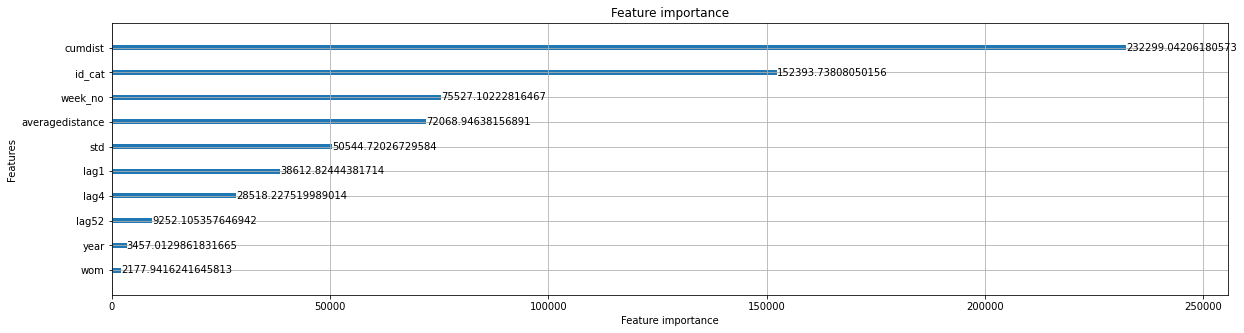

In [58]:
lgb.plot_importance(model,importance_type='gain',figsize=(20,5))

In [59]:
val_x1.head()

,week_no,wom,year,cumdist,averagedistance,std,lag1,lag4,lag52,id_cat
ds,,,,,,,,,,
2011-08-08,32,1,2011,6.0,1.791667,83.487865,-0.597432,-0.597432,-0.375843,1.0
2011-08-15,33,2,2011,7.0,1.791667,83.487865,-0.597432,-0.597432,-0.585454,1.0
2011-08-22,34,3,2011,8.0,1.791667,83.487865,-0.597432,-0.597432,1.390881,1.0
2011-08-29,35,4,2011,9.0,1.791667,83.487865,-0.597432,-0.597432,3.007883,1.0
2011-09-05,36,0,2011,10.0,1.791667,83.487865,-0.597432,-0.597432,0.312880,1.0


In [60]:
val1['forecast'] = model.predict(val_x1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [61]:
train1['forecast'] = model.predict(train_x1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [62]:
train_val = pd.concat([train1,val1],axis=0)

In [63]:
vale = train_val.copy()
vale.head()

,StockCode,Quantity,week_no,wom,year,timeelapsed,cumsum,cumdist,averagedistance,mean,std,tQuantity,lag1,lag4,lag52,forecast
ds,,,,,,,,,,,,,,,,
2010-01-04,10002,451.000000,1,0,2010,1.0,451.000000,0.0,1.791667,49.878299,83.487865,4.804551,-1.000000,-1.000000,-1.0,0.870143
2010-01-11,10002,133.000000,2,1,2010,1.0,584.000000,0.0,1.791667,49.878299,83.487865,0.995614,4.804551,-1.000000,-1.0,0.584455
2010-01-18,10002,32.000000,3,2,2010,1.0,616.000000,0.0,1.791667,49.878299,83.487865,-0.214142,0.995614,-1.000000,-1.0,0.408568
2010-01-25,10002,23.666667,4,3,2010,1.0,639.666667,0.0,1.791667,49.878299,83.487865,-0.313957,-0.214142,-1.000000,-1.0,0.089062
2010-02-01,10002,3.333333,5,0,2010,1.0,643.000000,0.0,1.791667,49.878299,83.487865,-0.557506,-0.313957,4.804551,-1.0,-0.327784


In [64]:
vale['forecast'].max()

6.928453323051319

In [65]:
vale = vale.reset_index()

In [66]:
for lag in range(2,5):
  vale['lag'+str(lag)] = vale.groupby(['StockCode'])['tQuantity'].shift(lag)

In [67]:
val_x1.columns

Index(['week_no', 'wom', 'year', 'cumdist', 'averagedistance', 'std', 'lag1',
       'lag4', 'lag52', 'id_cat'],
      dtype='object')

In [68]:
data.shape

(332273, 16)

In [69]:
def recursive_forecast(val,data,model,id_encoder,forecast_range=7,var='Quantity'):
  dat = val.copy()
  dat1 =data.copy()
  colname= dat.columns.tolist()
  for lag in range(2,5):
    dat['lag'+str(lag)] = dat.groupby(['StockCode'])[var].shift(lag)
  
  dat = dat.groupby(['StockCode'])[colname].tail(1).reset_index()
  da = dat.copy()
  # print(da)
  da_f = pd.DataFrame()  
  for fr in range(1,forecast_range):
    
    da['ds'] = da['ds'] + pd.DateOffset(days=7)
    if fr < 5:
      for i in range(1,5):
        if i == 1:
          da['lag'+str(i)] = dat['forecast'].values
                   
        else:
          da['lag'+str(i+1)] = dat['lag'+str(i)].values
          
        if i == 4:
          datt = da['ds']-pd.to_timedelta(52, unit='w')
          # print(datt)
          dat12 = dat1.loc[dat1['ds'].isin(datt),['StockCode','ds']+[var]]
          # print(dat12)
          dat12 = dat12.rename(columns={var:'lag52'})
          da['ds52'] = datt.values
          da11 = da[['ds52','StockCode']].merge(dat12[['StockCode','ds','lag52']],left_on=['StockCode','ds52'],right_on=['StockCode','ds'],how='left')
          print(da11)

          da['lag52'] = da11['lag52']
                  
          da['id_cat'] = id_encoder.transform(da['StockCode'])
          da1 = da[['week_no', 'wom', 'year', 'timeelapsed', 'cumdist', 'std', 'lag1',
                    'lag4', 'lag52', 'id_cat']]
          da1.fillna(-1,inplace=True)
          
          da.loc[:,'forecast'] = model.predict(da1)
          da['lforecast'] = np.where(da['forecast']*da['std']+da['mean'] < 0,0,da['forecast']*da['std']+da['mean'])
          da['cumsum'] = da.groupby(['StockCode'])['lforecast'].cumsum()
          da['cumdist'] = da.groupby(['StockCode','cumsum'])['timeelapsed'].cumsum()-1 
          da.fillna(-1,inplace=True)
      da_f = pd.concat([da_f,da],axis=0)
    
    else:
      for j in range(1,5):
        if j == 1 :
          da['lag'+str(j)] = da['forecast']
          
        elif j < 5:
          # print(da['lag'+str(j+1)])
          da['lag'+str(j+1)] = da['lag'+str(j)]
        if j == 4:
          datt = da['ds']-pd.to_timedelta(52, unit='w')
          # print(datt,'\n',da['ds'])
          dat12 = dat1.loc[dat1['ds'].isin(datt),['StockCode','ds']+[var]]
          dat12 = dat12.rename(columns={var:'lag52'})
          da['ds52'] =datt.values
          da11 = da[['ds52','StockCode']].merge(dat12[['StockCode','ds','lag52']],left_on=['StockCode','ds52'],right_on=['StockCode','ds'],how='left')
          # da11 = da11.rename(columns={})
          print(da11)
          da['lag52'] = da11['lag52']
          
          # print(da)
          # print(da['lag365'])
          da['id_cat'] = id_encoder.transform(da['StockCode'])
          da1 = da[['week_no', 'wom', 'year', 'timeelapsed', 'cumdist', 'std', 'lag1',
                    'lag4', 'lag52', 'id_cat']]
          da1.fillna(-1,inplace=True)
          # print(da1)
          # print(da1.head())
          da.loc[:,'forecast'] = model.predict(da1)
          da['lforecast'] = np.where(da['forecast']*da['std']+da['mean'] < 0,0,da['forecast']*da['std']+da['mean'])
          da['cumsum'] = da.groupby(['StockCode'])['lforecast'].cumsum()
          da['cumdist'] = da.groupby(['StockCode','cumsum'])['timeelapsed'].cumsum()-1
          da.fillna(-1,inplace=True)
          
      da_f = pd.concat([da_f,da],axis=0)
  return da_f
 

In [70]:
(pd.to_datetime('2011-09-12') + pd.DateOffset(days=7))-pd.to_timedelta(52, unit='w')

Timestamp('2010-09-20 00:00:00')

In [71]:
data1.min()

StockCode                        10002
Quantity                             0
week_no                              1
wom                                  0
year                              2010
ds                 2010-01-04 00:00:00
timeelapsed                          1
cumsum                               0
cumdist                              0
averagedistance                      0
mean                         0.0520833
std                           0.223361
tQuantity                     -1.89607
dtype: object

In [72]:
data.loc[data['ds']<'2010-09-20']

,StockCode,Quantity,week_no,wom,year,ds,timeelapsed,cumsum,cumdist,averagedistance,mean,std,tQuantity,lag1,lag4,lag52
0,10002,451.000000,1,0,2010,2010-01-04,1.0,451.000000,0.0,1.791667,49.878299,83.487865,4.804551,-1.000000,-1.000000,-1.0
1,10002,133.000000,2,1,2010,2010-01-11,1.0,584.000000,0.0,1.791667,49.878299,83.487865,0.995614,4.804551,-1.000000,-1.0
2,10002,32.000000,3,2,2010,2010-01-18,1.0,616.000000,0.0,1.791667,49.878299,83.487865,-0.214142,0.995614,-1.000000,-1.0
3,10002,23.666667,4,3,2010,2010-01-25,1.0,639.666667,0.0,1.791667,49.878299,83.487865,-0.313957,-0.214142,-1.000000,-1.0
4,10002,3.333333,5,0,2010,2010-02-01,1.0,643.000000,0.0,1.791667,49.878299,83.487865,-0.557506,-0.313957,4.804551,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
332209,gift_0001_50,0.000000,33,2,2010,2010-08-16,1.0,4.000000,6.0,8.583333,0.187500,1.079108,-0.173755,-0.173755,-0.173755,-1.0
332210,gift_0001_50,0.000000,34,3,2010,2010-08-23,1.0,4.000000,7.0,8.583333,0.187500,1.079108,-0.173755,-0.173755,-0.173755,-1.0
332211,gift_0001_50,0.000000,35,4,2010,2010-08-30,1.0,4.000000,8.0,8.583333,0.187500,1.079108,-0.173755,-0.173755,-0.173755,-1.0
332212,gift_0001_50,10.000000,36,0,2010,2010-09-06,1.0,14.000000,0.0,8.583333,0.187500,1.079108,9.093160,-0.173755,-0.173755,-1.0


In [73]:
fr = recursive_forecast(vale,data1,model,id_encoder,8,'tQuantity')

           ds52     StockCode         ds     lag52
0    2010-09-20         10002 2010-09-20  0.181125
1    2010-09-20         10080 2010-09-20 -0.283012
2    2010-09-20         10120 2010-09-20 -0.424274
3    2010-09-20        10123C 2010-09-20 -0.207974
4    2010-09-20        10124A 2010-09-20  0.198228
...         ...           ...        ...       ...
3764 2010-09-20          POST 2010-09-20 -0.265631
3765 2010-09-20  gift_0001_10 2010-09-20  0.300784
3766 2010-09-20  gift_0001_20 2010-09-20 -0.319954
3767 2010-09-20  gift_0001_30 2010-09-20  0.213147
3768 2010-09-20  gift_0001_50 2010-09-20 -0.173755

[3769 rows x 4 columns]
           ds52     StockCode         ds     lag52
0    2010-09-27         10002 2010-09-27 -0.297987
1    2010-09-27         10080 2010-09-27 -0.283012
2    2010-09-27         10120 2010-09-27 -0.424274
3    2010-09-27        10123C 2010-09-27  9.375452
4    2010-09-27        10124A 2010-09-27 -0.176505
...         ...           ...        ...       ...
3764 2

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4327: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4327: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4327: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4327: SettingWithCopyWarning:


A value is 

           ds52     StockCode         ds     lag52
0    2010-10-18         10002 2010-10-18 -0.178209
1    2010-10-18         10080 2010-10-18 -0.283012
2    2010-10-18         10120 2010-10-18 -0.424274
3    2010-10-18        10123C 2010-10-18 -0.141422
4    2010-10-18        10124A 2010-10-18  0.198228
...         ...           ...        ...       ...
3764 2010-10-18          POST 2010-10-18 -0.158842
3765 2010-10-18  gift_0001_10 2010-10-18 -0.184514
3766 2010-10-18  gift_0001_20 2010-10-18 -0.319954
3767 2010-10-18  gift_0001_30 2010-10-18  0.213147
3768 2010-10-18  gift_0001_50 2010-10-18 -0.173755

[3769 rows x 4 columns]
           ds52     StockCode         ds     lag52
0    2010-10-25         10002 2010-10-25 -0.262054
1    2010-10-25         10080 2010-10-25 -0.283012
2    2010-10-25         10120 2010-10-25  0.618876
3    2010-10-25        10123C 2010-10-25 -0.141422
4    2010-10-25        10124A 2010-10-25 -0.176505
...         ...           ...        ...       ...
3764 2

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4327: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4327: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4327: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [74]:
fr.isnull().sum()

index              0
ds                 0
StockCode          0
Quantity           0
week_no            0
wom                0
year               0
timeelapsed        0
cumsum             0
cumdist            0
averagedistance    0
mean               0
std                0
tQuantity          0
lag1               0
lag4               0
lag52              0
forecast           0
lag2               0
lag3               0
lag5               0
ds52               0
id_cat             0
lforecast          0
dtype: int64

In [75]:
test = test.reset_index()

In [77]:
# train_val.loc[train_val['StockCode'].isin(t3.loc[t3['error'].isnull(),'StockCode']),]

In [78]:
test.isnull().sum()

ds                 0
StockCode          0
Quantity           0
week_no            0
wom                0
year               0
timeelapsed        0
cumsum             0
cumdist            0
averagedistance    0
mean               0
std                0
tQuantity          0
lag1               0
lag4               0
lag52              0
dtype: int64

In [79]:
test1 = test.merge(fr[['StockCode','ds','lforecast']],on=['StockCode','ds'],how='left')
# test1['forecast'] = test1['forecast']*test1['std'] + test1['mean']
test1['error'] = np.abs(test1['Quantity']-test1['lforecast'])/(test1['Quantity']+1)
t2 = test1.loc[test1['Quantity']>0,]
t = test1.groupby('StockCode')['error'].mean().reset_index()

In [80]:
test1.isnull().sum()

ds                  0
StockCode           0
Quantity            0
week_no             0
wom                 0
year                0
timeelapsed         0
cumsum              0
cumdist             0
averagedistance     0
mean                0
std                 0
tQuantity           0
lag1                0
lag4                0
lag52               0
lforecast          94
error              94
dtype: int64

In [81]:
t = t.sort_values(by=['error'])

In [82]:
t.groupby(['StockCode'])['error'].mean().mean()

0.4797829792859121

In [83]:
t.sort_values(by=['error'])

,StockCode,error
3796,gift_0001_50,0.0
3724,90195B,0.0
3725,90196A,0.0
2569,37503,0.0
2568,37502,0.0
...,...,...
2439,23565,NaN
2440,23566,NaN
2441,23568,NaN
2442,23570,NaN


In [84]:
t3  = t2.groupby('StockCode')['error'].mean().reset_index()

In [85]:
t2.groupby(['StockCode'])['error'].mean().mean()

0.7663305461824588

In [86]:
stock_cont = data1.groupby(['StockCode'])['Quantity'].sum()/data1['Quantity'].sum()

In [88]:
t3 = t3.merge(stock_cont,on=['StockCode'],how='left')

In [89]:
t3.sort_values(by=['Quantity'],ascending=False)

,StockCode,error,Quantity
2489,84077,0.655303,0.010167
62,17003,0.861182,0.008724
362,21212,0.583635,0.006711
1227,22492,0.666786,0.005409
2566,84568,0.942905,0.004977
...,...,...,...
2946,90039B,0.500000,0.000002
2914,90001C,0.500000,0.000002
2915,90001D,0.500000,0.000002
3097,90214Y,0.500000,0.000002


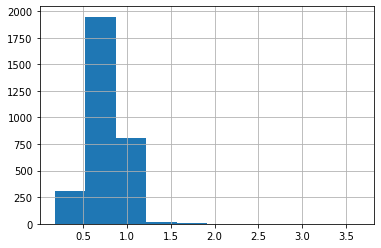

In [90]:
t3['error'].hist()

In [ ]:
t3.loc[t3['error'].isnull(),'StockCode']

2053    23382
2104    23451
2105    23452
2106    23454
2107    23455
2108    23456
2109    23460
2111    23462
2117    23480
2120    23485
2121    23486
2122    23487
2123    23489
2124    23490
2125    23491
2128    23499
2178    23553
2179    23554
2180    23555
2181    23556
2182    23557
2183    23558
2185    23564
2186    23565
2187    23566
2188    23568
2189    23570
2190    23571
Name: StockCode, dtype: object

In [ ]:
test1.loc[test1['StockCode'].isin(t3.loc[t3['error'].isnull(),'StockCode']),'lforecast'] = test1.loc[test1['StockCode'].isin(t3.loc[t3['error'].isnull(),'StockCode']),'lforecast']

In [ ]:
# len(t3[t3 <.2])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning

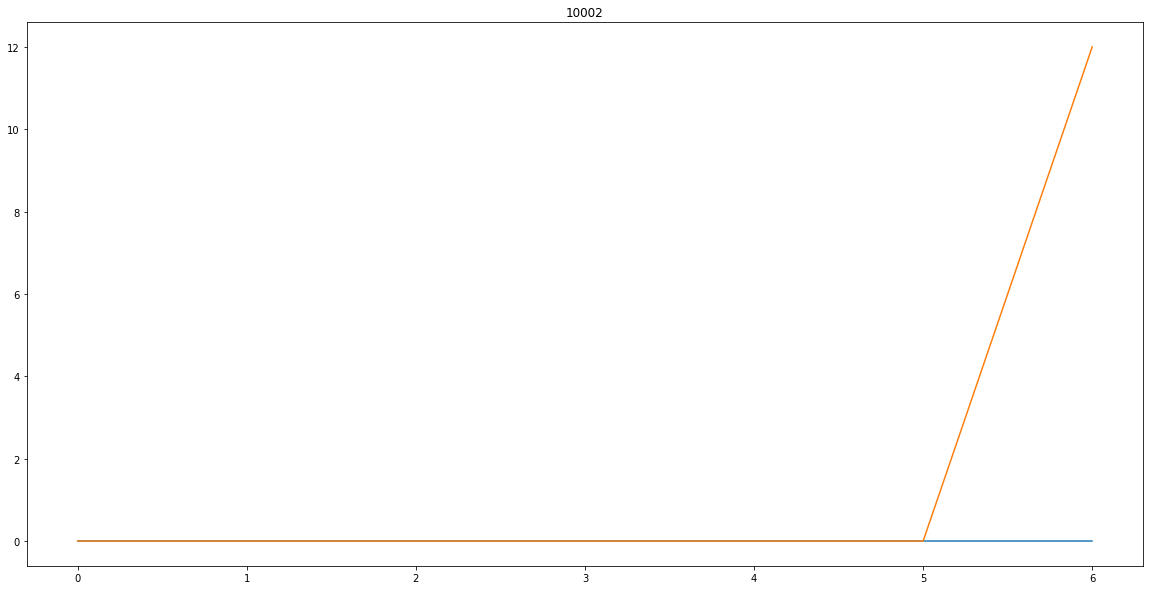

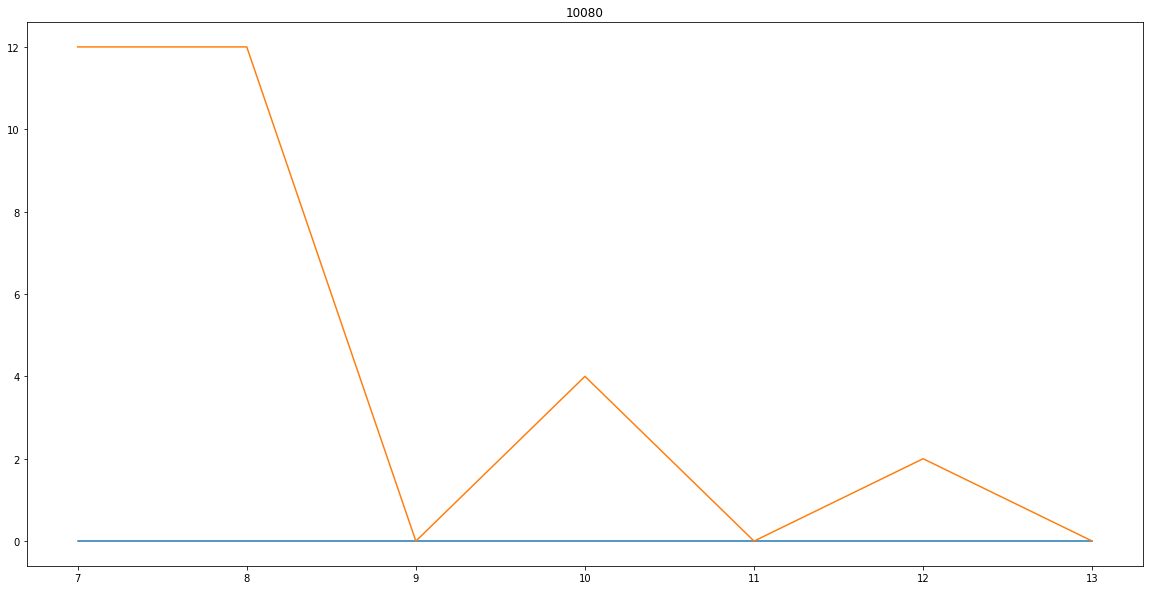

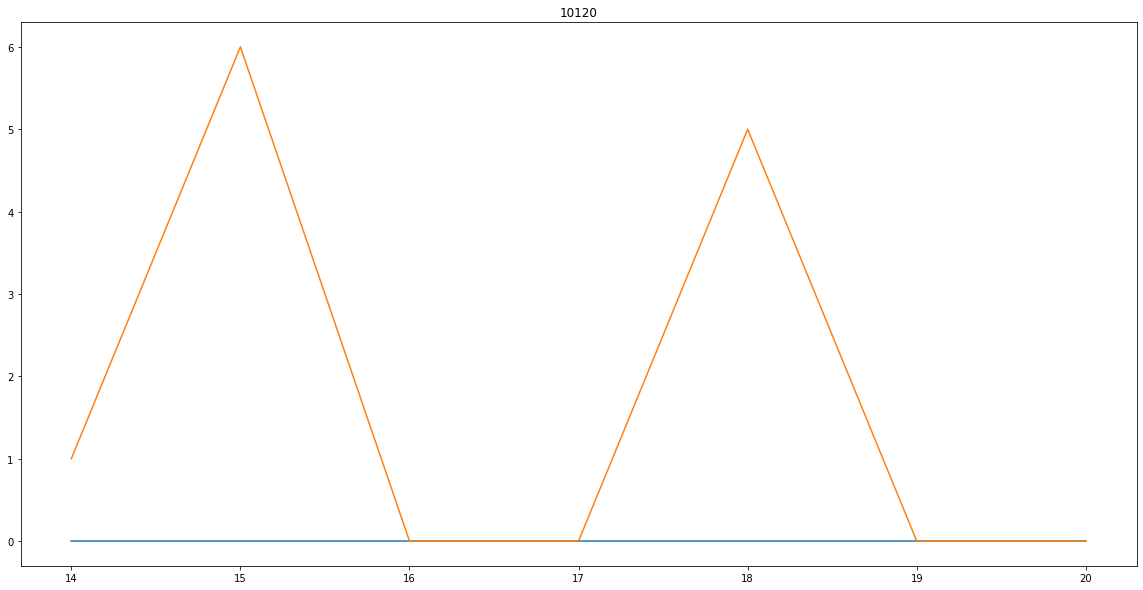

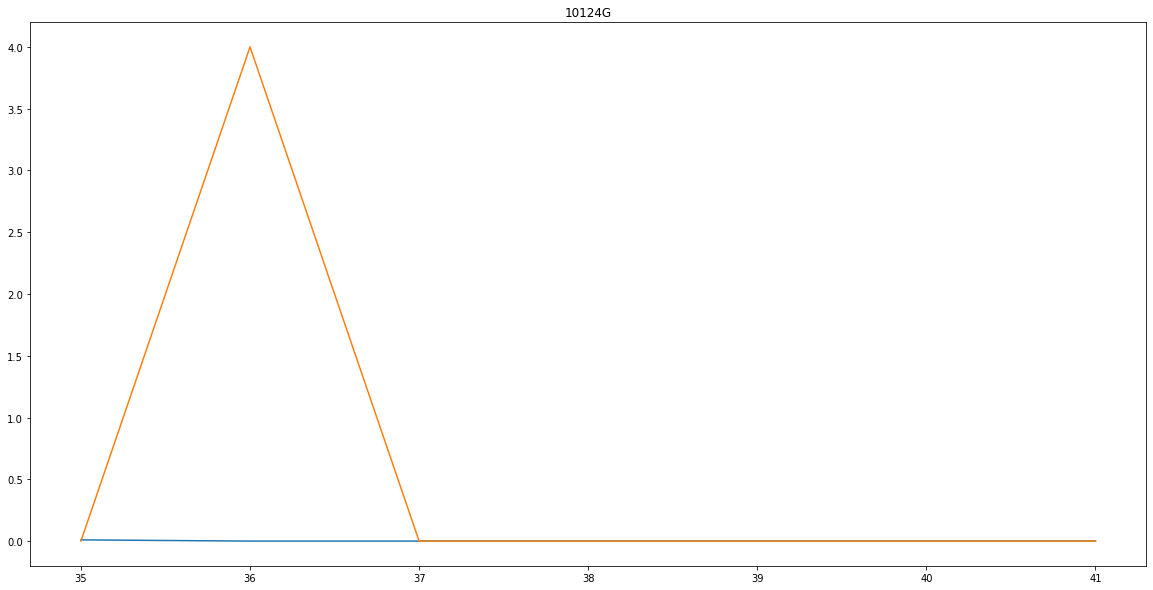

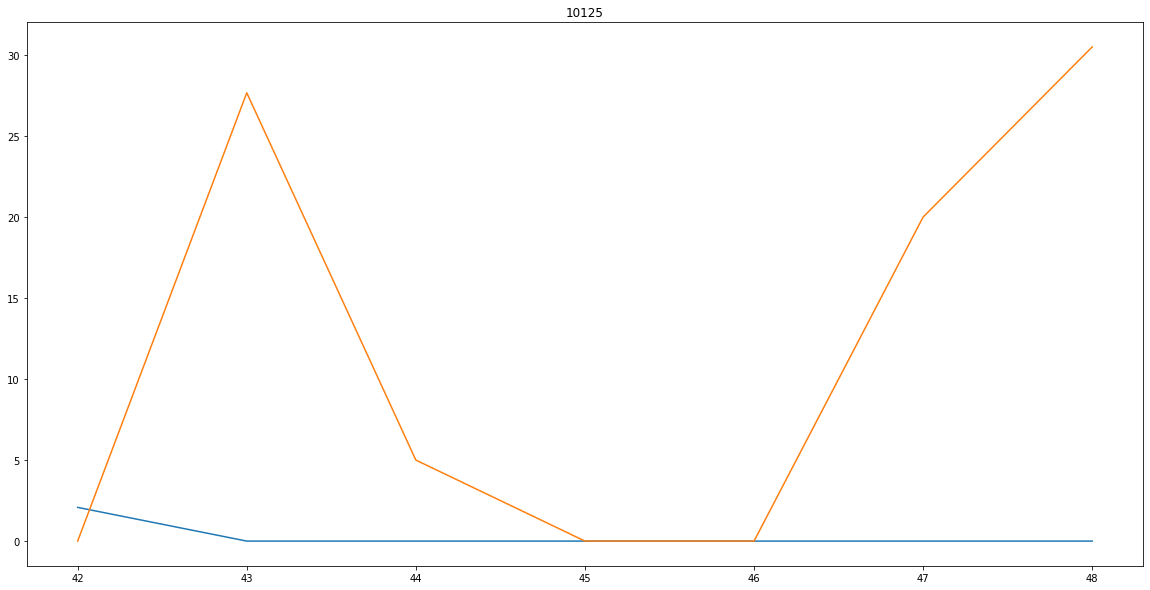

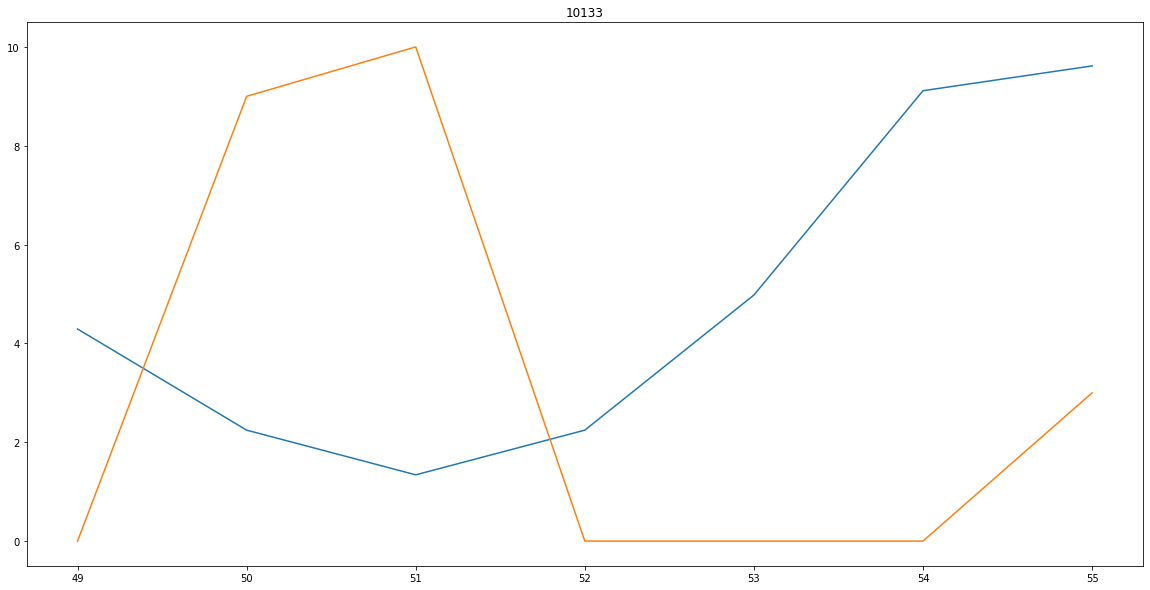

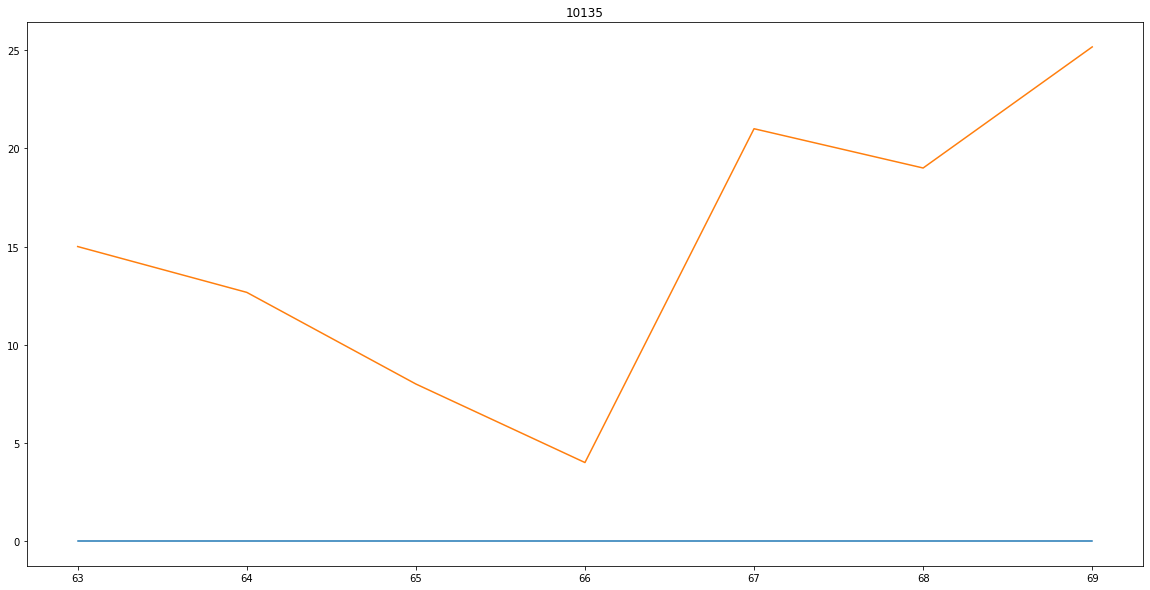

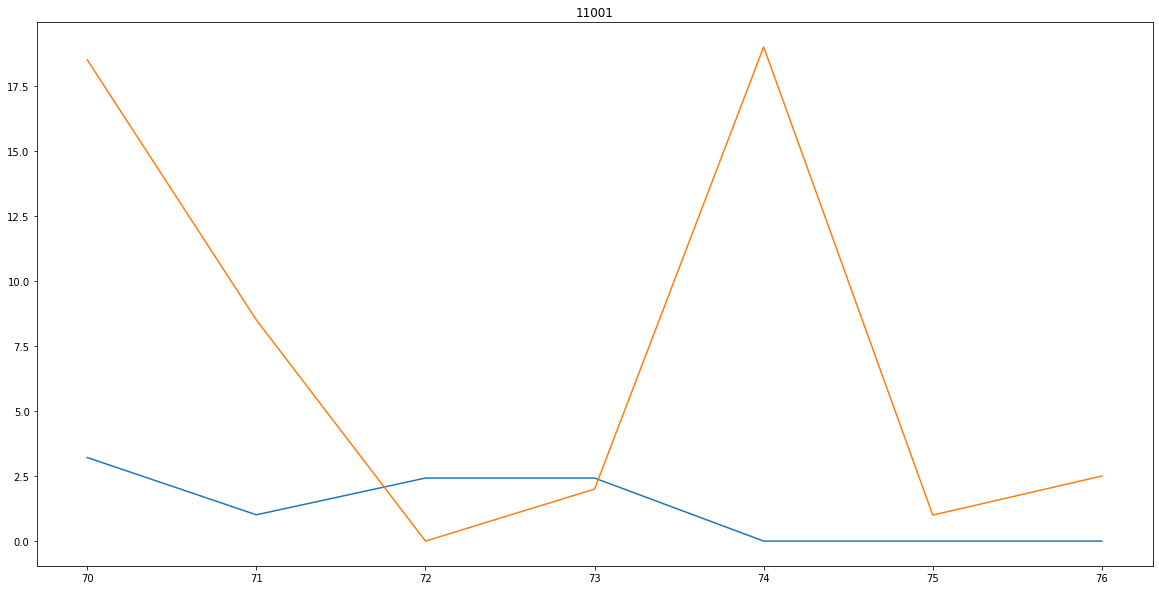

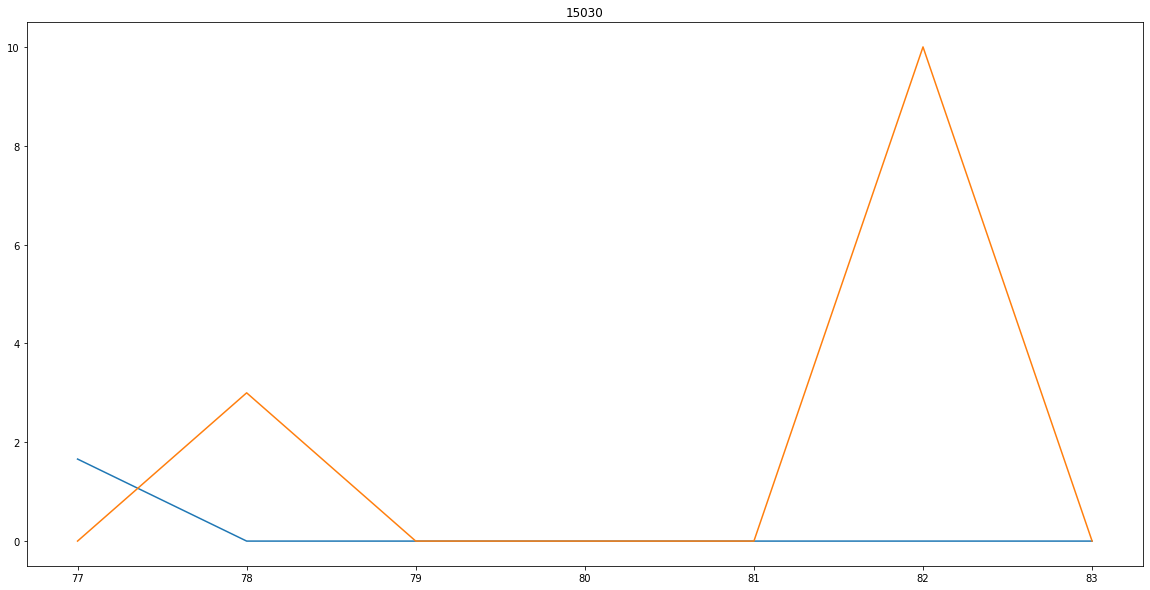

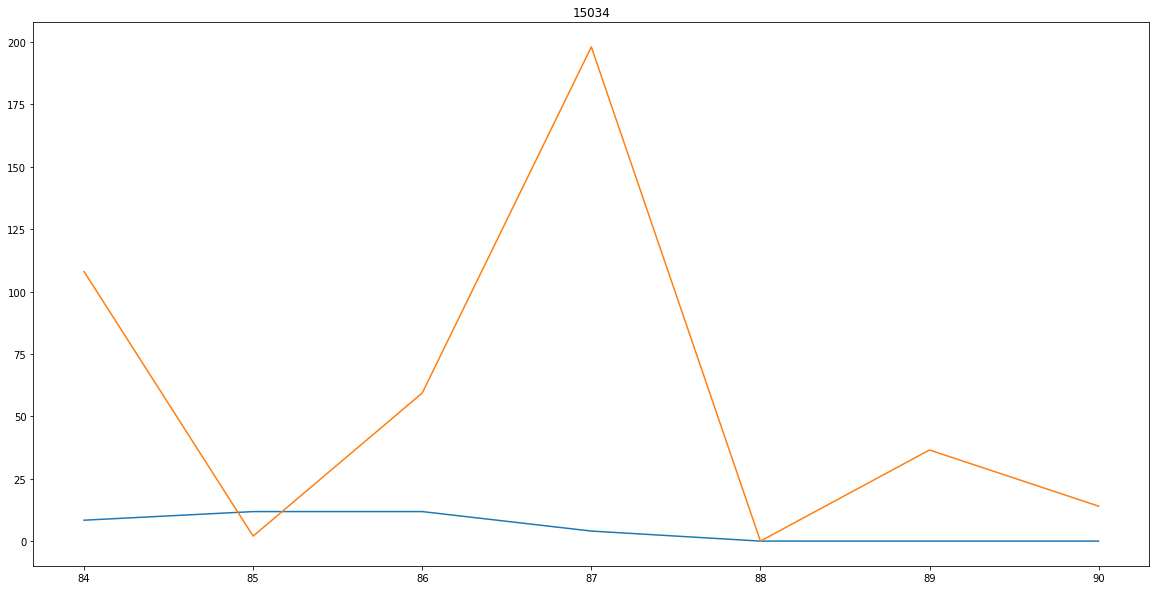

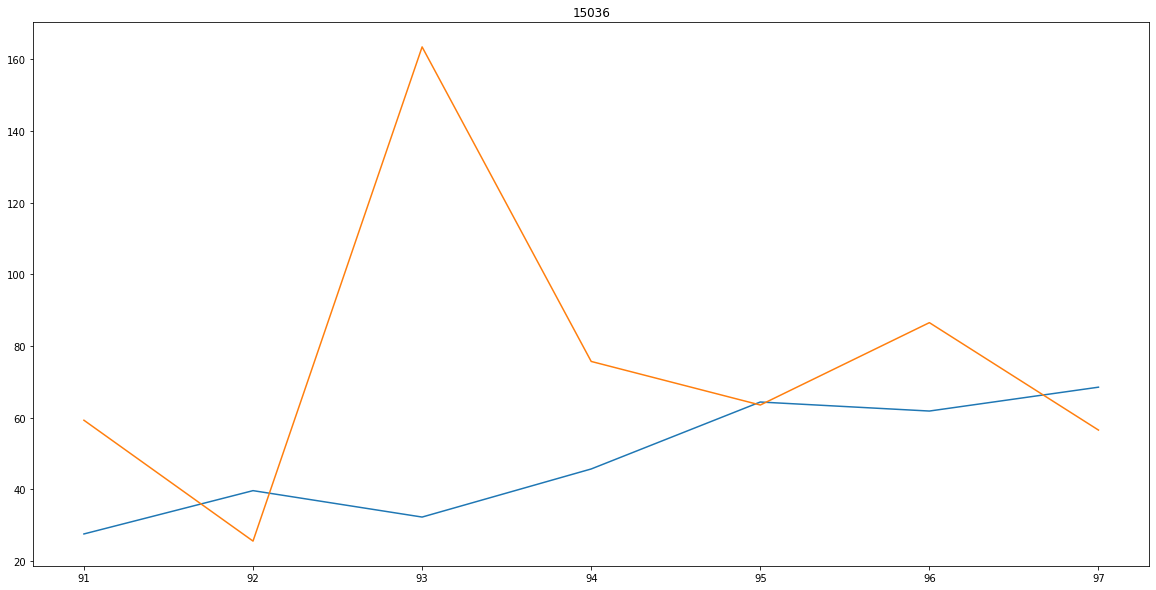

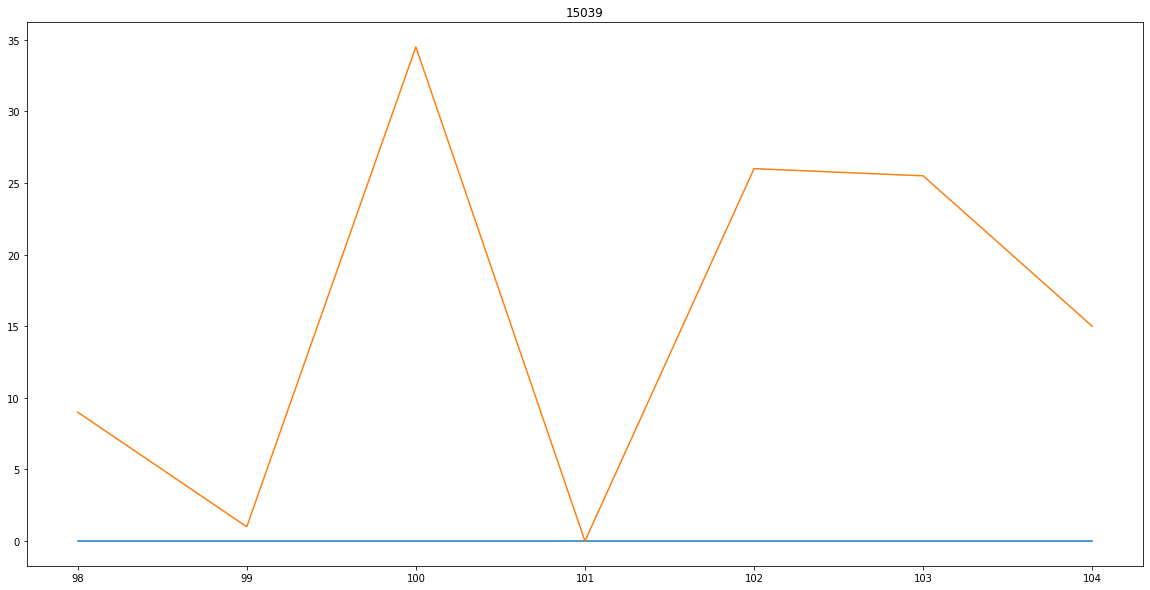

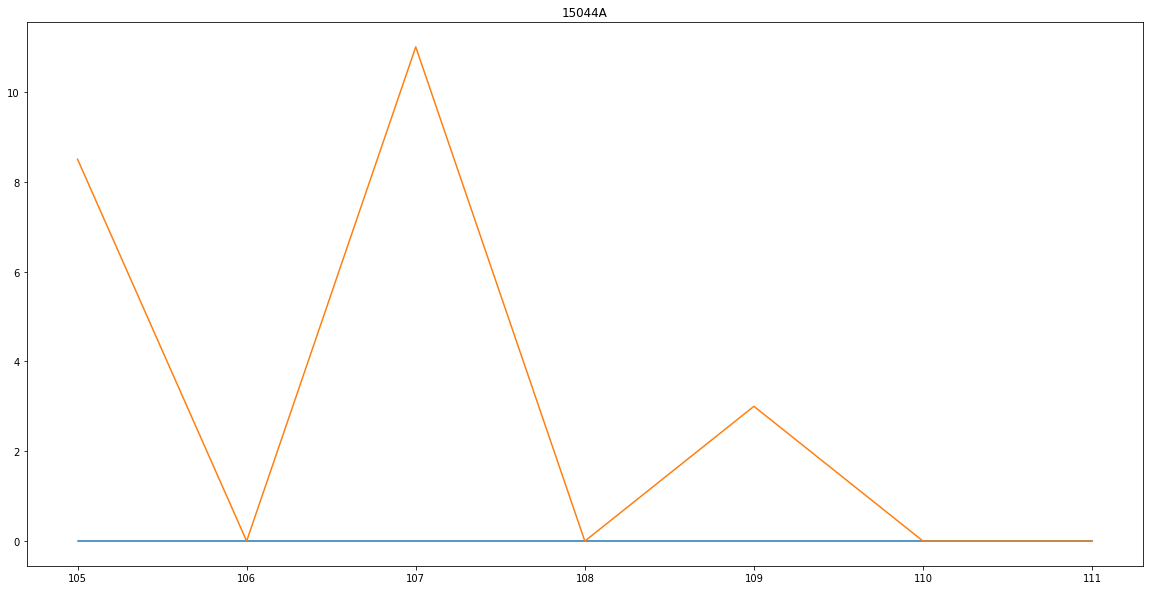

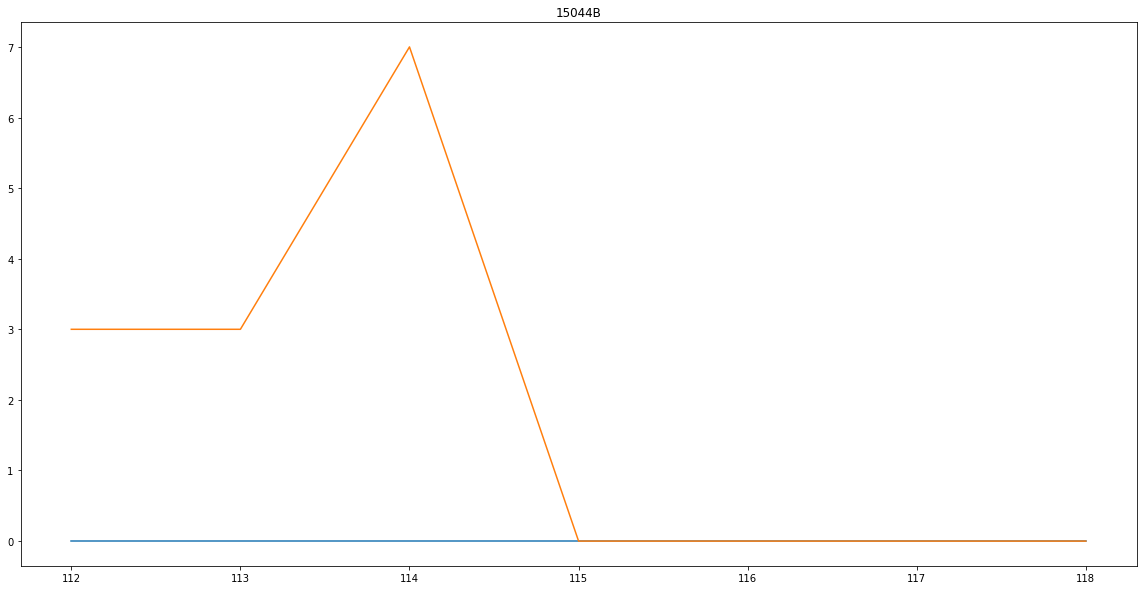

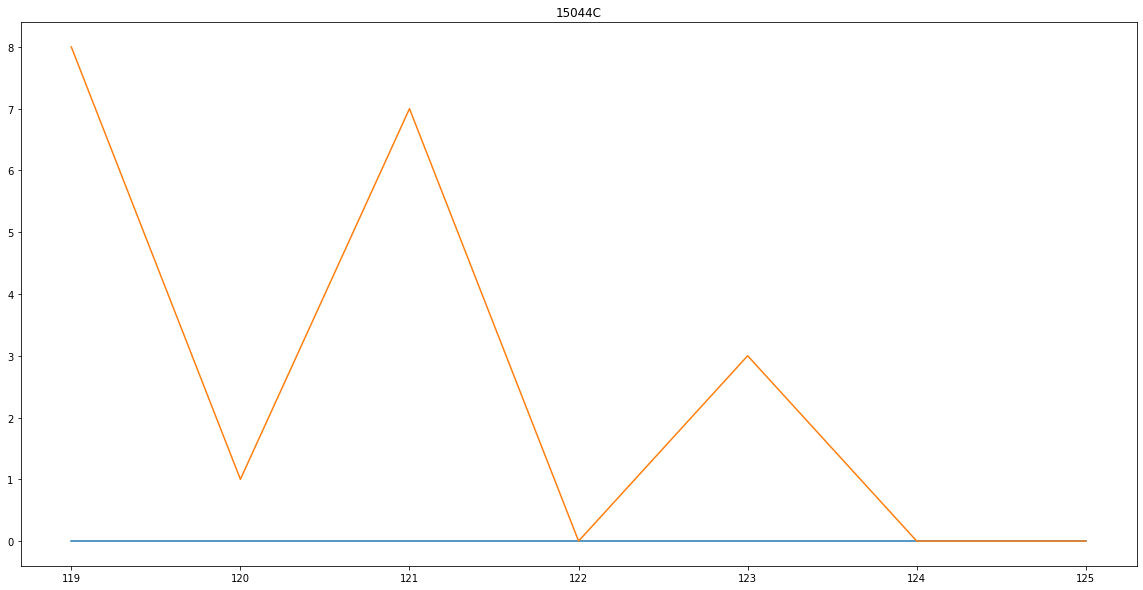

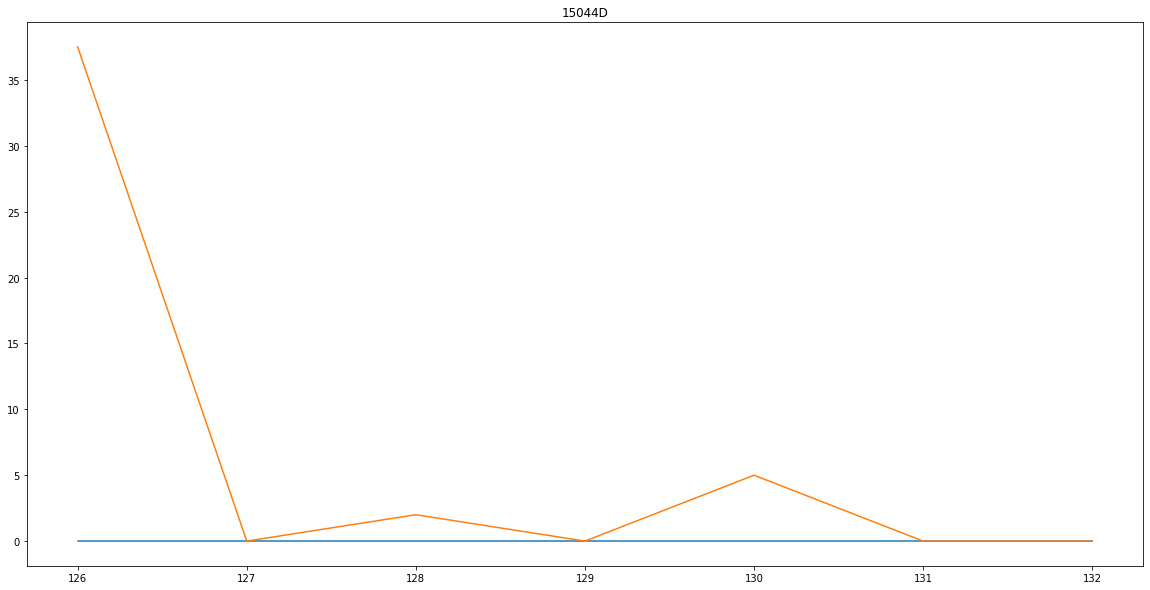

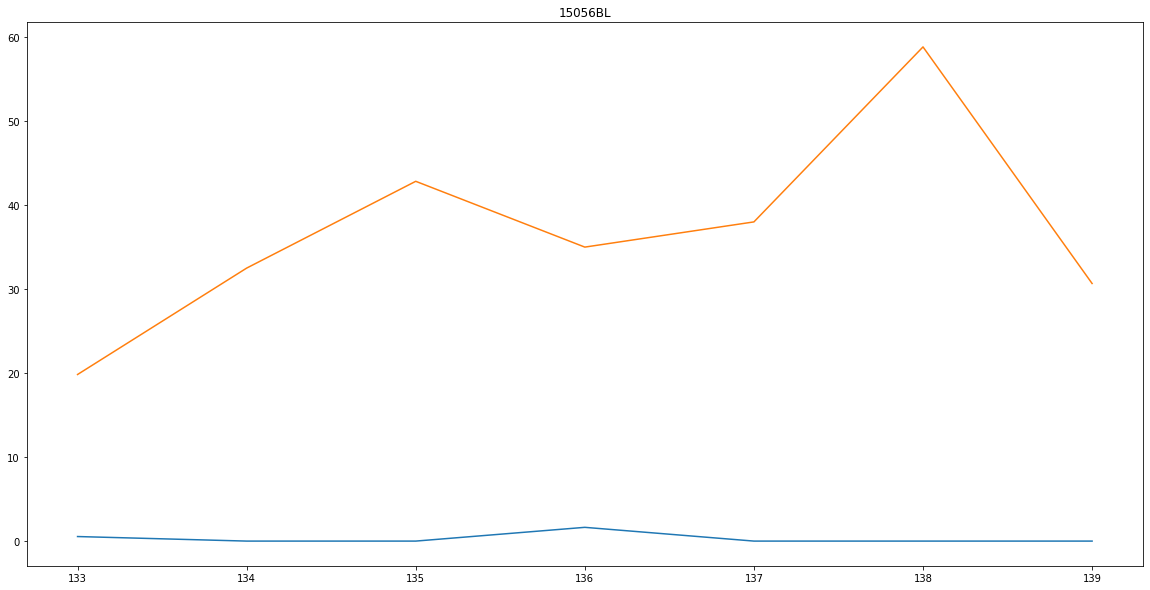

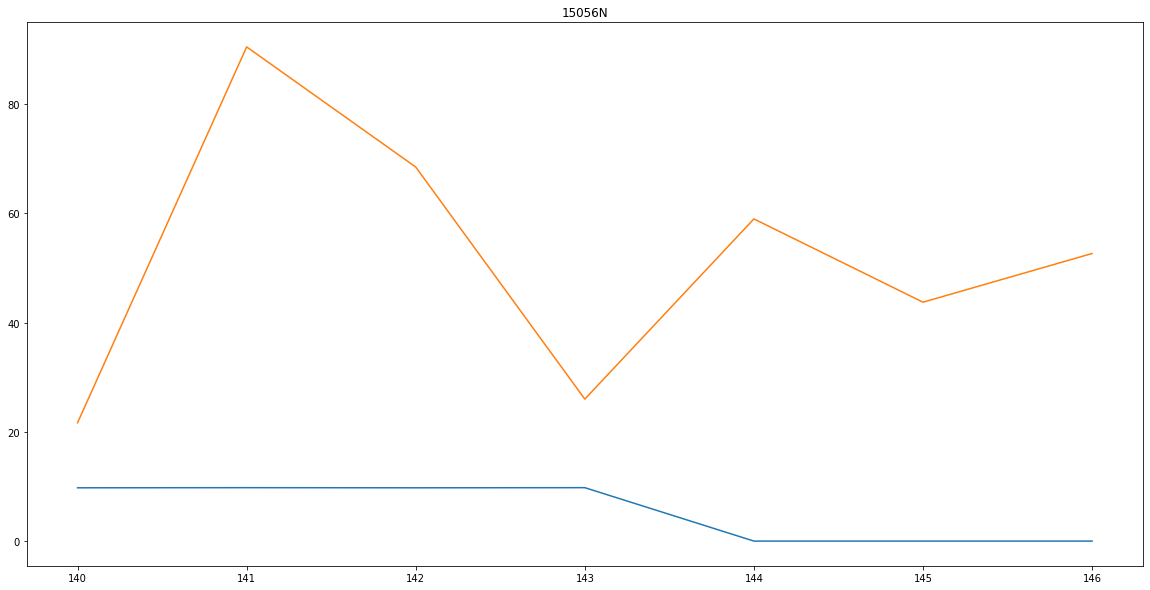

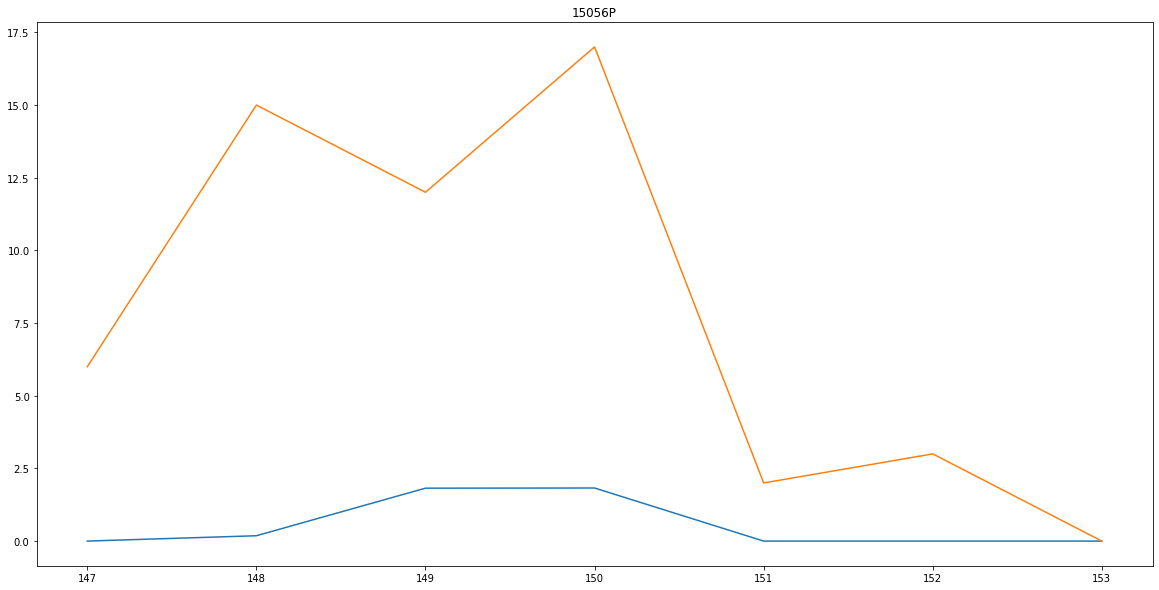

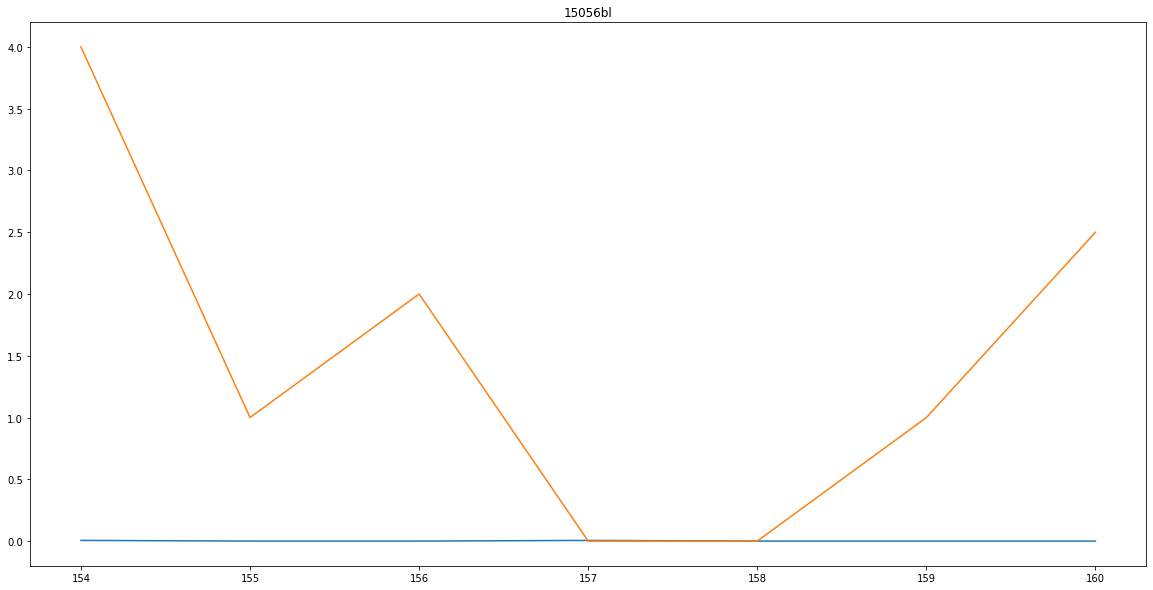

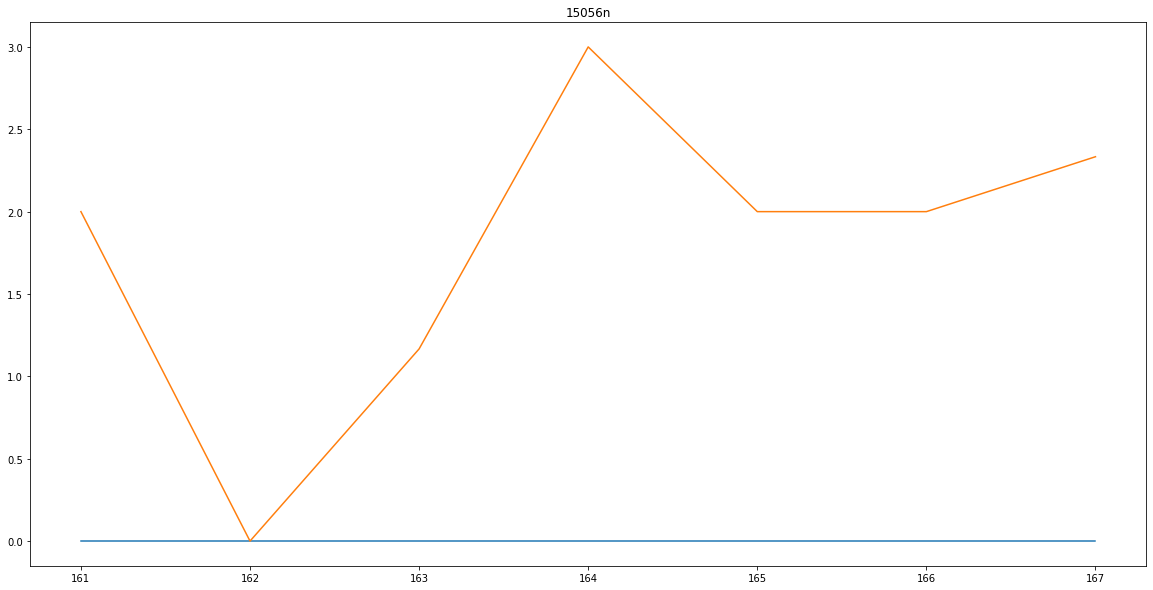

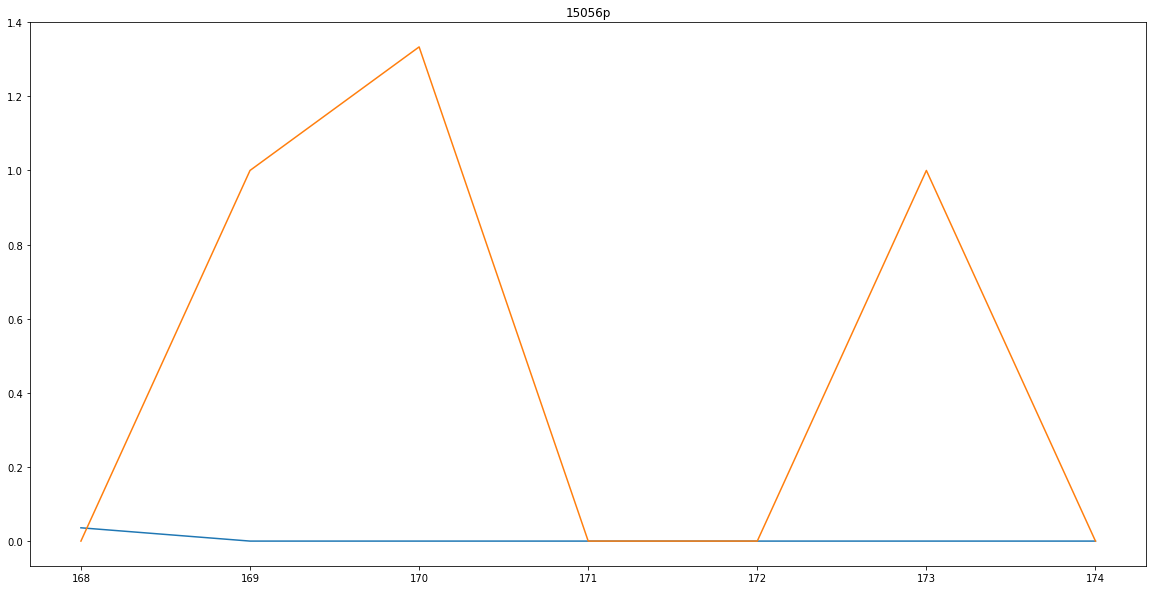

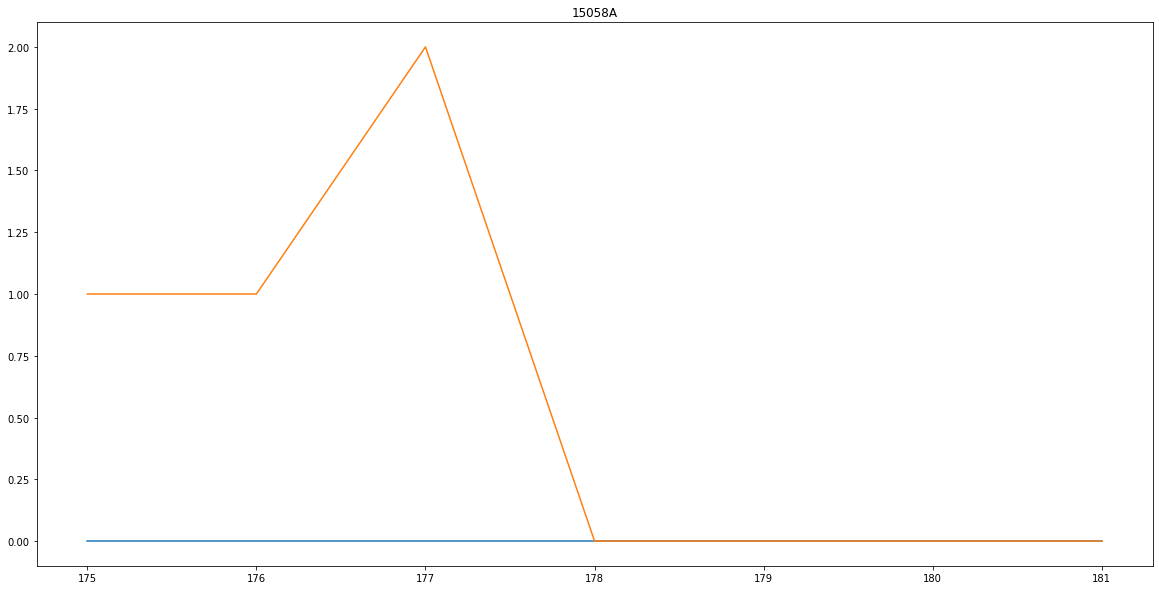

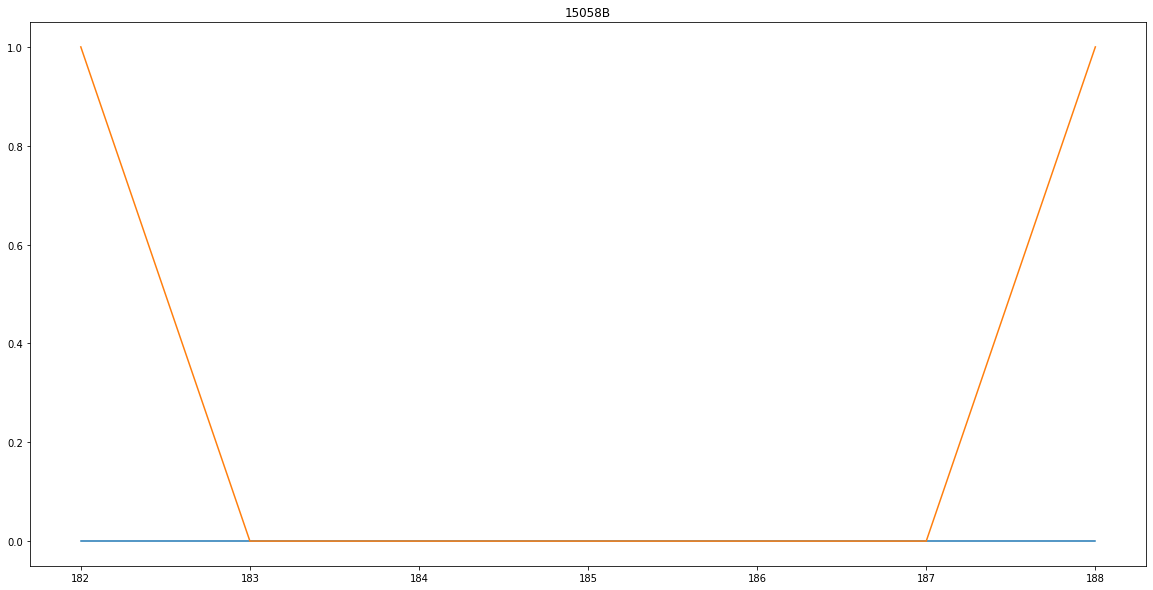

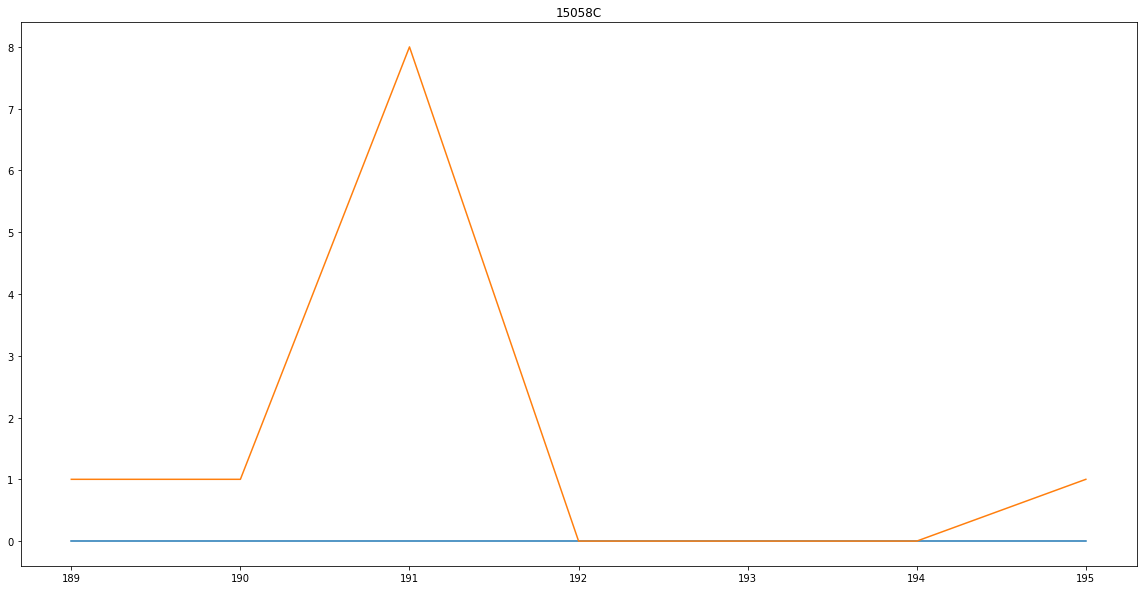

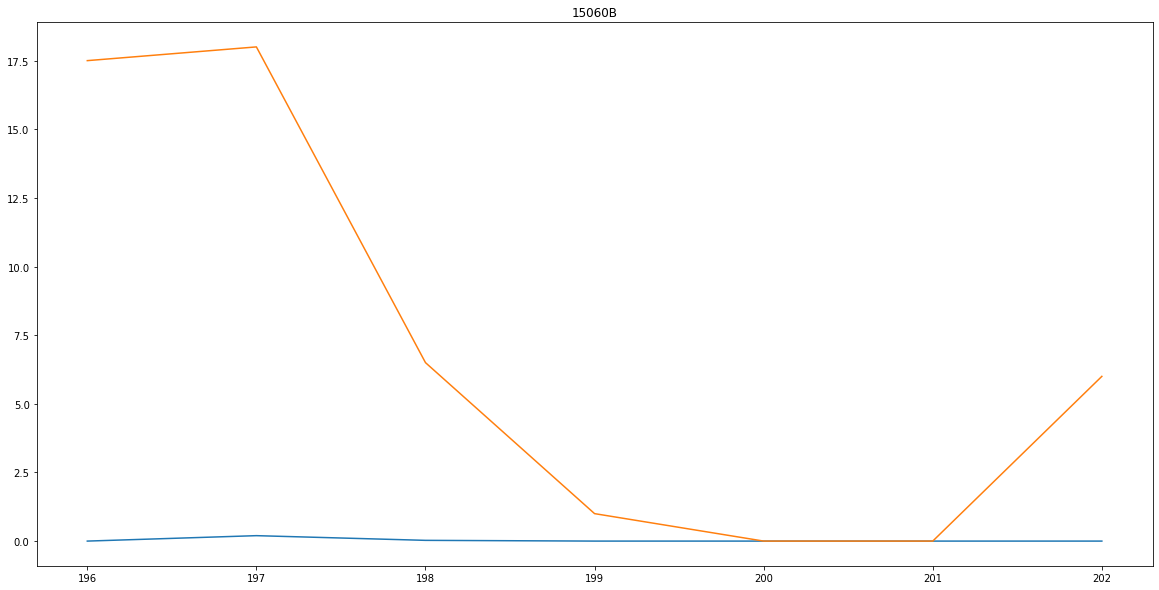

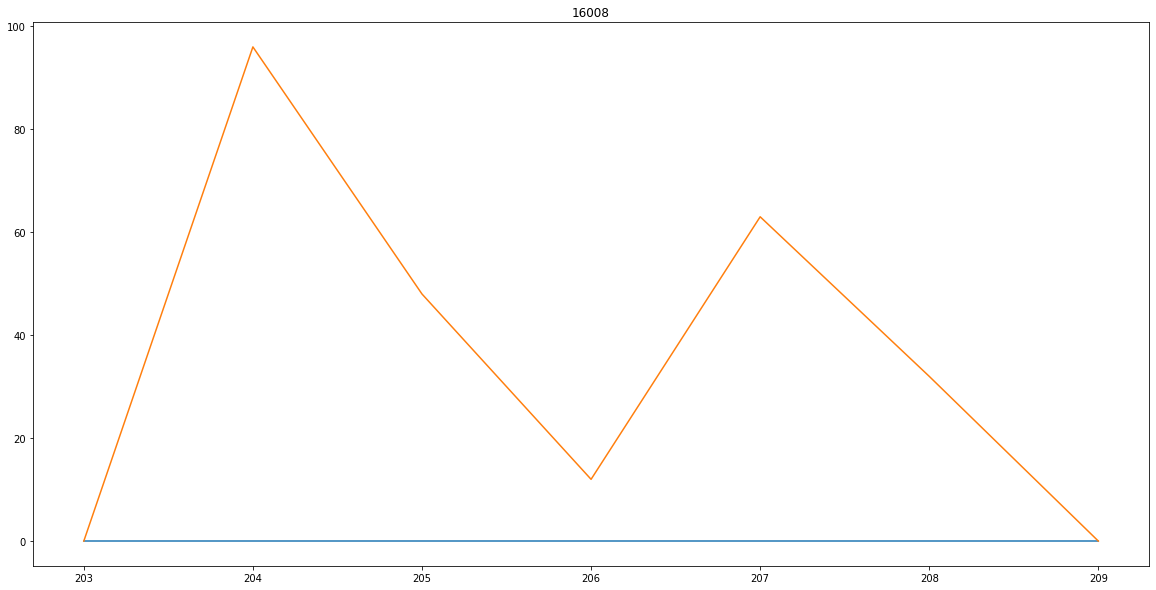

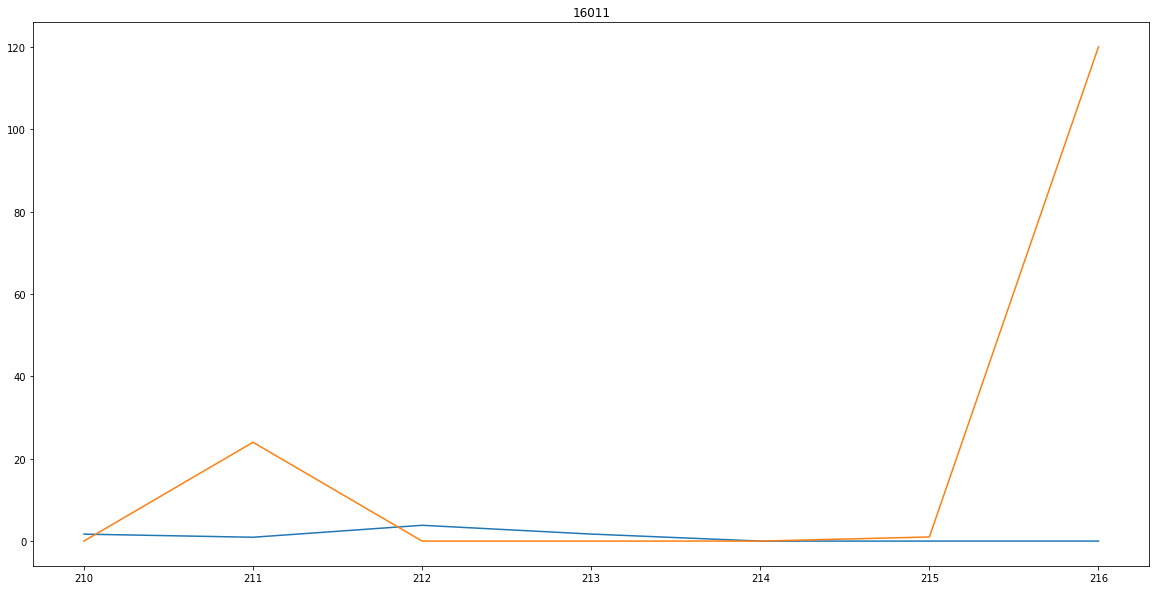

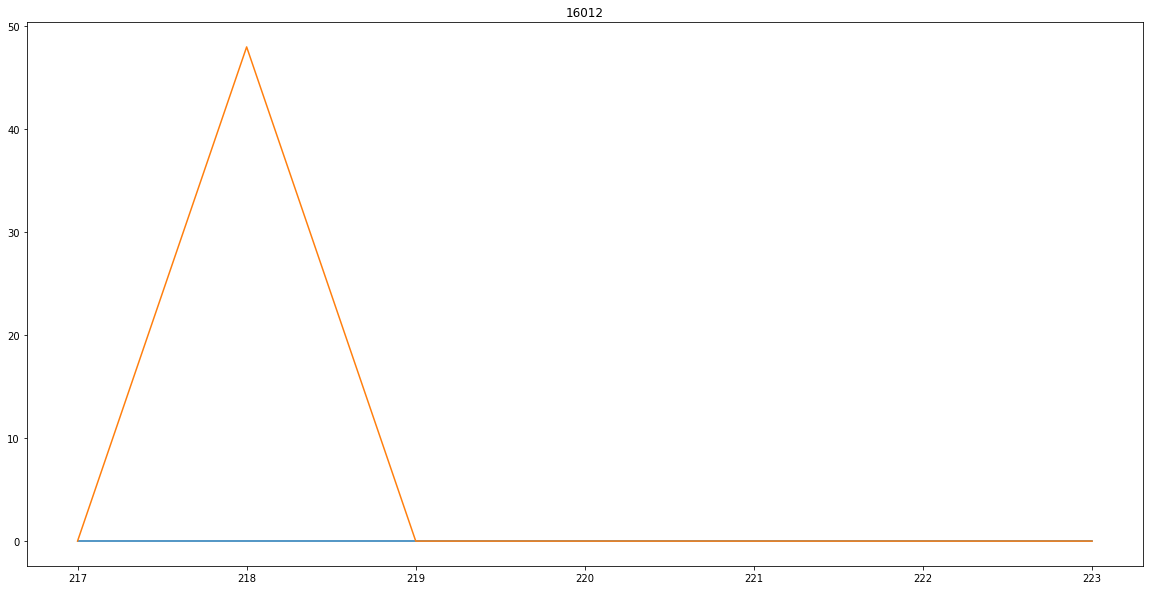

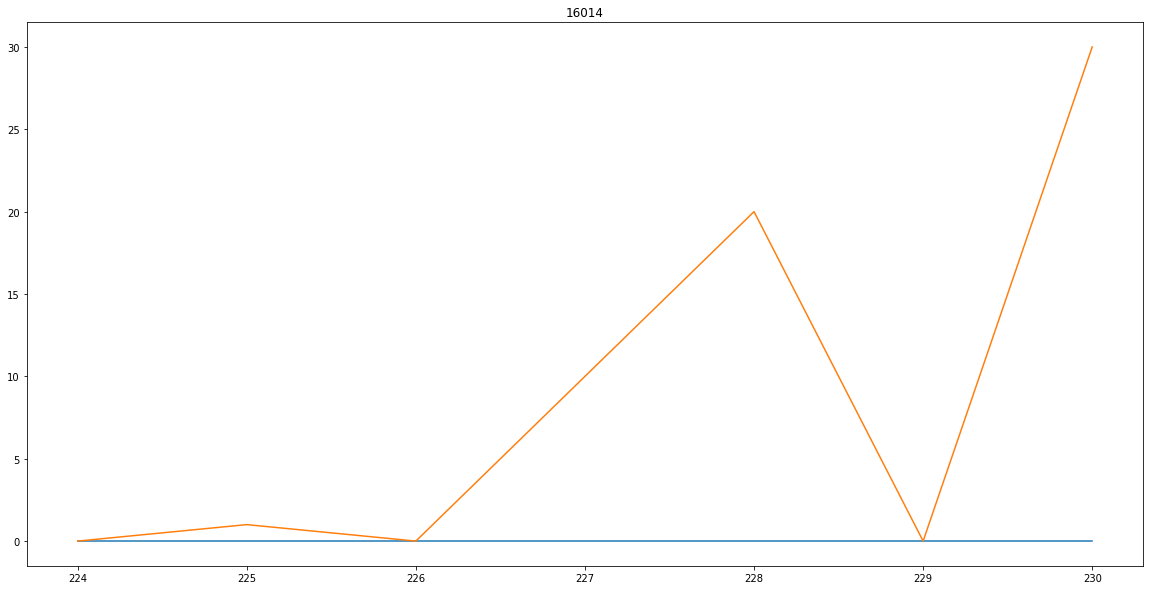

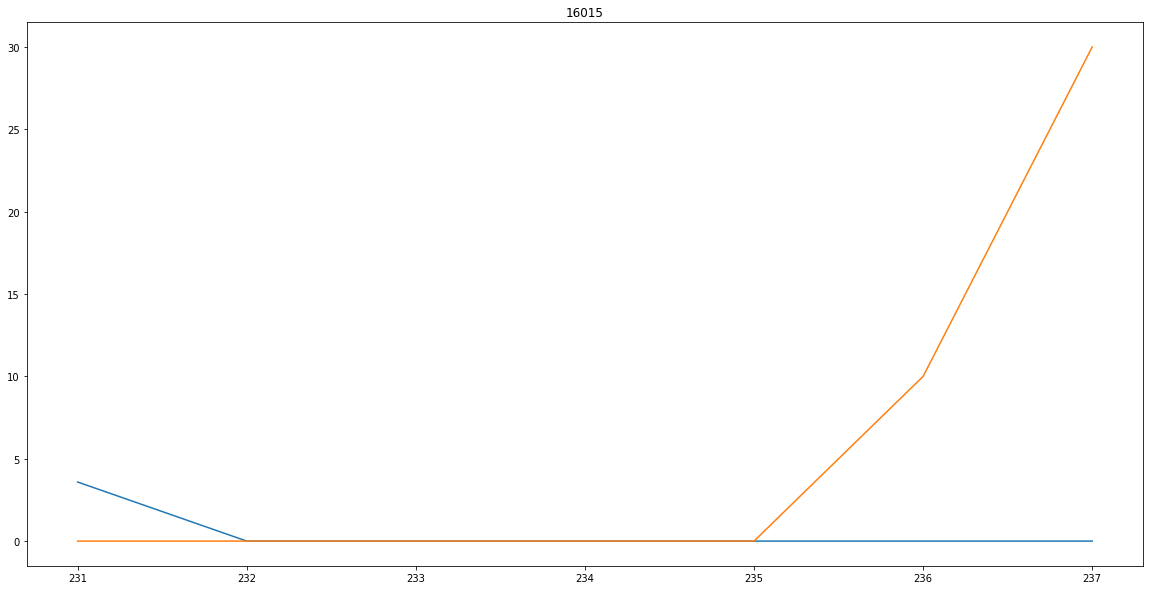

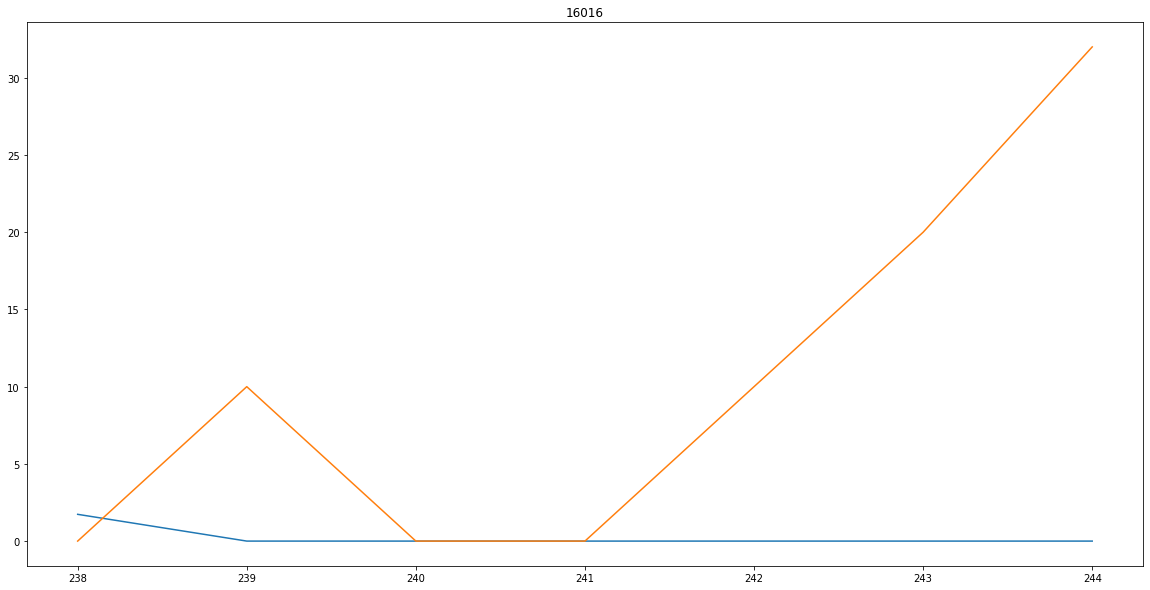

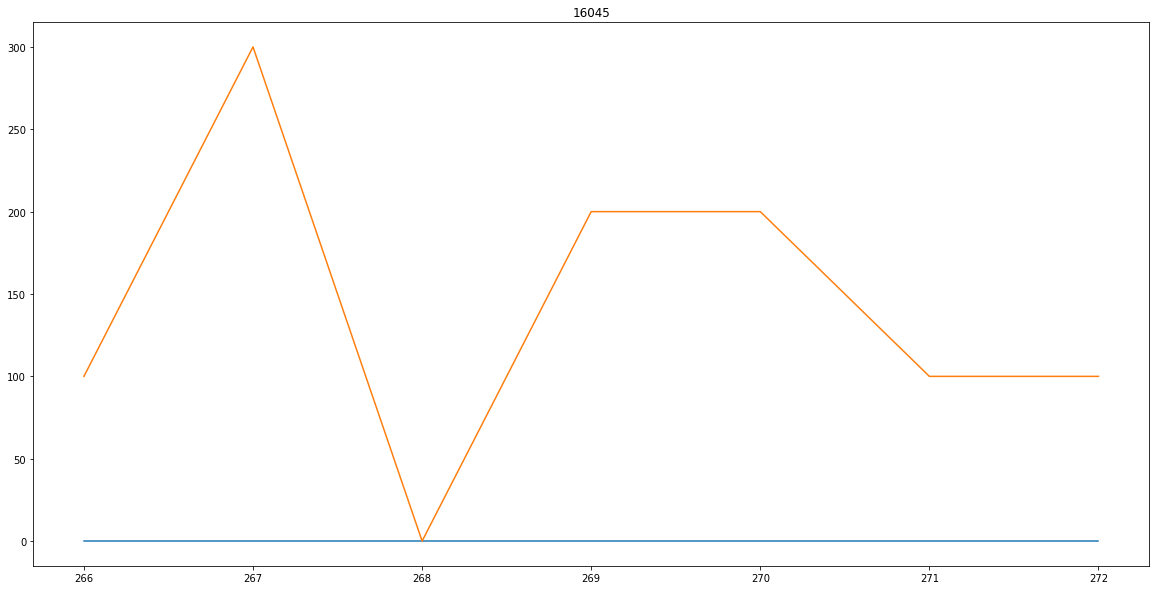

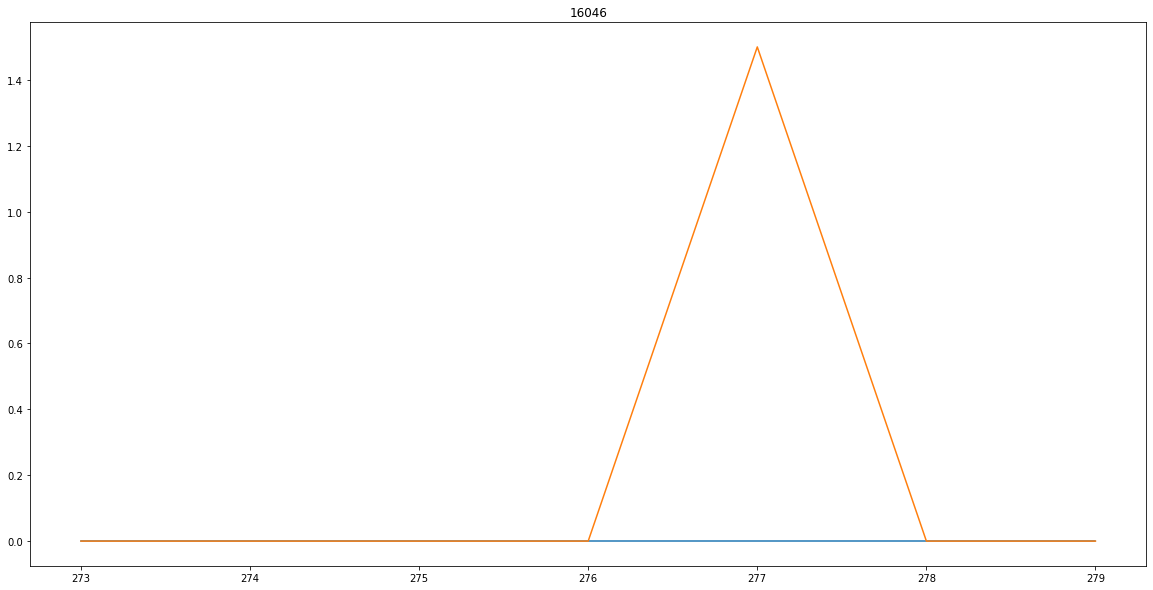

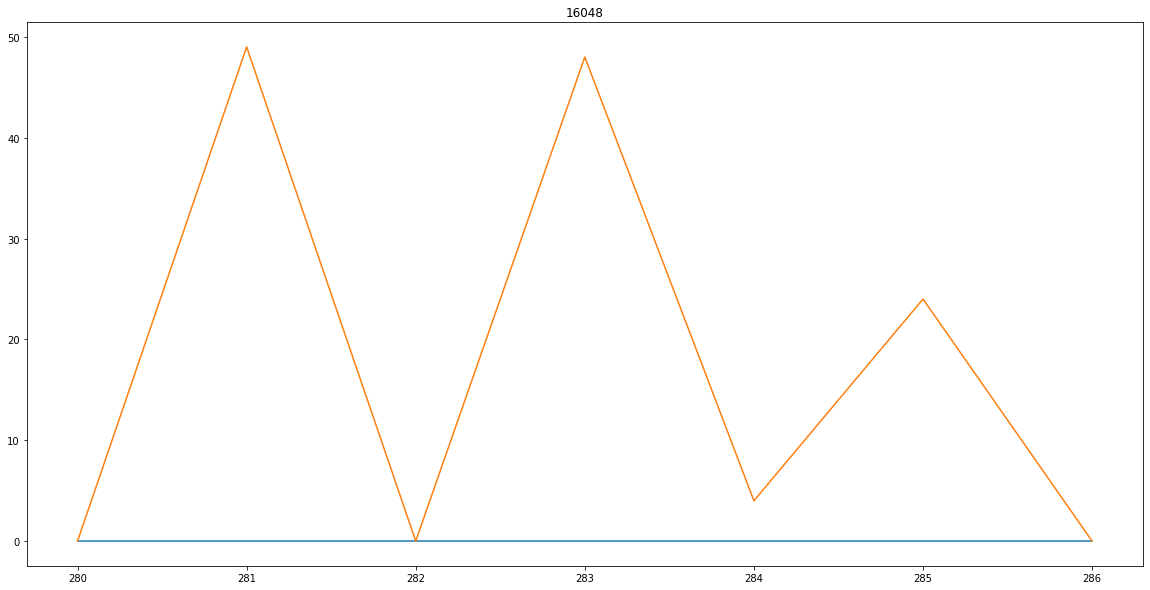

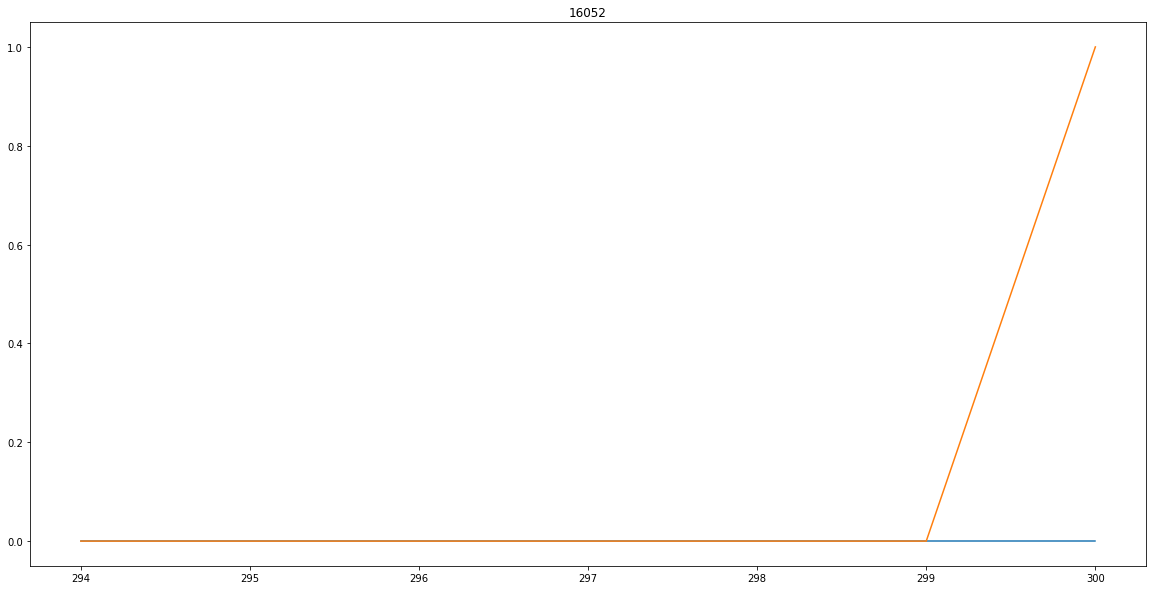

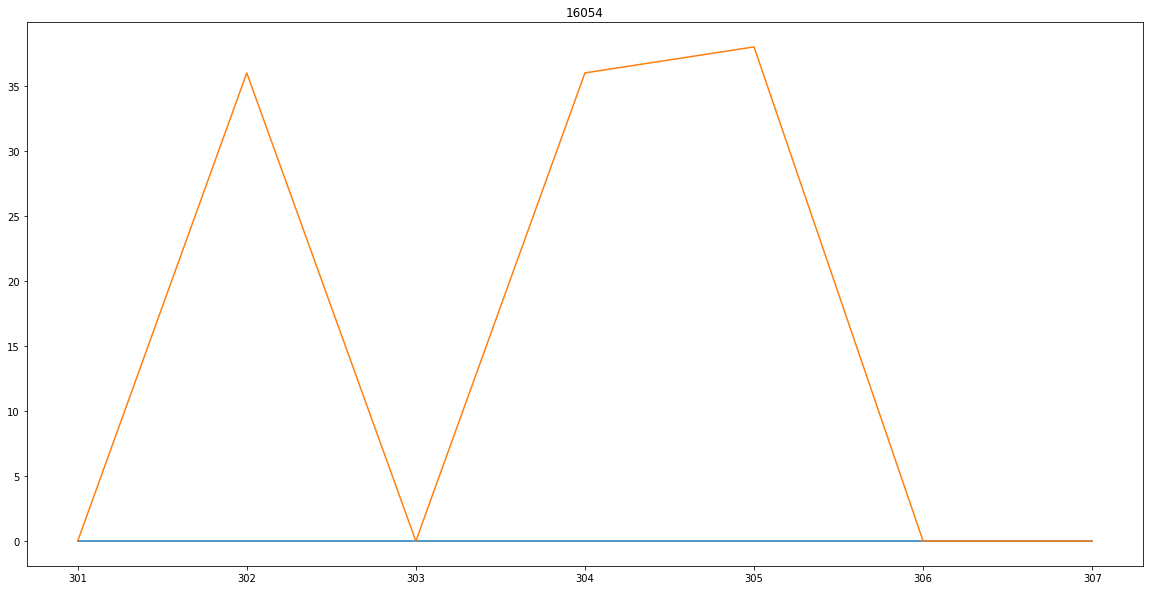

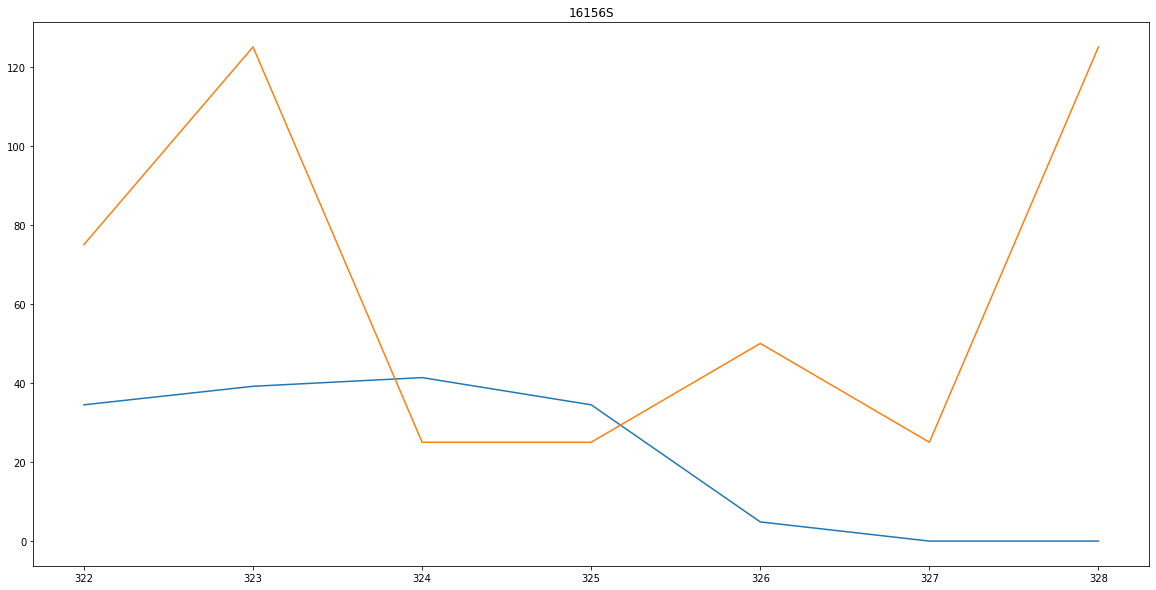

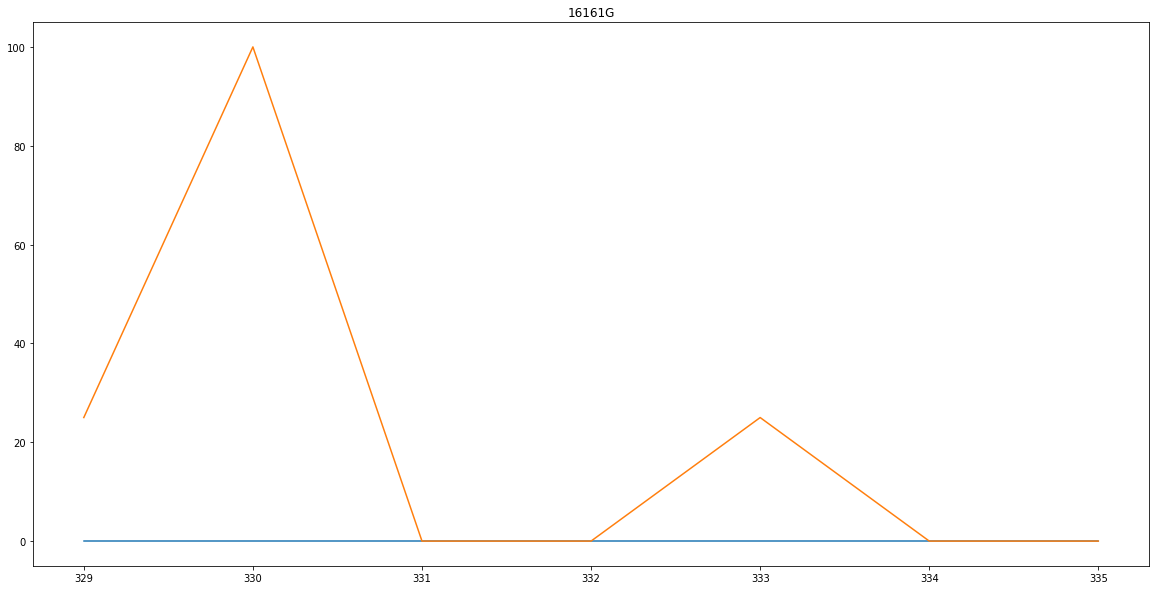

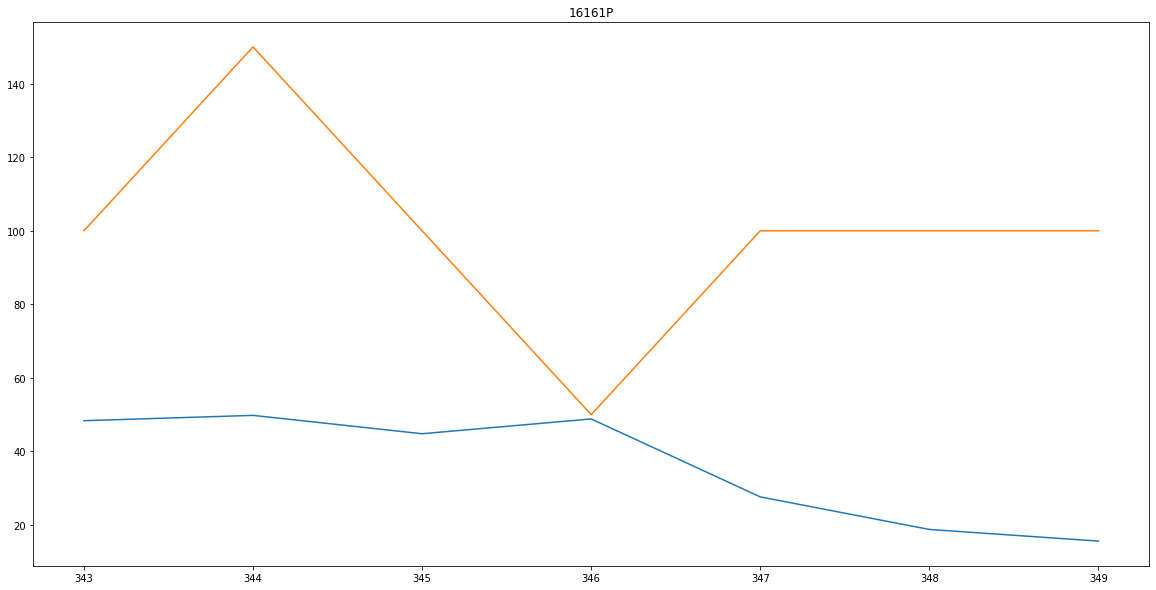

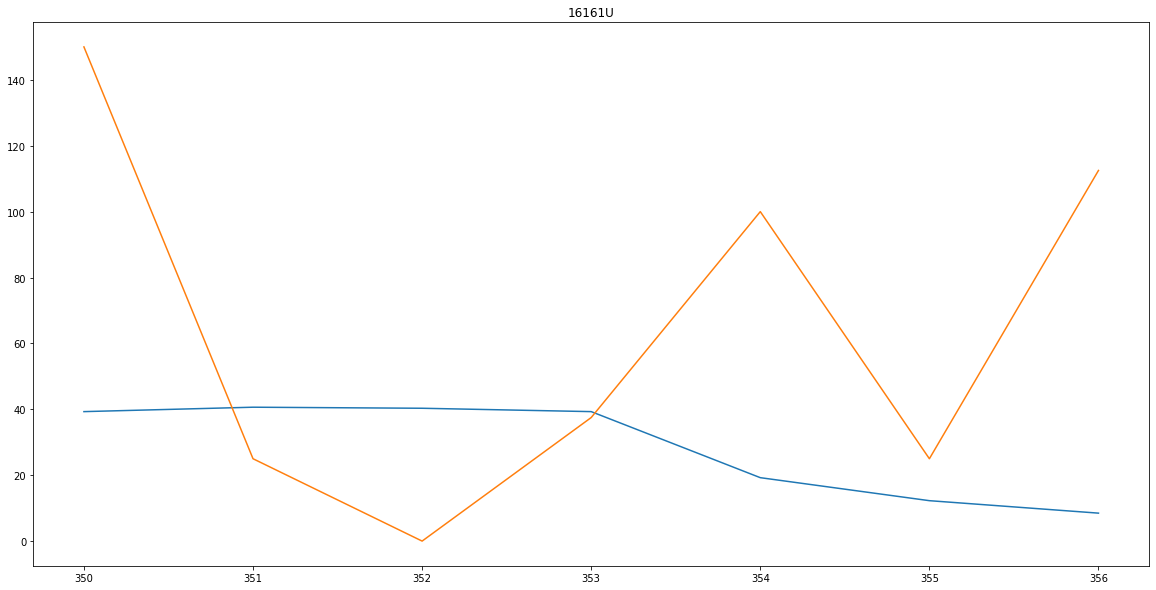

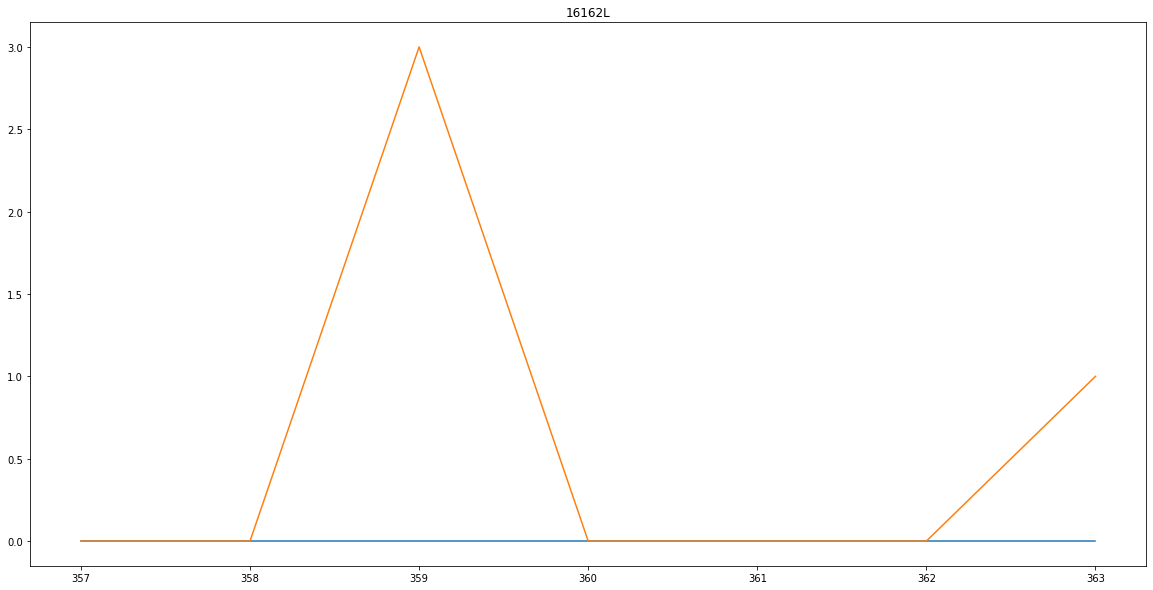

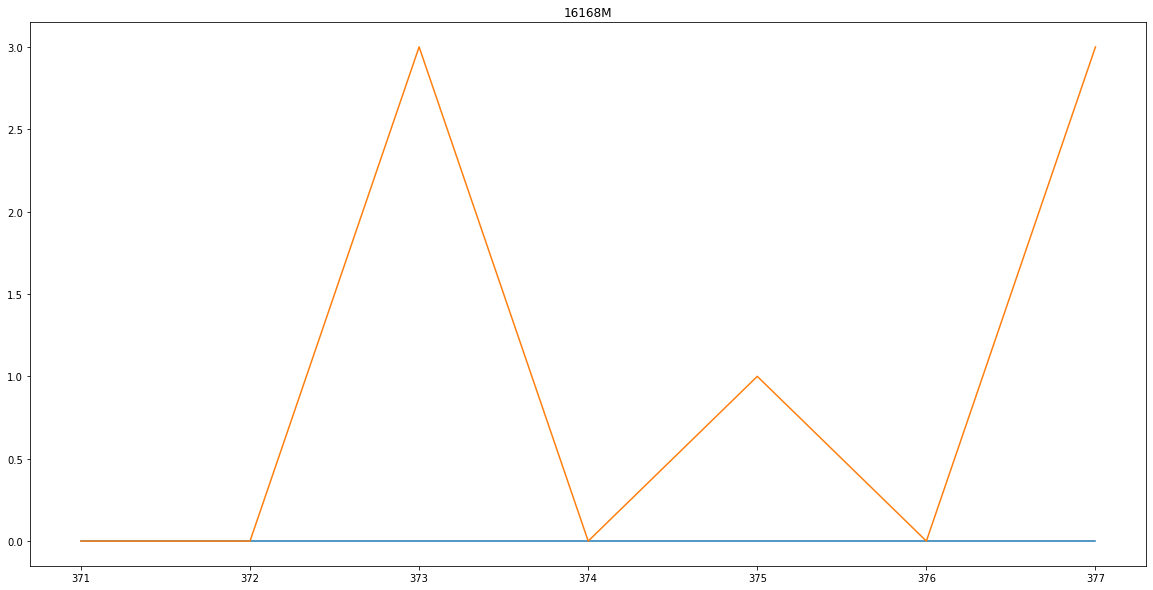

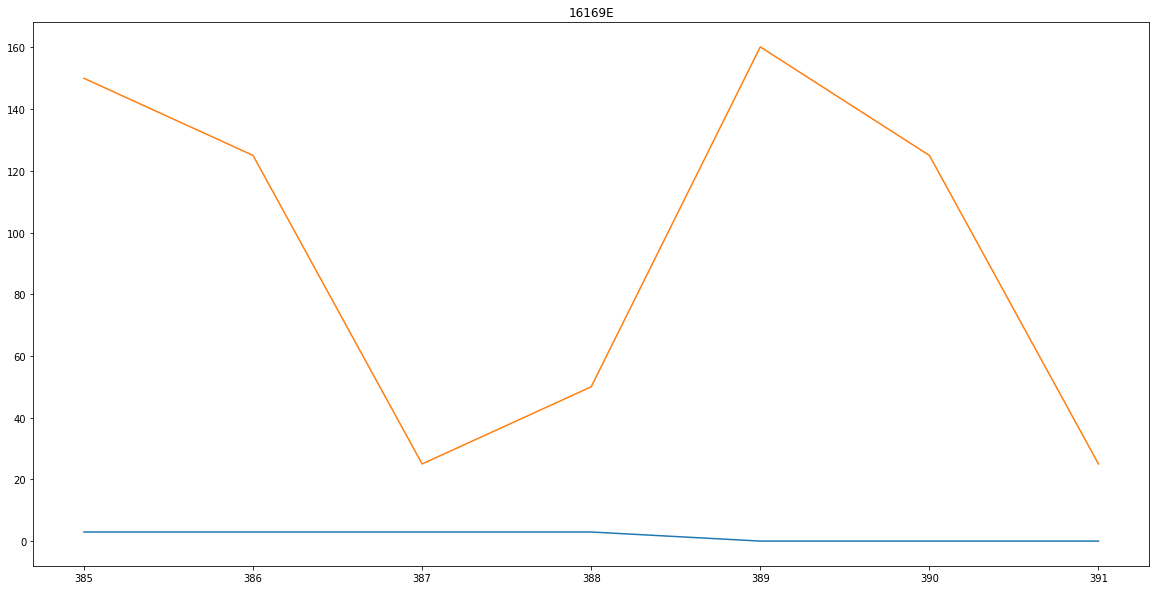

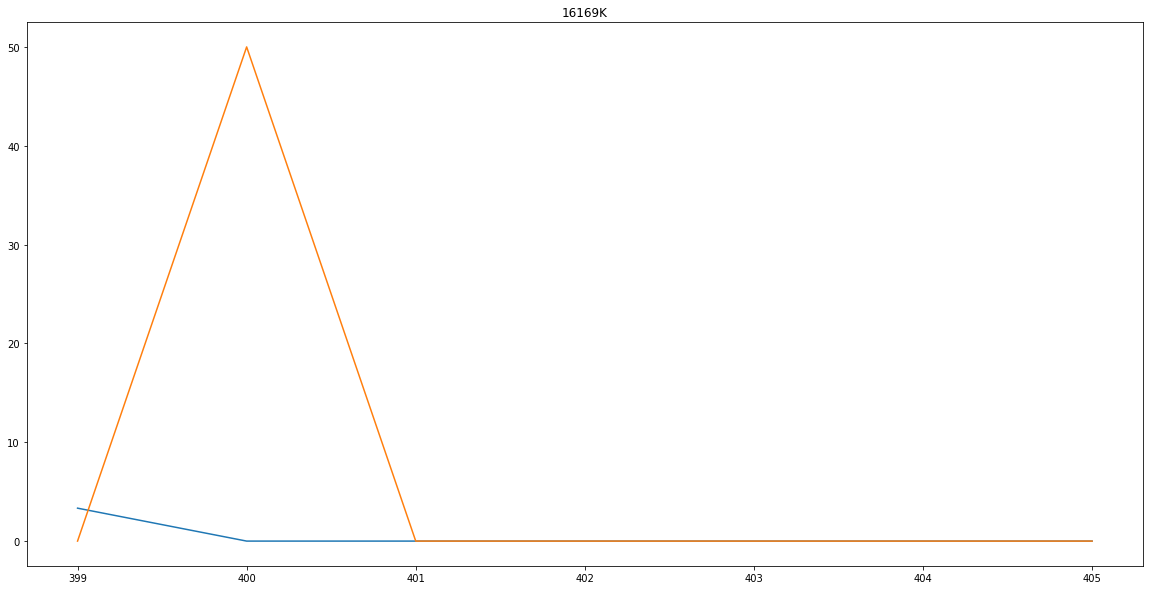

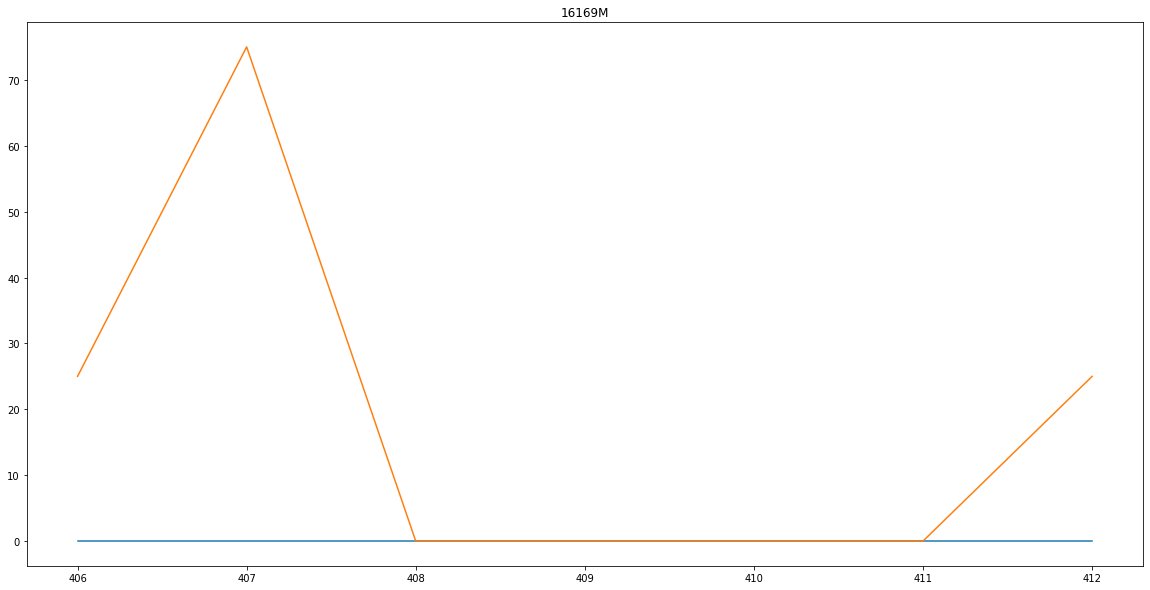

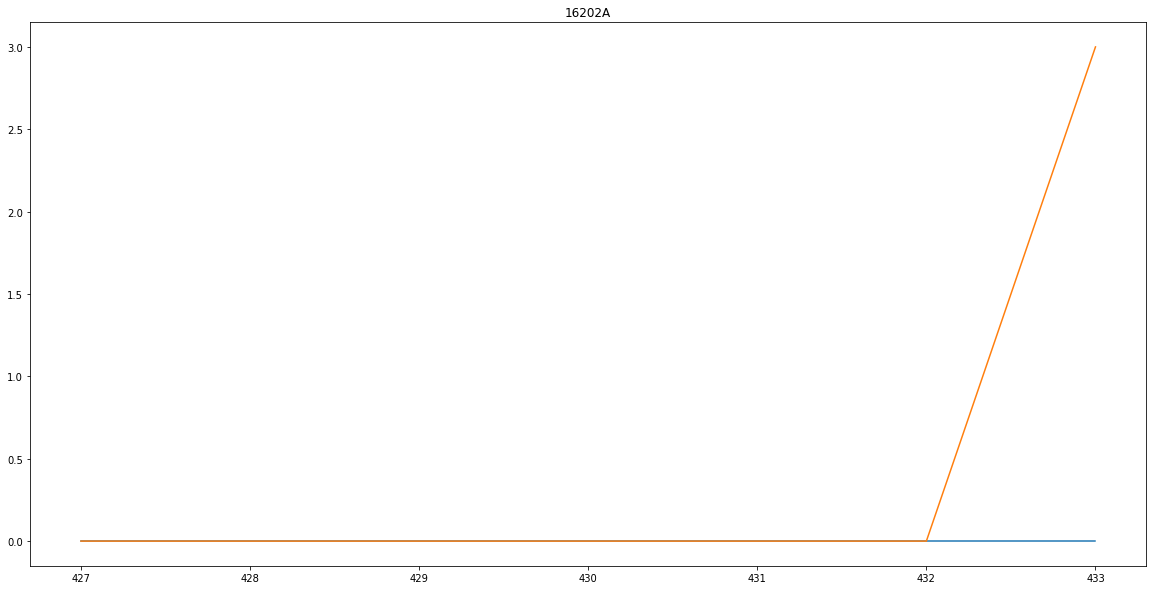

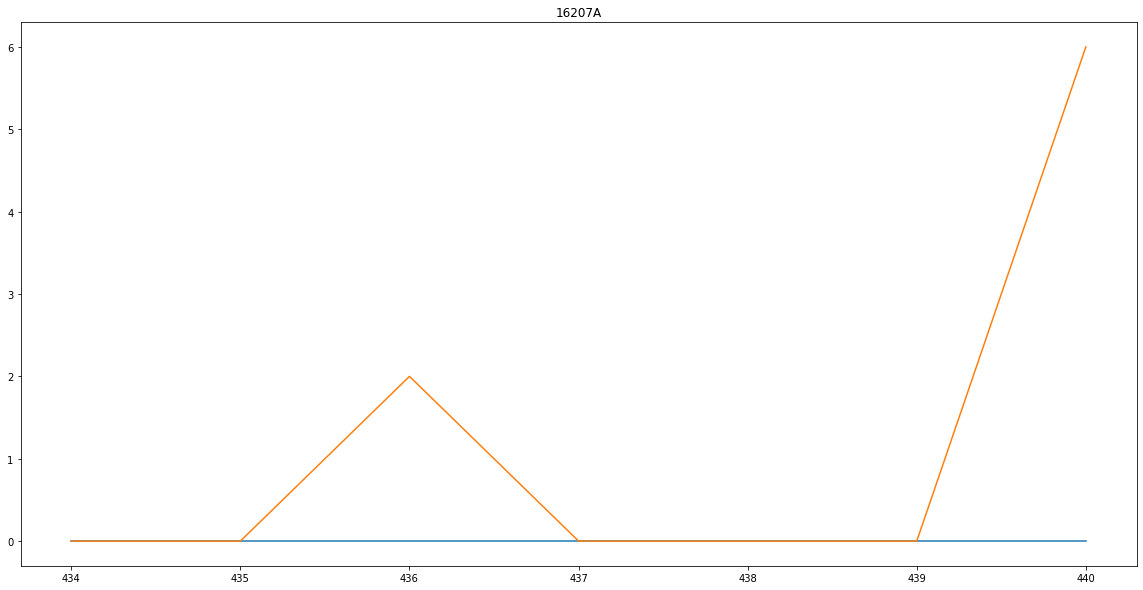

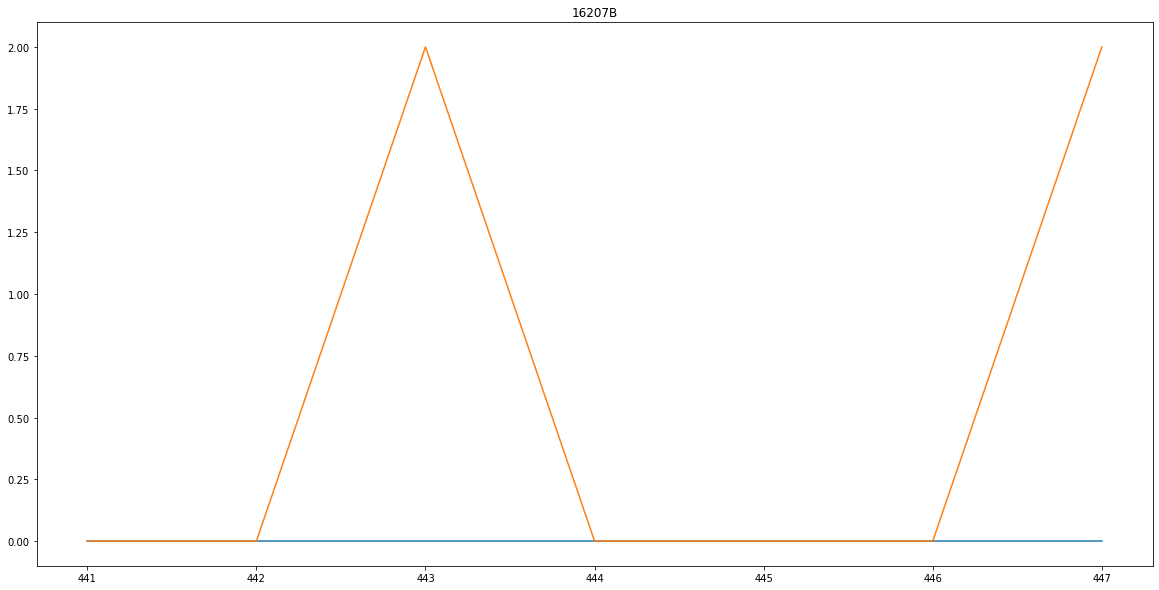

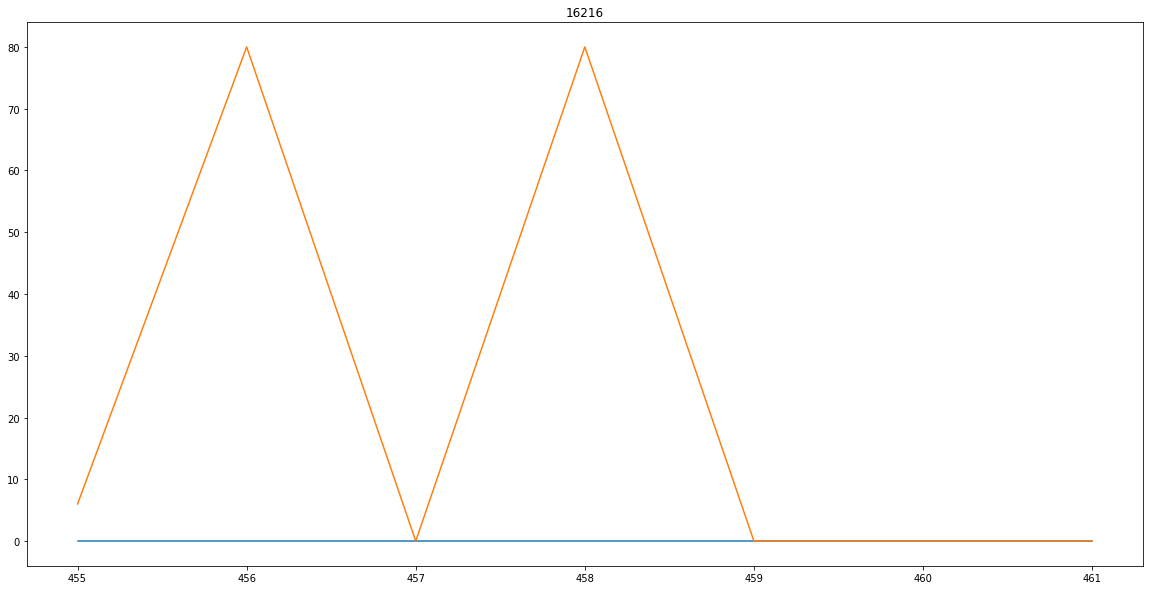

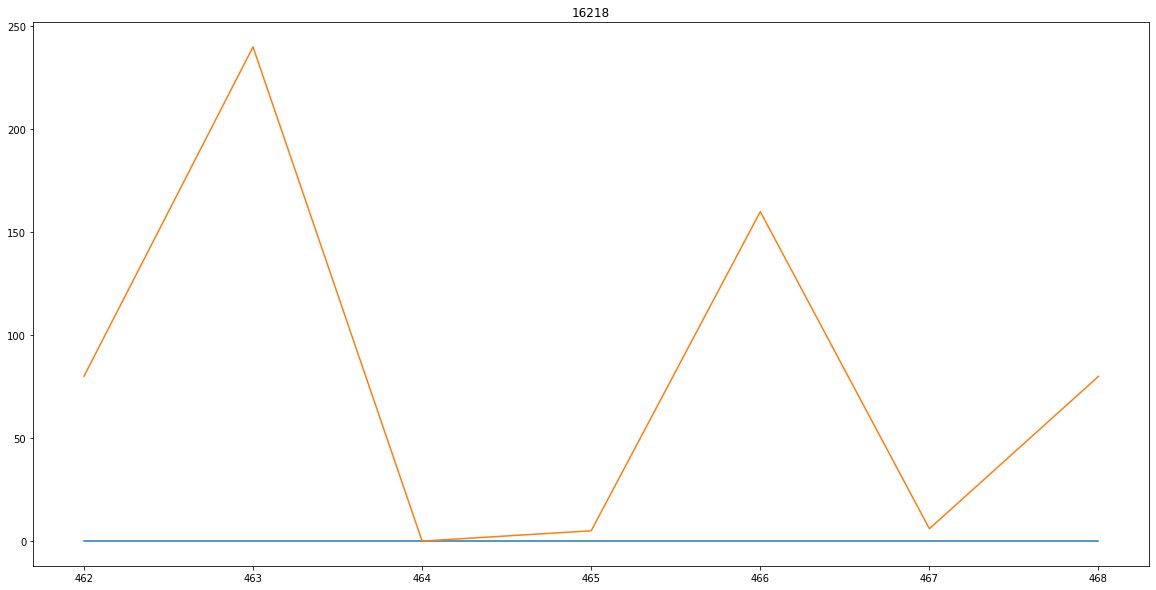

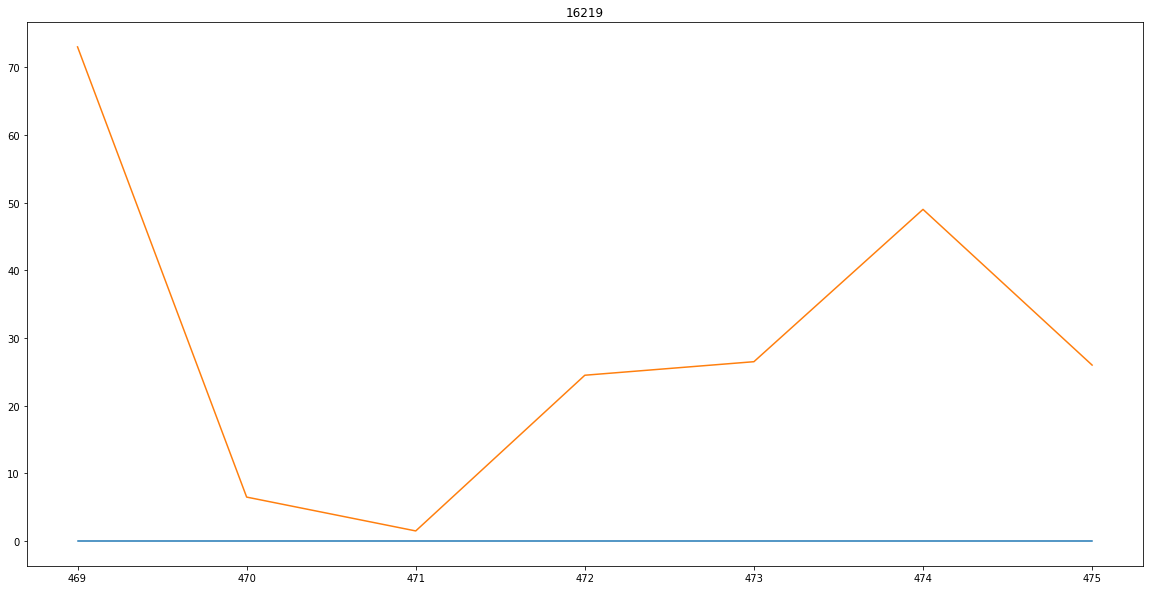

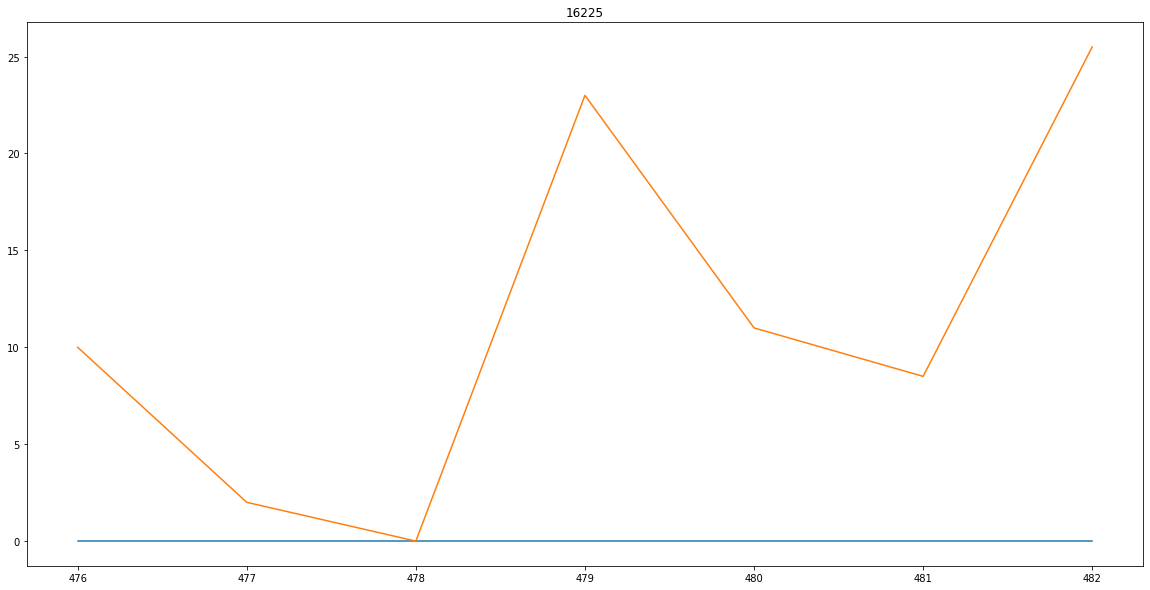

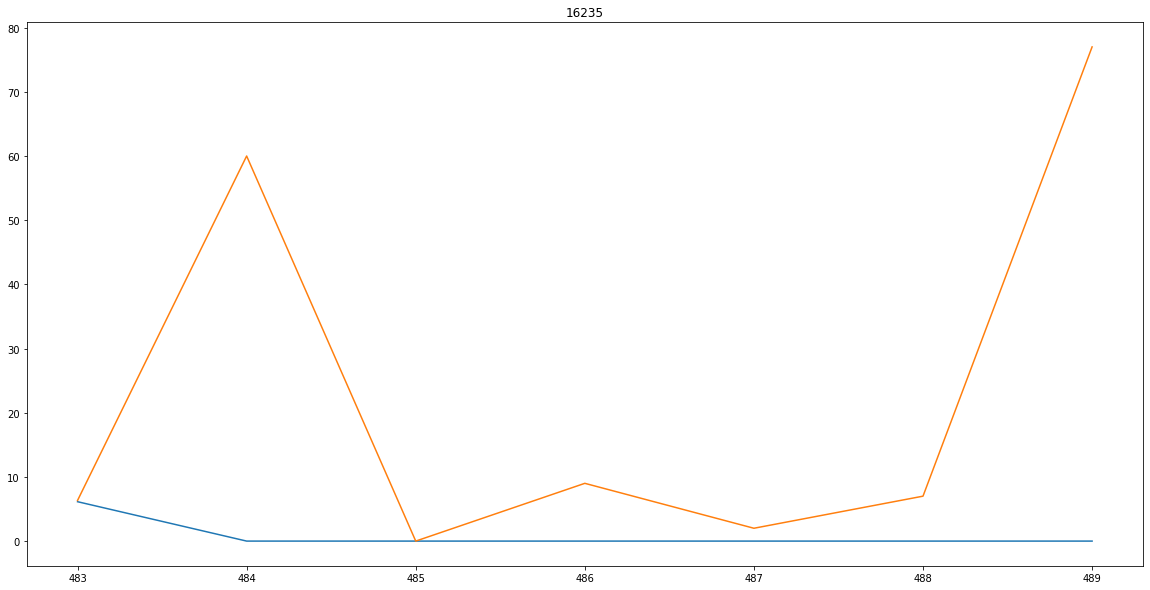

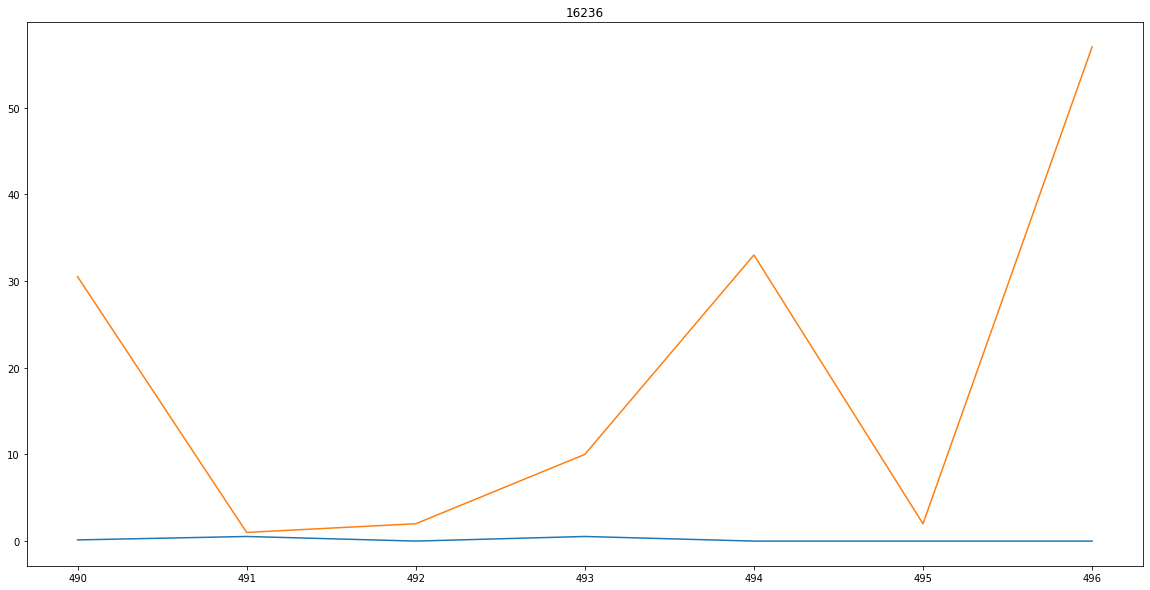

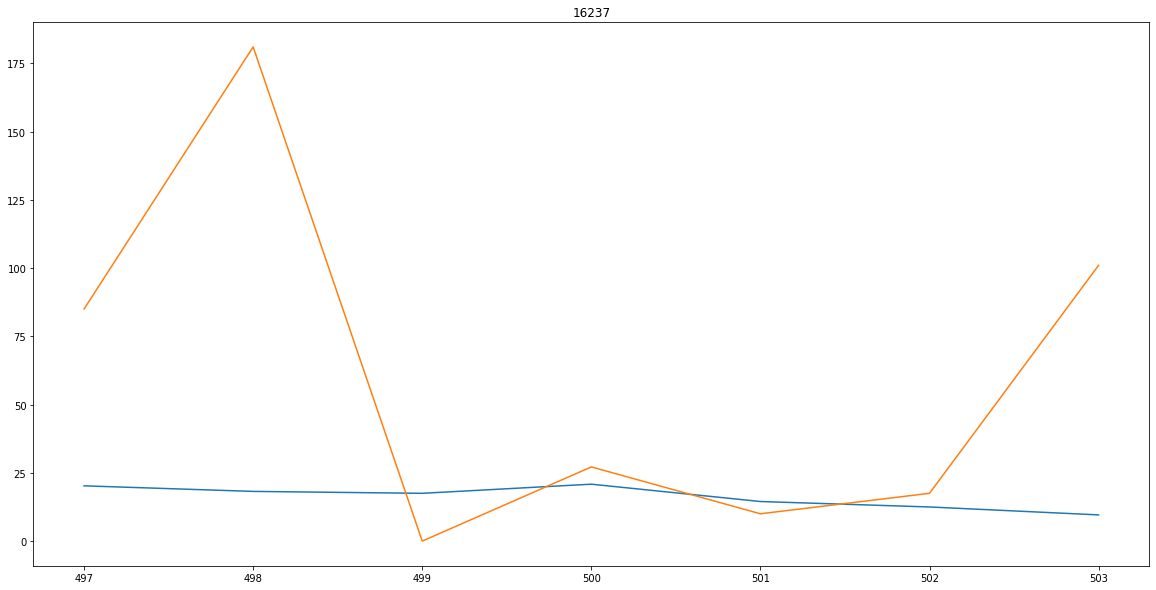

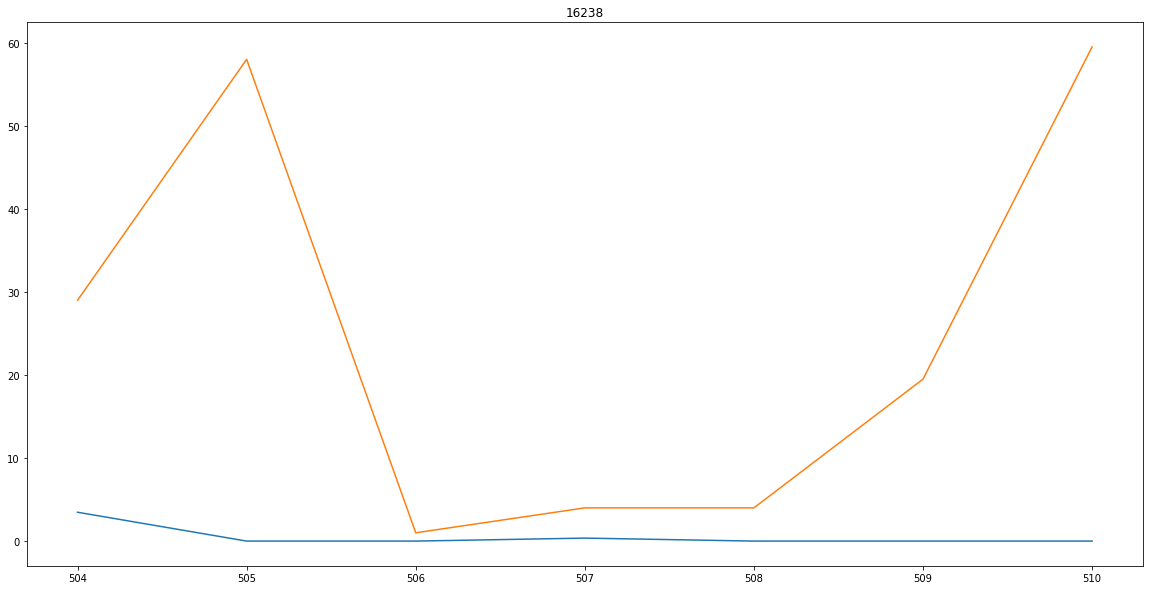

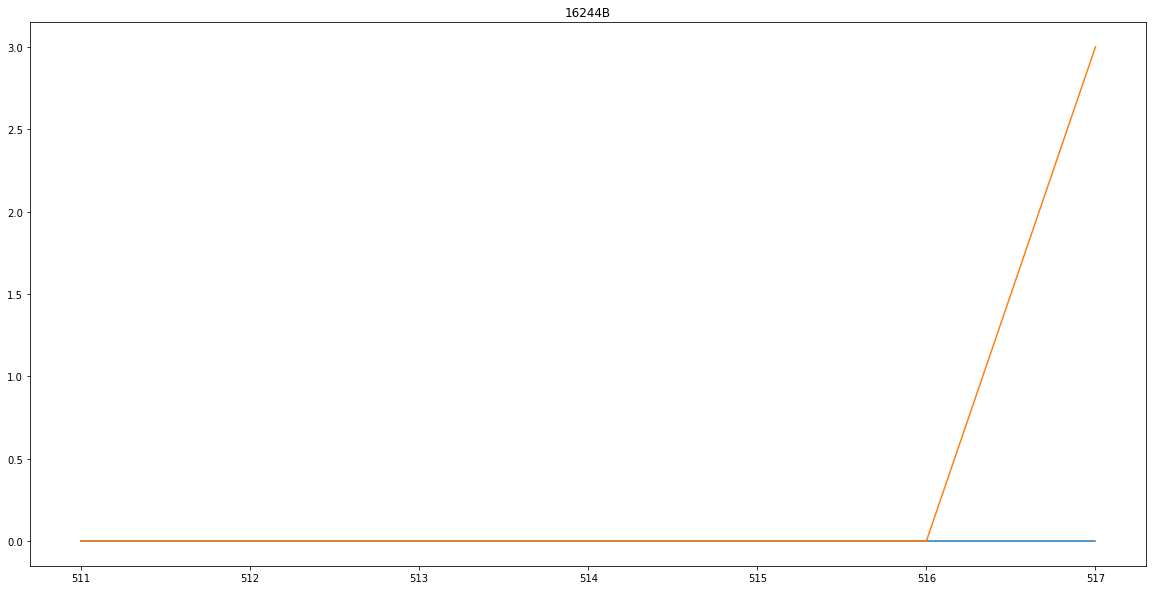

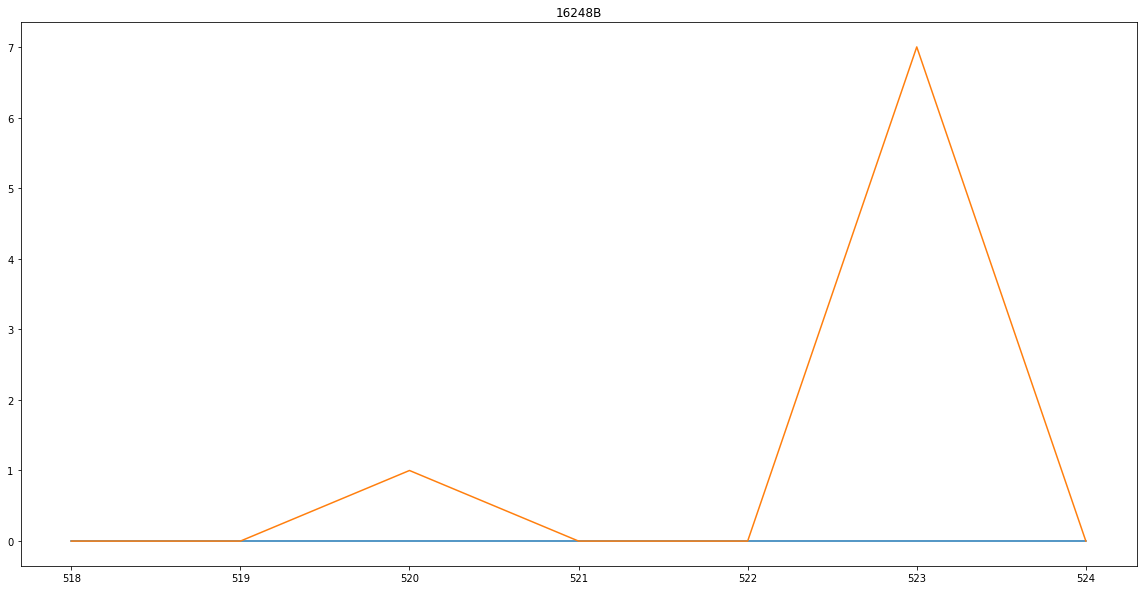

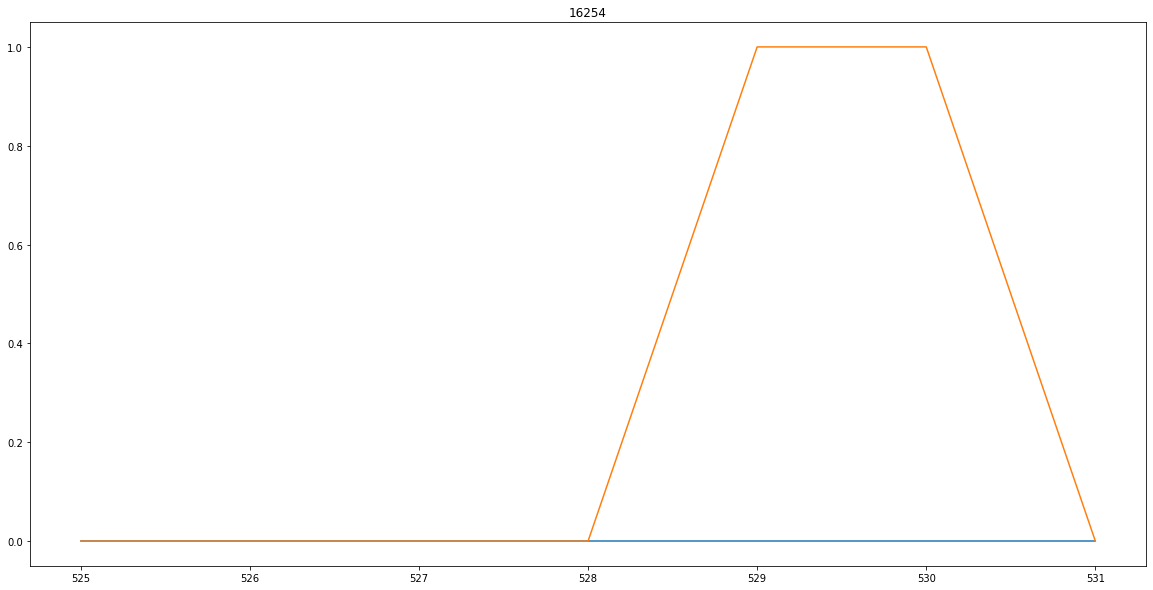

In [ ]:
for i in t3['StockCode'].head(60).tolist():
  fig, ax = plt.subplots(figsize=(20,10))
  test1.loc[test1['StockCode']==i,'lforecast'].plot(ax=ax,title=i)
  test1.loc[test1['StockCode']==i,'Quantity'].plot(ax=ax,title=i)